ПРОЕКТ «ПО УМОЛЧАНИЮ» из  DST-WEEKLY-2.0

Группа dst 89

Макарова Елена 
eamakarova1991@gmail.com

# Финальный проект
**Предсказание стоимости домов, основываясь на истории предложений.**

## Задача
Ко мне обратился представитель крупного агентства недвижимости со следующей проблемой:

"Мои риелторы тратят катастрофически много времени на сортировку объявлений и поиск выгодных предложений. Поэтому их скорость реакции, да и, сказать по правде, качество анализа не дотягивает до уровня конкурентов. А это сказывается на наших финансовых показателях. Твоя задача — разработать модель, которая бы позволила обойти конкурентов по скорости и качеству совершения сделок. Датасет прикладываю."


**Цель:** разработать сервис, который будет предсказывать стоимость домов, основываясь на истории предложений.


## Описание данных

В датасете 18 колонок

Целевая переменная **target** - цена объекта недвижимости

* **status** - статус объявления
* **private pool** - наличие бассейна, наверное дублируется столбцом PrivatePool
* **propertyType** - тип недвижимости
* **street** - адрес
* **baths** - количество ванных комнат
* **homeFacts** - информация о доме. 
* **fireplace** - наличие камина
* **city** - город
* **schools** - рейтинг и близость образовательных учреждений. 
* **sqft** - площадь в квадратных футах
* **zipcode** - почтовый индекс
* **beds** - количество спален (или количество кроватей)
* **state** - штат
* **stories** - наверное, количество владельцев или продаж этого дома или этажей
* **mls-id** - млс-идентификатор,
* **PrivatePool** - Частный бассейн,
* **MlsId** - MlsId идентификатор,
* **target** - цена недвижиости (целевой признак)

# Подгружаем необходимые библиотеки

In [2]:
!pip install catboost

In [3]:
import numpy as np # для работы с массивами
import pandas as pd # для работы с DataFrame 
import re
import json
import ast

# Модули для визуализации
import matplotlib
import matplotlib.pyplot as plt
import plotly
import seaborn as sns
import scipy.stats as stats

from sklearn.model_selection import train_test_split

# инструменты для оценки точности модели 
from sklearn import metrics 
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import f1_score


# Модули алгоритмов
from catboost import CatBoostRegressor
import xgboost as xgb
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.linear_model import SGDRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor

from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV

from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
import sklearn.metrics
from sklearn.metrics import explained_variance_score, max_error, mean_squared_log_error,  median_absolute_error, r2_score 
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")


/opt/conda/lib/python3.7/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:17: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  "Since version 1.0, "


In [4]:
# Настройки Pandas
# Сброс ограничений на количество выводимых рядов
pd.set_option('display.max_rows', None)
# Сброс ограничений на число столбцов
pd.set_option('display.max_columns', None)

In [5]:
# всегда фиксируем RANDOM_SEED, чтобы наши эксперименты были воспроизводимы!
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
isWorking = False # флаг для запуска кода

# Функции

In [6]:
#посмотрим, как выглядят распределения числовых признаков
def visualize_distributions(titles_values_dict):
    columns = min(3, len(titles_values_dict))
    rows = (len(titles_values_dict) - 1) // columns + 1
    fig = plt.figure(figsize = (columns * 6, rows * 4))
    for i, (title, values) in enumerate(titles_values_dict.items()):
        hist, bins = np.histogram(values, bins = 20)
        ax = fig.add_subplot(rows, columns, i + 1)
        ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
        ax.set_title(title)
    plt.show()

In [7]:
def metrics_print(y_test, y_pred):
    print(f"Точность наивной модели по метрике MAE: {mae(y_test, y_pred).round(2)}$")
    print(f"Точность наивной модели по метрике MAPE: {mape(y_test, y_pred).round(2)}%")
    #Вычисляем коэффициент детерминации:
    print(f"Точность наивной модели по метрике R2: {r2_score(y_test, y_pred).round(2)}%")
    print(f"Точность наивной модели по метрике RMSE: {(np.sqrt(mse(y_test, y_pred))).round(2)}")

## Загружаем данные

In [8]:
# # путь к файлу, доступ через google colab
# from google.colab import drive
# drive.mount('/content/drive')
# path = './drive/My Drive/Colab Notebooks/skillfactory/дипломный_проект'

In [9]:
# data = pd.read_csv(path+'/data.csv')

In [10]:
data = pd.read_csv('/kaggle/input/final-project-dstweekly20/data.csv')

# EDA

In [11]:
# посмотрим наш датасет (3 строчки)
data.head(3)

status private pool        propertyType             street    baths  \
0    Active          NaN  Single Family Home     240 Heather Ln      3.5   
1  for sale          NaN  single-family home  12911 E Heroy Ave  3 Baths   
2  for sale          NaN  single-family home  2005 Westridge Rd  2 Baths   

                                           homeFacts fireplace  \
0  {'atAGlanceFacts': [{'factValue': '2019', 'fac...  Gas Logs   
1  {'atAGlanceFacts': [{'factValue': '2019', 'fac...       NaN   
2  {'atAGlanceFacts': [{'factValue': '1961', 'fac...       yes   

             city                                            schools  \
0  Southern Pines  [{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...   
1  Spokane Valley  [{'rating': ['4/10', 'None/10', '4/10'], 'data...   
2     Los Angeles  [{'rating': ['8/10', '4/10', '8/10'], 'data': ...   

         sqft zipcode    beds state stories mls-id PrivatePool       MlsId  \
0        2900   28387       4    NC     NaN    NaN         NaN      611019   
1  1,947 sqft   99216  3 Beds    WA     2.0    NaN         NaN   201916904   
2  3,000 sqft   90049  3 Beds    CA     1.0    NaN         yes  FR19221027   

       target  
0    $418,000  
1    $310,000  
2  $2,895,000

In [12]:
# размерность
data.shape

(377185, 18)

In [13]:
# информация по датасету
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103115 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226470 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

In [14]:
# дубликаты в исходном датафрейме
data[data.duplicated() == True]
data.duplicated().sum()

50

In [15]:
#Удалим дубликаты и проверим результат:
data = data.drop_duplicates().reset_index(drop=True)
data.duplicated().sum()

0

In [16]:
# посмотрим на пропуски в данных
print(f"пропуски в колонках: {data.isna().sum().sort_values(ascending=False)}")
print(f"пропуски в процентах: {data.isna().sum().sort_values(ascending=False)/(data.shape[0]/100)}")

пропуски в колонках: private pool    372954
mls-id          352193
PrivatePool     336825
fireplace       274023
stories         150673
baths           106308
beds             91254
MlsId            66869
sqft             40550
status           39917
propertyType     34733
target            2480
city                34
street               2
zipcode              0
schools              0
state                0
homeFacts            0
dtype: int64
пропуски в процентах: private pool    98.891378
mls-id          93.386453
PrivatePool     89.311520
fireplace       72.659127
stories         39.952007
baths           28.188315
beds            24.196640
MlsId           17.730786
sqft            10.752118
status          10.584274
propertyType     9.209699
target           0.657589
city             0.009015
street           0.000530
zipcode          0.000000
schools          0.000000
state            0.000000
homeFacts        0.000000
dtype: float64


In [17]:
data.describe()

status private pool        propertyType                 street  \
count     337218         4181              342402                 377133   
unique       159            1                1280                 337076   
top     for sale          Yes  single-family home  Address Not Disclosed   
freq      156058         4181               92199                    672   

          baths                                          homeFacts fireplace  \
count    270827                                             377135    103112   
unique      229                                             321009      1653   
top     2 Baths  {'atAGlanceFacts': [{'factValue': '', 'factLab...       yes   
freq      52458                                               7174     50353   

           city                                            schools    sqft  \
count    377101                                             377135  336585   
unique     2026                                             297365   25405   
top     Houston  [{'rating': [], 'data': {'Distance': [], 'Grad...       0   
freq      24441                                               4204   11854   

       zipcode    beds   state stories   mls-id PrivatePool   MlsId    target  
count   377135  285881  377135  226462    24942       40310  310266    374655  
unique    4549    1184      39     348    24907           2  232944     43939  
top      32137  3 Beds      FL     1.0  No MLS#         yes  NO MLS  $225,000  
freq      2141   53454  115434   67451        3       28792      24      1462

Видно,что  у нас очень грязные данные: много пропусков, строковые значения в численных столбцах и пр. 

Рассмотрим каждый признак по отдельности.

## Обработка признаков.

### Целевой признак Цена ( target ) 

In [18]:
data['target'].value_counts()

$225,000              1462
$275,000              1355
$250,000              1312
$350,000              1296
$299,900              1276
$325,000              1244
$249,900              1241
$399,000              1239
$199,900              1199
$299,000              1176
$375,000              1163
$450,000              1141
$499,000              1099
$175,000              1096
$425,000              1075
$599,000              1012
$265,000               992
$235,000               975
$150,000               973
$399,900               963
$285,000               952
$699,000               951
$1,000                 947
$215,000               947
$185,000               937
$165,000               936
$799,000               909
$349,900               906
$149,900               900
$300,000               892
$239,900               890
$125,000               888
$650,000               885
$475,000               872
$550,000               871
$199,000               855
$179,900               855
$

In [19]:
data['target'].isna().sum()

2480

In [20]:
# Удалим отсутвующие значения в target
data = data.dropna (subset=['target'])

почисти некоторые явные значения

In [21]:
# data['target'] = data.target.apply(lambda x: x if type(x)!=str else x
#                                 .replace('$', '')
#                                 .replace('+', '')
#                                 .replace(',', '')
#                                 ).astype(int)

In [22]:
# уберем знак $ из значения
data['target'] = data['target'].apply(lambda x: str(x).replace('$',''))

# для дальнейшего преобразование в численный тип , уберем знак ","
data['target'] = data['target'].apply(lambda x: str(x).replace(',',''))

# знак "+" , наверняка несет смысл что цена=х и более, уберем этот знак
data['target'] = data['target'].apply(lambda x: str(x).replace('+',''))

# можно предположить , что mo означает помесячная оплата. Тогда или можно удалить эти данные 
# или представить сколько может стоить цена этой недвижимости на покупку. 
#изучив в интернете сведенья пришла к выводу, что примерно  в 100-300 раз стоимость больше, чем плата в месяц за аренду

# у нас есть одно значения (1,215-1,437/mo), после предыдущих преобразований имеет вид :  1215 - 1437 - предролагаю, что правильно будет заменить на среднее между 1215 и 1437 = 1326 и * 250)
data['target'] = data['target'].apply(lambda x: str(x).replace('1215 - 1437/mo','39780000'))

data['target'] = data['target'].apply(lambda x: str(x).replace('/mo','000000')).astype(int)*2.5


In [23]:
# Приведем к числовому типу
data['target'] = data['target'].astype(int)

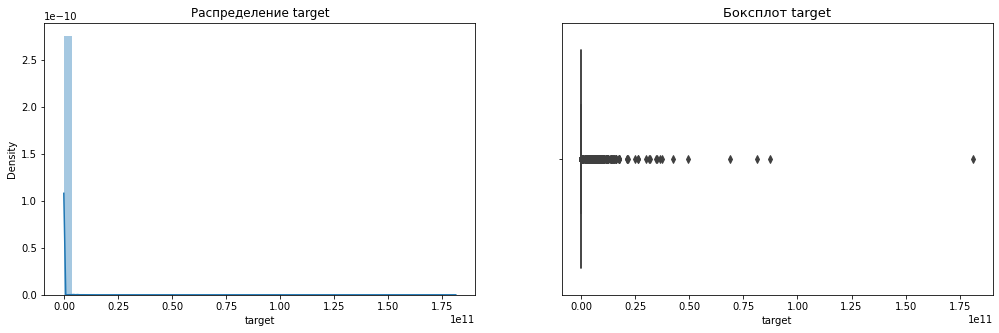

count    3.746550e+05
mean     1.016751e+07
std      4.790991e+08
min      2.000000e+00
25%      4.700000e+05
50%      8.024750e+05
75%      1.462500e+06
max      1.812500e+11
Name: target, dtype: float64

In [24]:
plt.figure(figsize=(17, 5))
plt.subplot(1,2,1)
plt.title(f"Распределение {'target'}")
sns.distplot((data['target']), bins=50)

plt.subplot(1,2,2)
sns.boxplot(data['target'])
plt.xlabel('target')
plt.title(f"Боксплот {'target'}", fontsize=13)
plt.show()
data['target'].describe()

экспоненциальное распределение.

Логарифмируем цену.

### Новую целевую переменную для удобства сохраним в отдельный столбец ( target_log )

In [25]:
data['target_log'] = np.log(1 + (data.target)) 

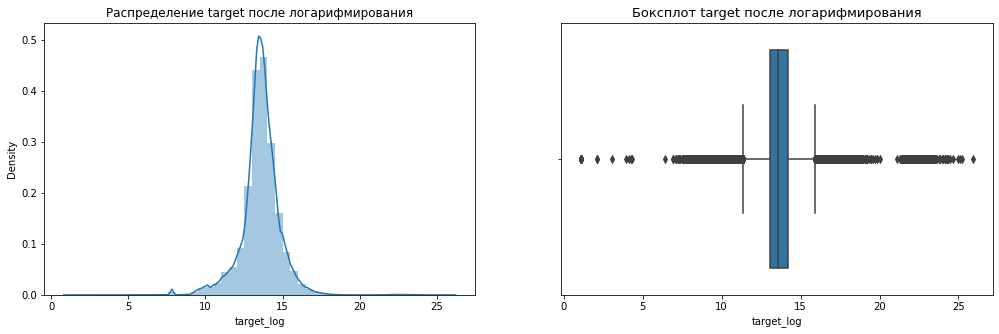

count    374655.000000
mean         13.571470
std           1.230966
min           1.098612
25%          13.060490
50%          13.595457
75%          14.195659
max          25.923143
Name: target_log, dtype: float64

In [26]:
plt.figure(figsize=(17, 5))
plt.subplot(1,2,1)
plt.title(f"Распределение {'target'} после логарифмирования")
sns.distplot((data['target_log']), bins=50)

plt.subplot(1,2,2)
sns.boxplot((data['target_log']))
plt.xlabel('target_log')
plt.title('Боксплот target после логарифмирования', fontsize=13)
plt.show()
data['target_log'].describe()

Есть выбросы.

Удалим явно некорректные значения (как например цена в $1).

Удалим всё, что меньше 7,5 тысяч $

А также всё, что больше 18 мил. $

In [27]:
len(data)

374655

In [28]:
data = data[data['target']>7500] 
data = data[data['target']<18000000]
len(data)

370190

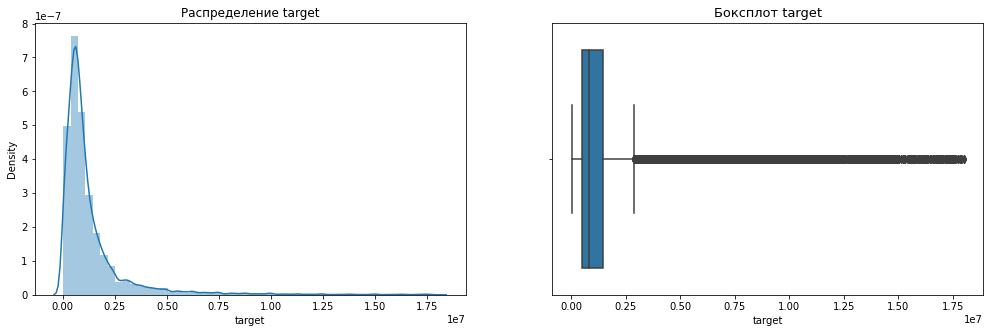

count    3.701900e+05
mean     1.339918e+06
std      1.839861e+06
min      7.737000e+03
25%      4.712500e+05
50%      7.999750e+05
75%      1.437500e+06
max      1.798750e+07
Name: target, dtype: float64


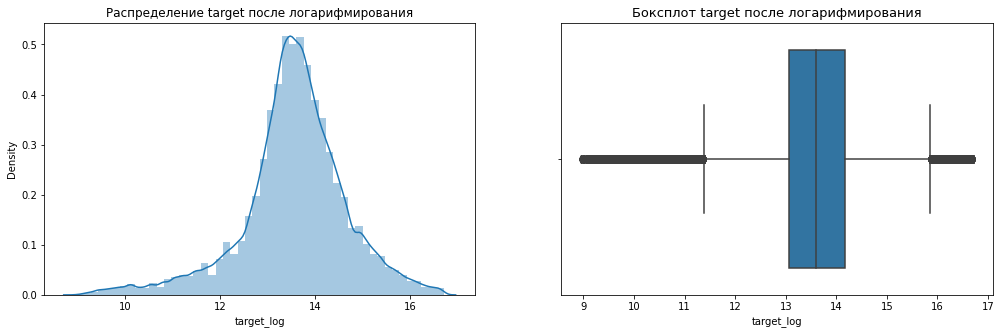

count    370190.000000
mean         13.553115
std           1.107142
min           8.953899
25%          13.063146
50%          13.592337
75%          14.178417
max          16.705188
Name: target_log, dtype: float64


In [29]:
plt.figure(figsize=(17, 5))
plt.subplot(1,2,1)
plt.title(f"Распределение {'target'}")
sns.distplot((data['target']), bins=50)

plt.subplot(1,2,2)
sns.boxplot(data['target'])
plt.xlabel('target')
plt.title(f"Боксплот {'target'}", fontsize=13)
plt.show()
print(data['target'].describe())

plt.figure(figsize=(17, 5))
plt.subplot(1,2,1)
plt.title(f"Распределение {'target'} после логарифмирования")
sns.distplot((data['target_log']), bins=50)

plt.subplot(1,2,2)
sns.boxplot((data['target_log']))
plt.xlabel('target_log')
plt.title('Боксплот target после логарифмирования', fontsize=13)
plt.show()
print(data['target_log'].describe())


### признак информация о доме ( homeFacts )

In [30]:
print('Пропуски:', data.homeFacts.isna().sum())
print('Уникальных:', data.homeFacts.nunique())

Пропуски: 0
Уникальных: 315509


In [31]:
# Посмотрим на значения
data['homeFacts'].head(2)

0    {'atAGlanceFacts': [{'factValue': '2019', 'fac...
1    {'atAGlanceFacts': [{'factValue': '2019', 'fac...
Name: homeFacts, dtype: object

Данный столбец содержит 7 отдельных признаков:
- YEAR BUILT - год постройки
- REMODELED YEAR - год реконструкции
- HEATING - отопление
- COOLING - охлаждение
- PARKING - парковка
- LOTSIZE - площадь
- PRICE/SQFT - цена за кв.Фут

Информация о площади и цене в датасете уже есть. 

Добавление в датасет 'Remodeled year', 'Heating' и 'Cooling' ухудшает метрику 

А вот 'Parking' и 'Year built' делает лучше!

In [32]:
data['homeFacts'] = data['homeFacts'].apply(
    lambda x: eval(x)).apply(lambda x: list(x.values())[0])
list_columns = ['Year built', 'Remodeled year', 'Heating',
                'Cooling', 'Parking', 'lotsize', 'Price/sqft']

for column in enumerate(list_columns):
    data[column[1]] = None
    data[column[1]] = data['homeFacts'].apply(lambda x: None if x[column[0]].get(
        'factValue') == '' else x[column[0]].get('factValue'))

In [33]:
col = ['Year built', 'Remodeled year', 'Heating', 'Cooling', 'Parking', 'lotsize', 'Price/sqft']
for i in col:
    print('Пропуски:',i , data[i].isna().sum())
    print('Уникальных:',i , data[i].nunique())

Пропуски: Year built 61156
Уникальных: Year built 227
Пропуски: Remodeled year 221415
Уникальных: Remodeled year 152
Пропуски: Heating 106945
Уникальных: Heating 1966
Пропуски: Cooling 120476
Уникальных: Cooling 1438
Пропуски: Parking 172283
Уникальных: Parking 3325
Пропуски: lotsize 59841
Уникальных: lotsize 37134
Пропуски: Price/sqft 60482
Уникальных: Price/sqft 5561


In [34]:
data.head(2)

status private pool        propertyType             street    baths  \
0    Active          NaN  Single Family Home     240 Heather Ln      3.5   
1  for sale          NaN  single-family home  12911 E Heroy Ave  3 Baths   

                                           homeFacts fireplace  \
0  [{'factValue': '2019', 'factLabel': 'Year buil...  Gas Logs   
1  [{'factValue': '2019', 'factLabel': 'Year buil...       NaN   

             city                                            schools  \
0  Southern Pines  [{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...   
1  Spokane Valley  [{'rating': ['4/10', 'None/10', '4/10'], 'data...   

         sqft zipcode    beds state stories mls-id PrivatePool      MlsId  \
0        2900   28387       4    NC     NaN    NaN         NaN     611019   
1  1,947 sqft   99216  3 Beds    WA     2.0    NaN         NaN  201916904   

    target  target_log Year built Remodeled year                 Heating  \
0  1045000   13.859528       2019           None  Central A/C, Heat Pump   
1   775000   13.560620       2019           None                    None   

  Cooling Parking    lotsize Price/sqft  
0    None    None       None       $144  
1    None    None  5828 sqft  $159/sqft

чуть позже обработаем и новые полученные признаки!

можно удалить признак homeFacts

In [35]:
data.drop(['homeFacts','Heating', 'Cooling', 'lotsize'], axis=1, inplace=True)

### Признак штат ( state )

In [36]:
data['state'].isna().sum()

0

In [37]:
len(data['state'].unique())

39

In [38]:
# Приводим к верхнему регистру
data['state'] = data['state'].apply(lambda x: x.upper())
len(data['state'].unique())

38

In [39]:
data['state'].value_counts()

FL    113635
TX     83080
NY     23179
CA     22662
NC     21744
TN     18152
WA     13645
OH     12400
IL      8786
NV      8380
GA      6608
CO      6361
PA      5483
DC      4546
MI      4191
AZ      3347
IN      3271
OR      2772
MA      1447
UT      1318
MD      1086
VT       863
MO       831
VA       798
WI       446
NJ       436
ME       258
IA       242
KY        90
OK        49
MS        40
SC        28
MT         7
DE         5
BA         1
AL         1
OT         1
OS         1
Name: state, dtype: int64

<AxesSubplot:>

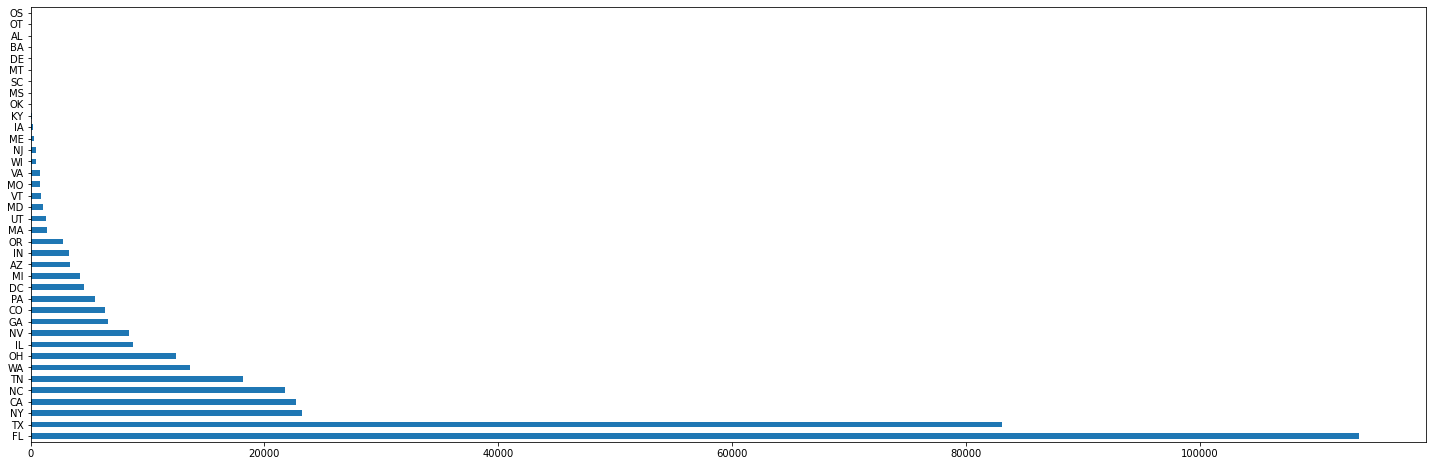

In [40]:
#посмотрим на распределение
plt.figure(figsize=(25,8))
data['state'].value_counts().plot.barh(stacked=True)

Всего 38 уникальных штатов.

Большинство обявлений о продаже в Флорида (FL) и Техасе (TX).

Пропусков нет

единичные значения удалим

In [41]:
data = data[data['state']!='OS']
data = data[data['state']!='OT']
data = data[data['state']!='AL']
data = data[data['state']!='BA']

### Признак  школа ( schools) и создание новых

In [42]:
len(data['schools'].unique())

292157

In [43]:
type(data['schools'])

pandas.core.series.Series

In [44]:
data['schools'][0]

'[{\'rating\': [\'4\', \'4\', \'7\', \'NR\', \'4\', \'7\', \'NR\', \'NR\'], \'data\': {\'Distance\': [\'2.7 mi\', \'3.6 mi\', \'5.1 mi\', \'4.0 mi\', \'10.5 mi\', \'12.6 mi\', \'2.7 mi\', \'3.1 mi\'], \'Grades\': [\'3–5\', \'6–8\', \'9–12\', \'PK–2\', \'6–8\', \'9–12\', \'PK–5\', \'K–12\']}, \'name\': [\'Southern Pines Elementary School\', \'Southern Middle School\', \'Pinecrest High School\', \'Southern Pines Primary School\', "Crain\'s Creek Middle School", \'Union Pines High School\', \'Episcopal Day Private School\', \'Calvary Christian Private School\']}]'

в признаке школа, мне кажется самыми важными данными является рейтинг школы и расстояние до школы.

Выделим эти новые признаки

In [45]:
# функция для преодразования признака школ
def clear_school(x):
    x = x[1:-1]
    x = x.replace("'", '"')
    x = x.split(', "name"')
    x = x[0] + "}"
    x = x.replace(' None, ', ' "None", ')

    d = json.loads(x)
    dictance = []
    rating = []
    for i in d['data']['Distance']:
        i = float(i.replace('mi', ''))
        dictance.append(i)
    for i in d['rating']:
        if '/'in i:
            i = i.split('/')[0]
        rating.append(i)

    return dictance, rating

In [46]:
schools_data = data['schools'].map(clear_school)
school_data = pd.DataFrame.from_records(schools_data, columns = ['schools_distance', 'schools_rating'])

In [47]:
# Добавим еще количество школ
school_data['schools_count'] = school_data['schools_distance'].apply(lambda x: len(x))

In [48]:
# Выделим средний, минимаьный и максимальный рейтинг школ
def min_rating(x):
    try:
        rating = []
        for r in x:
            if r.isdigit():
                rating.append(int(r))
        return np.min(rating)
    except:
        return 'NoData'
    
def max_rating(x):
    try:
        rating = []
        for r in x:
            if r.isdigit():
                rating.append(int(r)) 
        return np.max(rating)
    except:
        return 'NoData'
    
def mean_rating(x):
    try:
        rating = []
        for r in x:
            if r.isdigit():
                rating.append(int(r))
        return np.mean(rating)
    except:
        return 'NoData'

In [49]:
school_data['schools_min_rating'] = [min_rating(x) for x in school_data['schools_rating']]
school_data['schools_max_rating'] = [max_rating(x) for x in school_data['schools_rating']]
school_data['schools_mean_rating'] = [mean_rating(x) for x in school_data['schools_rating']]

In [50]:
# отсутствующие значения в данных столбцах заменим средним значением
school_data.loc[school_data['schools_min_rating'] == 'NoData', 'schools_min_rating'] = school_data['schools_mean_rating'].mean()
school_data.loc[school_data['schools_max_rating'] == 'NoData', 'schools_max_rating'] = school_data['schools_mean_rating'].mean()
school_data.loc[school_data['schools_mean_rating'].isna(), 'schools_mean_rating'] = school_data['schools_mean_rating'].mean()

In [51]:
# Добавим минимальную, среднюю и максимальную дистацию до школ
def min_dist(x):
    try:
        return np.min(x)
    except:
        return 'NoData'
    
def mean_dist(x):
    try:
        return np.mean(x)
    except:
        return 'NoData'

def max_dist(x):
    try:
        return np.max(x)
    except:
        return 'NoData'

In [52]:
school_data['schools_min_dist'] = school_data['schools_distance'].apply(lambda x: min_dist(x))
school_data['schools_mean_dist'] = school_data['schools_distance'].apply(lambda x: mean_dist(x))
school_data['schools_max_dist'] = school_data['schools_distance'].apply(lambda x: max_dist(x))

In [53]:
school_data.head()

schools_distance               schools_rating  \
0  [2.7, 3.6, 5.1, 4.0, 10.5, 12.6, 2.7, 3.1]  [4, 4, 7, NR, 4, 7, NR, NR]   
1                          [1.65, 1.32, 1.01]                 [4, None, 4]   
2                          [1.19, 2.06, 2.63]                    [8, 4, 8]   
3                     [1.05, 0.1, 1.05, 0.81]                [9, 9, 10, 9]   
4                          [5.96, 3.25, 3.03]                    [4, 5, 5]   

   schools_count schools_min_rating schools_max_rating  schools_mean_rating  \
0              8                  4                  7             5.200000   
1              3                  4                  4             4.000000   
2              3                  4                  8             6.666667   
3              4                  9                 10             9.250000   
4              3                  4                  5             4.666667   

  schools_min_dist  schools_mean_dist schools_max_dist  
0              2.7           5.537500             12.6  
1             1.01           1.326667             1.65  
2             1.19           1.960000             2.63  
3              0.1           0.752500             1.05  
4             3.03           4.080000             5.96

#### Занесем новые полученные признаки в нашу таблицу данных

In [54]:
data = data.drop(columns='schools')

data['schools_count'] = list(school_data['schools_count'])
data['schools_min_dist'] = list(school_data['schools_min_dist'])
data['schools_mean_dist'] = list(school_data['schools_mean_dist'])
data['schools_max_dist'] = list(school_data['schools_max_dist'])
data['schools_min_rating'] = list(school_data['schools_min_rating'])
data['schools_max_rating'] = list(school_data['schools_max_rating'])
data['schools_mean_rating'] = list(school_data['schools_mean_rating'])

data.sample(100)

status private pool  \
281454                     NaN          NaN   
25995                      NaN          NaN   
211670                for sale          NaN   
30990                   Active          NaN   
372868         Pre-foreclosure          NaN   
19296   Under Contract Backups          NaN   
56717                 for sale          NaN   
285864                  Active          NaN   
144338                for sale          NaN   
311025                For sale          NaN   
270761                for sale          NaN   
226202                for sale          NaN   
5843                  for sale          NaN   
99527                 For sale          NaN   
59880          Pre-foreclosure          NaN   
233191                for sale          NaN   
117275                  Active          NaN   
29815                   Active          NaN   
332020                For sale          NaN   
223102                for sale          NaN   
215711                  Active          NaN   
54237                   Active          NaN   
170452                for sale          NaN   
110327                for sale          NaN   
288819                     NaN          NaN   
60579                 for sale          NaN   
245856                  Active          NaN   
324398             foreclosure          NaN   
361123                For sale          NaN   
290433                For sale          NaN   
208138                for sale          NaN   
120318                  Active          NaN   
123644                  Active          NaN   
366941                  Active          NaN   
298528                  Active          NaN   
240530                  Active          NaN   
104387                for sale          NaN   
16151                 For sale          NaN   
317525                  Active          NaN   
15137                      NaN          NaN   
100636                For sale          NaN   
199346                For sale          Yes   
107348                for sale          NaN   
169181                  Active          NaN   
83865                   Active          NaN   
283934                for sale          NaN   
298191                  Active          NaN   
22230                 for sale          NaN   
329046                  Active          NaN   
368795                for sale          NaN   
257573                For sale          NaN   
99464                 for sale          NaN   
370297                  Active          NaN   
223492                for sale          NaN   
160936                for sale          NaN   
270212                for sale          NaN   
234023                for sale          NaN   
265043                For sale          NaN   
67759                   Active          NaN   
33596                      NaN          NaN   
47391                   Active          NaN   
157412                For sale          NaN   
279094   Active Under Contract          NaN   
229981                     NaN          NaN   
352048                  Active          NaN   
132666                For sale          NaN   
113290                For sale          NaN   
51222                   Active          NaN   
30336                 For sale          NaN   
120604                 Pending          NaN   
22791                 For sale          NaN   
252454                for sale          NaN   
17144                 For sale          NaN   
205287                for sale          NaN   
235419                  Active          NaN   
185278                for sale          NaN   
186764                  Active          NaN   
108840                For sale          NaN   
56335                 for sale          NaN   
343075                  Active          NaN   
258731                  Active          NaN   
197255                     NaN          NaN   
197043                  Active          NaN   
350394                  Active          NaN   
228801                for sal

### Новые признаки  ьиним.дистанц до школы,  максимал.дистанция до школы и средняя дистанция до школы ( schools_min_dist ,	schools_mean_dist	,schools_max_dist )

In [55]:
# schools_min_dist

In [56]:
print('Кол-во уникальных значений schools_min_dist = ',len(data['schools_min_dist'].unique()))  #, 'иникальные значения :' ,data['schools_min_dist'].unique())
print('Пропущенных значений в schools_min_dist = ', data['schools_min_dist'].isna().sum())

display(data['schools_min_dist'].value_counts(dropna=False))

Кол-во уникальных значений schools_min_dist =  1472
Пропущенных значений в schools_min_dist =  0


0.3        22098
0.4        20590
0.2        19940
0.5        18511
0.6        15825
0.7        13608
0.1        12353
0.8        10894
0.9         9454
1.0         8036
1.1         6958
1.2         6291
1.3         5643
1.4         4819
1.5         4486
NoData      4180
1.6         3876
1.7         3314
1.8         2721
1.9         2531
2.0         2122
2.1         1931
2.2         1860
0.29        1699
2.3         1679
0.32        1656
0.28        1619
0.26        1604
0.27        1602
0.34        1592
0.33        1581
0.23        1556
0.24        1554
0.31        1542
2.5         1538
2.4         1528
0.25        1527
0.21        1507
0.41        1492
0.36        1492
0.42        1481
0.39        1473
0.22        1456
0.37        1451
0.44        1440
0.35        1420
0.47        1414
0.38        1407
2.6         1401
0.19        1381
0.46        1360
0.43        1351
0.18        1340
0.57        1294
0.49        1291
0.45        1286
0.52        1251
0.51        1249
0.17        12

In [57]:
data.loc[data['schools_min_dist'] == 'NoData', 'schools_min_dist'] = 0
data['schools_min_dist'] = data.schools_min_dist.astype(float).round(1)


In [58]:
# поделим на группы

data.loc[(data['schools_min_dist'] > 0) & (data['schools_min_dist'] <= 1), 'schools_min_dist'] = 1
data.loc[(data['schools_min_dist'] > 1) & (data['schools_min_dist'] <= 2), 'schools_min_dist'] = 2
data.loc[(data['schools_min_dist'] > 2) & (data['schools_min_dist'] <= 3), 'schools_min_dist'] = 3
data.loc[(data['schools_min_dist'] > 3) & (data['schools_min_dist'] <= 4), 'schools_min_dist'] = 4
data.loc[(data['schools_min_dist'] > 4) & (data['schools_min_dist'] <= 5), 'schools_min_dist'] = 5
data.loc[(data['schools_min_dist'] > 5) & (data['schools_min_dist'] <= 7), 'schools_min_dist'] = 6
data.loc[(data['schools_min_dist'] > 7) & (data['schools_min_dist'] <= 10), 'schools_min_dist'] = 7
data.loc[(data['schools_min_dist'] > 10) & (data['schools_min_dist'] < 25), 'schools_min_dist'] = 8
data.loc[(data['schools_min_dist'] >= 25), 'schools_min_dist'] = 9
data.loc[(data['schools_min_dist'] == 0), 'schools_min_dist'] = 0

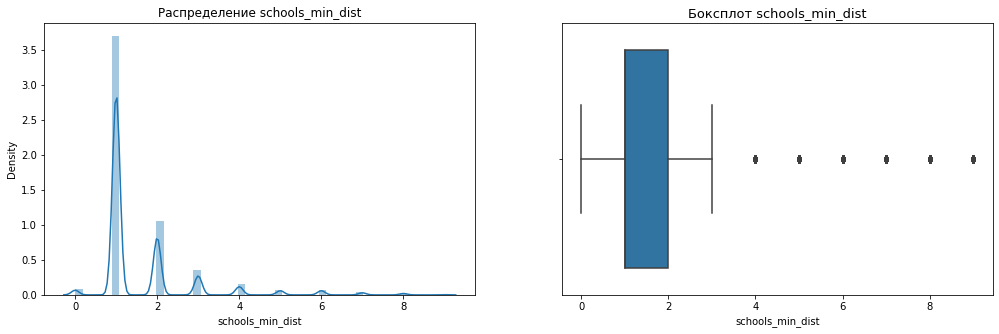

count    370186.000000
mean          1.583631
std           1.200102
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max           9.000000
Name: schools_min_dist, dtype: float64

In [59]:
plt.figure(figsize=(17, 5))
plt.subplot(1,2,1)
plt.title(f"Распределение {'schools_min_dist'}")
sns.distplot((data['schools_min_dist']), bins=50)

plt.subplot(1,2,2)
sns.boxplot(data['schools_min_dist'])
plt.xlabel('schools_min_dist')
plt.title(f"Боксплот {'schools_min_dist'}", fontsize=13)
plt.show()
data['schools_min_dist'].describe()

In [60]:
data = data[data['schools_min_dist']<8] 

Думаю в дальнейшем, если будет корреляция (а она будет), лучше оставить минимальное расстояние.

In [61]:
# schools_mean_dist

In [62]:
print('Кол-во уникальных значений schools_mean_dist = ',len(data['schools_mean_dist'].unique()))  # 'иникальные значения :' ,data['schools_mean_dist'].unique())
print('Пропущенных значений в schools_mean_dist = ', data['schools_mean_dist'].isna().sum())

display(data['schools_mean_dist'].value_counts(dropna=False))

Кол-во уникальных значений schools_mean_dist =  24014
Пропущенных значений в schools_mean_dist =  4180


NaN           4180
1.000000      2687
1.200000      2392
0.900000      2358
1.500000      2208
1.300000      2191
1.166667      1971
1.066667      1911
1.333333      1788
0.933333      1730
0.600000      1725
1.100000      1657
0.833333      1654
1.700000      1612
1.233333      1597
1.366667      1596
1.400000      1580
0.500000      1500
1.800000      1488
2.000000      1477
1.466667      1468
0.666667      1465
1.266667      1461
1.666667      1456
0.733333      1447
0.766667      1446
1.033333      1391
2.100000      1385
1.533333      1359
0.866667      1321
0.700000      1290
1.833333      1287
1.633333      1253
1.433333      1181
0.966667      1147
1.133333      1145
1.600000      1113
0.800000      1112
1.566667      1095
1.100000      1070
2.400000      1055
1.866667      1054
1.966667      1036
2.133333      1003
2.166667       999
0.533333       978
0.633333       976
2.500000       911
1.900000       906
2.033333       902
2.200000       849
0.966667       849
1.733333    

In [63]:
data['schools_mean_dist'] = data.schools_mean_dist.astype(float).round(1)
data['schools_mean_dist'] = data['schools_mean_dist'].fillna(0)

In [64]:
# поделим на группы

data.loc[(data['schools_mean_dist'] > 0) & (data['schools_mean_dist'] <= 1), 'schools_mean_dist'] = 1
data.loc[(data['schools_mean_dist'] > 1) & (data['schools_mean_dist'] <= 2), 'schools_mean_dist'] = 2
data.loc[(data['schools_mean_dist'] > 2) & (data['schools_mean_dist'] <= 3), 'schools_mean_dist'] = 3
data.loc[(data['schools_mean_dist'] > 3) & (data['schools_mean_dist'] <= 4), 'schools_mean_dist'] = 4
data.loc[(data['schools_mean_dist'] > 4) & (data['schools_mean_dist'] <= 5), 'schools_mean_dist'] = 5
data.loc[(data['schools_mean_dist'] > 5) & (data['schools_mean_dist'] <= 7), 'schools_mean_dist'] = 6
data.loc[(data['schools_mean_dist'] > 7) & (data['schools_mean_dist'] <= 10), 'schools_mean_dist'] = 7
data.loc[(data['schools_mean_dist'] > 10) & (data['schools_mean_dist'] < 25), 'schools_mean_dist'] = 8
data.loc[(data['schools_mean_dist'] >= 25), 'schools_mean_dist'] = 9
data.loc[(data['schools_mean_dist'] == 0), 'schools_mean_dist'] = 0

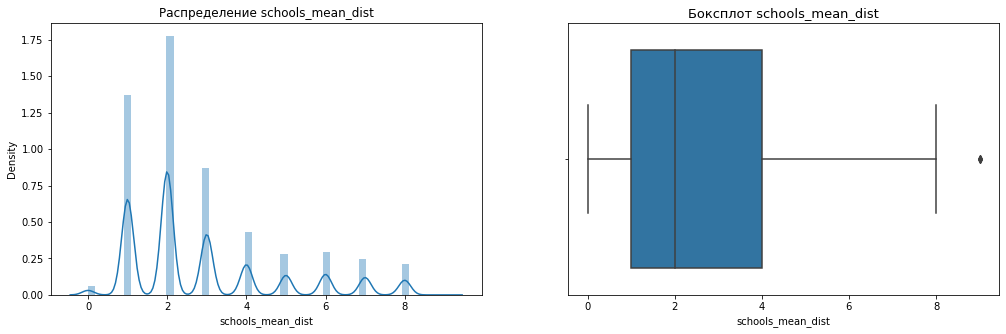

count    368211.000000
mean          2.858516
std           1.953948
min           0.000000
25%           1.000000
50%           2.000000
75%           4.000000
max           9.000000
Name: schools_mean_dist, dtype: float64

In [65]:
plt.figure(figsize=(17, 5))
plt.subplot(1,2,1)
plt.title(f"Распределение {'schools_mean_dist'}")
sns.distplot((data['schools_mean_dist']), bins=50)

plt.subplot(1,2,2)
sns.boxplot(data['schools_mean_dist'])
plt.xlabel('schools_mean_dist')
plt.title(f"Боксплот {'schools_mean_dist'}", fontsize=13)
plt.show()
data['schools_mean_dist'].describe()

In [66]:
# schools_max_dist

In [67]:
print('Кол-во уникальных значений schools_max_dist = ',len(data['schools_max_dist'].unique()))  # 'иникальные значения :' ,data['schools_max_dist'].unique())
print('Пропущенных значений в schools_max_dist = ', data['schools_max_dist'].isna().sum())

display(data['schools_max_dist'].value_counts(dropna=False))

Кол-во уникальных значений schools_max_dist =  3356
Пропущенных значений в schools_max_dist =  0


1.8       5501
1.4       5413
1.7       5355
1.6       5346
1.9       5300
1.5       5299
2.0       5266
1.3       5137
2.1       5058
2.2       5026
2.3       4750
2.4       4745
1.2       4641
1.1       4513
2.5       4345
2.6       4206
NoData    4180
1.0       4166
2.7       4013
2.8       3969
2.9       3810
0.9       3726
3.0       3653
3.1       3573
3.2       3271
0.8       3233
3.3       3164
3.4       2947
0.7       2832
3.5       2741
3.6       2700
3.7       2655
3.8       2419
3.9       2349
0.6       2324
4.0       2252
4.2       2056
4.1       1993
0.5       1934
4.3       1834
0.4       1826
4.4       1748
4.7       1718
4.5       1685
4.6       1681
4.8       1650
4.9       1557
0.3       1404
5.0       1362
5.1       1312
5.2       1204
5.3       1109
5.4       1096
5.6       1080
5.5       1000
6.3        964
5.7        947
5.8        925
6.5        917
6.0        869
6.6        866
5.9        850
6.4        825
6.7        808
6.9        773
6.8        772
6.1       

In [68]:
data.loc[data['schools_max_dist'] == 'NoData', 'schools_max_dist'] = 0
data['schools_max_dist'] = data.schools_max_dist.astype(float).round(1)
data['schools_max_dist'] = data['schools_max_dist'].fillna(0)

In [69]:
# поделим на группы

data.loc[(data['schools_max_dist'] > 0) & (data['schools_max_dist'] <= 1), 'schools_max_dist'] = 1
data.loc[(data['schools_max_dist'] > 1) & (data['schools_max_dist'] <= 2), 'schools_max_dist'] = 2
data.loc[(data['schools_max_dist'] > 2) & (data['schools_max_dist'] <= 3), 'schools_max_dist'] = 3
data.loc[(data['schools_max_dist'] > 3) & (data['schools_max_dist'] <= 4), 'schools_max_dist'] = 4
data.loc[(data['schools_max_dist'] > 4) & (data['schools_max_dist'] <= 5), 'schools_max_dist'] = 5
data.loc[(data['schools_max_dist'] > 5) & (data['schools_max_dist'] <= 6), 'schools_max_dist'] = 6
data.loc[(data['schools_max_dist'] > 6) & (data['schools_max_dist'] <= 7), 'schools_max_dist'] = 7
data.loc[(data['schools_max_dist'] > 7) & (data['schools_max_dist'] <= 8), 'schools_max_dist'] = 8
data.loc[(data['schools_max_dist'] > 8) & (data['schools_max_dist'] <= 9), 'schools_max_dist'] = 9
data.loc[(data['schools_max_dist'] > 9) & (data['schools_max_dist'] <= 10), 'schools_max_dist'] = 10
data.loc[(data['schools_max_dist'] > 10) & (data['schools_max_dist'] <= 12), 'schools_max_dist'] = 11
data.loc[(data['schools_max_dist'] > 12), 'schools_max_dist'] = 12
data.loc[(data['schools_max_dist'] == 0), 'schools_max_dist'] = 0

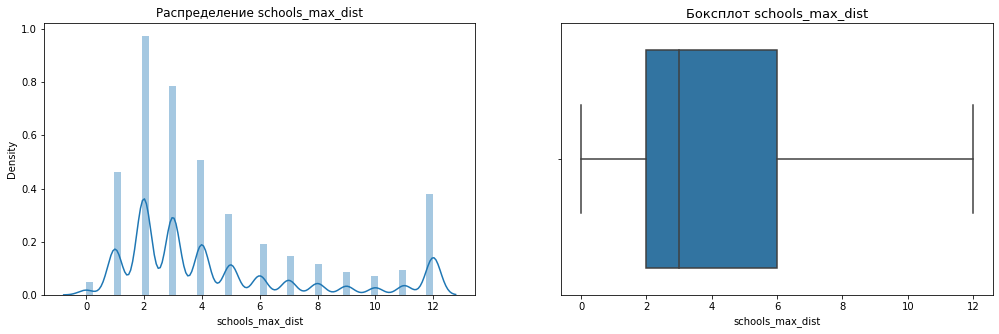

count    368211.000000
mean          4.438474
std           3.344088
min           0.000000
25%           2.000000
50%           3.000000
75%           6.000000
max          12.000000
Name: schools_max_dist, dtype: float64

In [70]:
plt.figure(figsize=(17, 5))
plt.subplot(1,2,1)
plt.title(f"Распределение {'schools_max_dist'}")
sns.distplot((data['schools_max_dist']), bins=50)

plt.subplot(1,2,2)
sns.boxplot(data['schools_max_dist'])
plt.xlabel('schools_max_dist')
plt.title(f"Боксплот {'schools_max_dist'}", fontsize=13)
plt.show()
data['schools_max_dist'].describe()

### Новый признак количество школ рядом (schools_count)

In [71]:
print('Кол-во уникальных значений schools_count = ',len(data['schools_count'].unique()))  # 'иникальные значения :' ,data['schools_count'].unique())
print('Пропущенных значений в schools_count = ', data['schools_count'].isna().sum())

display(data['schools_count'].value_counts(dropna=False))

Кол-во уникальных значений schools_count =  27
Пропущенных значений в schools_count =  0


3     203258
8      40080
2      34256
5      28298
4      22643
6      11263
1       8277
7       6311
0       4180
24      2062
22      1782
10       769
63       764
13       753
11       746
12       615
9        531
14       378
65       353
49       278
15       267
61       128
16       113
21        86
26        10
17         9
19         1
Name: schools_count, dtype: int64

In [72]:
data = data[data['schools_count']<= 10] 

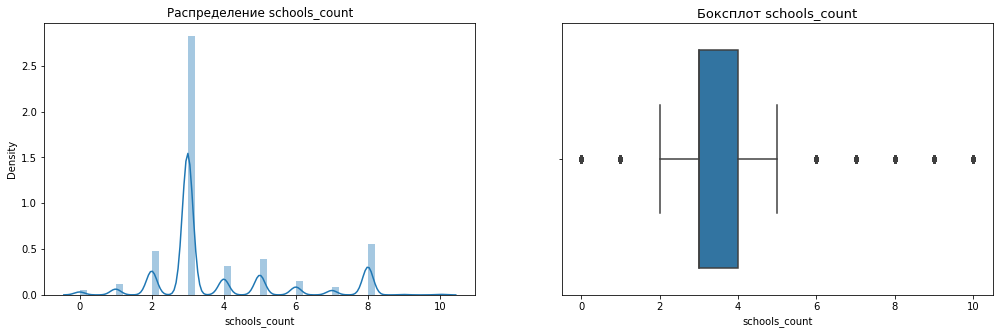

count    359866.00000
mean          3.78888
std           1.88450
min           0.00000
25%           3.00000
50%           3.00000
75%           4.00000
max          10.00000
Name: schools_count, dtype: float64

In [73]:
plt.figure(figsize=(17, 5))
plt.subplot(1,2,1)
plt.title(f"Распределение {'schools_count'}")
sns.distplot((data['schools_count']), bins=50)

plt.subplot(1,2,2)
sns.boxplot(data['schools_count'])
plt.xlabel('schools_count')
plt.title(f"Боксплот {'schools_count'}", fontsize=13)
plt.show()
data['schools_count'].describe()

### Новые признаки рейтинг школ минимальный, средний, максимальный  schools_min_rating	schools_max_rating	schools_mean_rating

In [74]:
# schools_min_rating

In [75]:
print('Кол-во уникальных значений schools_min_rating = ',len(data['schools_min_rating'].unique()))  # 'иникальные значения :' ,data['schools_min_rating'].unique())
print('Пропущенных значений в schools_min_rating = ', data['schools_min_rating'].isna().sum())

display(data['schools_min_rating'].value_counts(dropna=False))

Кол-во уникальных значений schools_min_rating =  11
Пропущенных значений в schools_min_rating =  0


2.000000     76729
3.000000     69097
4.000000     50997
5.000000     46549
1.000000     42204
6.000000     28423
7.000000     18574
8.000000     14705
9.000000      6967
5.159987      4986
10.000000      635
Name: schools_min_rating, dtype: int64

In [76]:
data['schools_min_rating'] = data.schools_min_rating.astype(int)
data['schools_min_rating'] = data['schools_min_rating'].fillna(0)

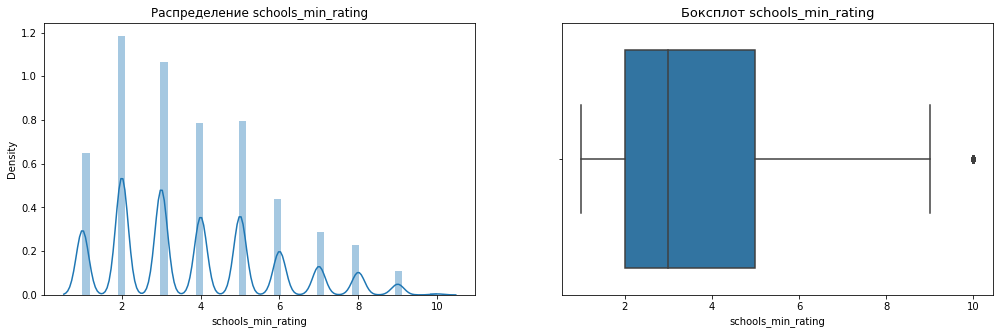

count    359866.000000
mean          3.756579
std           2.041103
min           1.000000
25%           2.000000
50%           3.000000
75%           5.000000
max          10.000000
Name: schools_min_rating, dtype: float64

In [77]:
plt.figure(figsize=(17, 5))
plt.subplot(1,2,1)
plt.title(f"Распределение {'schools_min_rating'}")
sns.distplot((data['schools_min_rating']), bins=50)

plt.subplot(1,2,2)
sns.boxplot(data['schools_min_rating'])
plt.xlabel('schools_min_rating')
plt.title(f"Боксплот {'schools_min_rating'}", fontsize=13)
plt.show()
data['schools_min_rating'].describe()

In [78]:
# schools_max_rating

In [79]:
print('Кол-во уникальных значений schools_max_rating = ',len(data['schools_max_rating'].unique()))  # 'иникальные значения :' ,data['schools_max_rating'].unique())
print('Пропущенных значений в schools_max_rating = ', data['schools_max_rating'].isna().sum())

display(data['schools_max_rating'].value_counts(dropna=False))

Кол-во уникальных значений schools_max_rating =  11
Пропущенных значений в schools_max_rating =  0


7.000000     59276
10.000000    56885
6.000000     49188
8.000000     43494
4.000000     37839
9.000000     37712
5.000000     35234
3.000000     24647
2.000000      8425
5.159987      4986
1.000000      2180
Name: schools_max_rating, dtype: int64

In [80]:
data['schools_max_rating'] = data.schools_max_rating.astype(float).round(0)
data['schools_max_rating'] = data['schools_max_rating'].fillna(0)

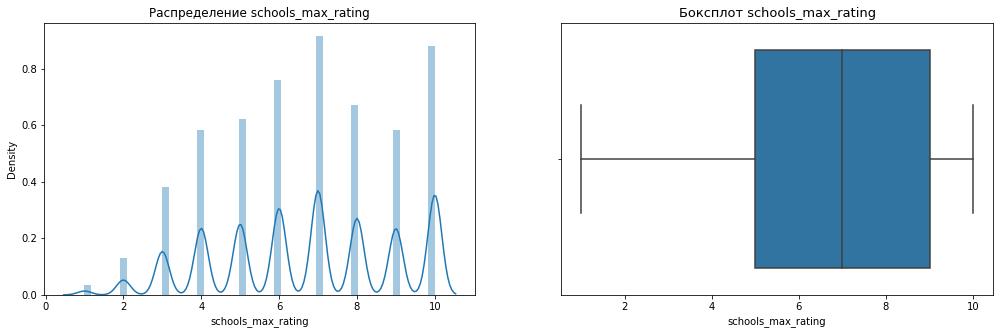

count    359866.000000
mean          6.701653
std           2.302816
min           1.000000
25%           5.000000
50%           7.000000
75%           9.000000
max          10.000000
Name: schools_max_rating, dtype: float64

In [81]:
plt.figure(figsize=(17, 5))
plt.subplot(1,2,1)
plt.title(f"Распределение {'schools_max_rating'}")
sns.distplot((data['schools_max_rating']), bins=50)

plt.subplot(1,2,2)
sns.boxplot(data['schools_max_rating'])
plt.xlabel('schools_max_rating')
plt.title(f"Боксплот {'schools_max_rating'}", fontsize=13)
plt.show()
data['schools_max_rating'].describe()

In [82]:
# schools_mean_rating

In [83]:
print('Кол-во уникальных значений schools_mean_rating = ',len(data['schools_mean_rating'].unique()))  # 'иникальные значения :' ,data['schools_mean_rating'].unique())
print('Пропущенных значений в schools_mean_rating = ', data['schools_mean_rating'].isna().sum())

display(data['schools_mean_rating'].value_counts(dropna=False))

Кол-во уникальных значений schools_mean_rating =  195
Пропущенных значений в schools_mean_rating =  0


6.000000     22544
4.000000     19605
5.000000     19116
3.000000     17113
6.333333     15352
3.333333     14080
7.000000     13469
4.666667     12712
5.666667     12147
5.333333     12105
4.333333     12047
3.666667     11856
8.000000     10874
2.666667     10050
2.000000      9881
6.666667      8214
2.333333      8063
7.333333      7574
7.666667      6542
7.500000      6478
4.500000      5874
5.500000      5763
9.000000      5660
6.500000      5306
5.159987      4986
3.500000      4206
8.666667      4146
2.500000      3728
8.333333      3604
9.333333      2628
1.666667      2586
6.750000      2303
4.250000      2190
1.000000      2180
7.250000      2071
1.500000      1925
6.250000      1862
4.750000      1776
5.600000      1763
5.400000      1634
8.500000      1496
5.750000      1474
5.200000      1472
5.250000      1374
9.666667      1362
4.200000      1281
3.833333      1266
4.600000      1127
1.333333      1078
3.750000      1041
4.166667      1012
4.400000       962
6.166667    

In [84]:
data['schools_mean_rating'] = data.schools_mean_rating.astype(int)
data['schools_mean_rating'] = data['schools_mean_rating'].fillna(0)

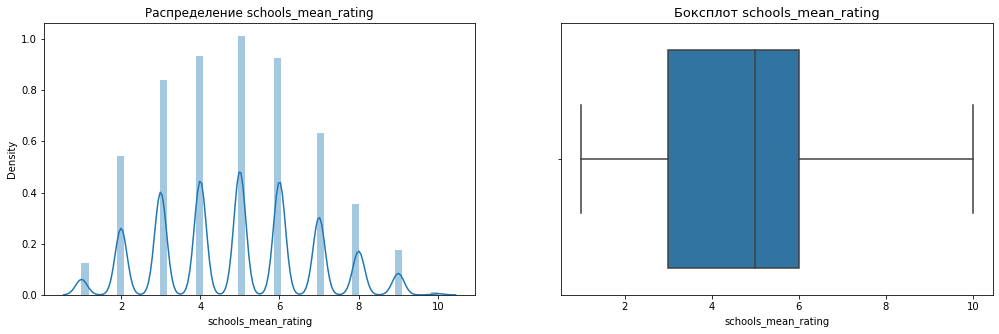

count    359866.000000
mean          4.867751
std           1.935697
min           1.000000
25%           3.000000
50%           5.000000
75%           6.000000
max          10.000000
Name: schools_mean_rating, dtype: float64

In [85]:
plt.figure(figsize=(17, 5))
plt.subplot(1,2,1)
plt.title(f"Распределение {'schools_mean_rating'}")
sns.distplot((data['schools_mean_rating']), bins=50)

plt.subplot(1,2,2)
sns.boxplot(data['schools_mean_rating'])
plt.xlabel('schools_mean_rating')
plt.title(f"Боксплот {'schools_mean_rating'}", fontsize=13)
plt.show()
data['schools_mean_rating'].describe()

### Признак бассейн ( private pool ) и видимо дублирующий его признак ( PrivatePool	)

In [86]:
print('Кол-во уникальных значений private pool = ',len(data['private pool'].unique()), 'иникальные значения :' ,data['private pool'].unique())

print('Кол-во уникальных значений PrivatePool = ',len(data['PrivatePool'].unique()), 'иникальные значения :' ,data['PrivatePool'].unique())

Кол-во уникальных значений private pool =  2 иникальные значения : [nan 'Yes']
Кол-во уникальных значений PrivatePool =  3 иникальные значения : [nan 'yes' 'Yes']


In [87]:
print('Пропущенных значений в private pool = ', data['private pool'].isna().sum())
print('Пропущенных значений в PrivatePool = ', data['PrivatePool'].isna().sum())

Пропущенных значений в private pool =  355845
Пропущенных значений в PrivatePool =  322364


In [88]:
# Проверим есть ли значения в строках PrivatePool, если их нет в private pool
data.loc[(data['private pool'] == 'Yes') | (data['PrivatePool'] == 'yes') | (data['PrivatePool'] == 'Yes'), ['private pool', 'PrivatePool']].sample(10)

private pool PrivatePool
257043          NaN         Yes
93070           NaN         yes
12373           NaN         yes
349260          NaN         yes
151547          NaN         yes
92692           Yes         NaN
331396          NaN         Yes
219276          NaN         yes
146912          NaN         yes
141232          NaN         Yes

Эти признаки обозначают одно и то же , оэтому оставим только один но совместив данные обоих признаков


In [89]:
data.loc[data['private pool'] == 'Yes', 'PrivatePool'] = 'Yes'
data = data.drop(['private pool'], axis = 1)
# заменим значение yes на 1 и пустое на 0
data['PrivatePool'] = data['PrivatePool'].apply(lambda x: 1 if (x=='Yes' or x=='yes') else 0)
data['PrivatePool'].value_counts()

0    318343
1     41523
Name: PrivatePool, dtype: int64

<AxesSubplot:xlabel='PrivatePool', ylabel='count'>

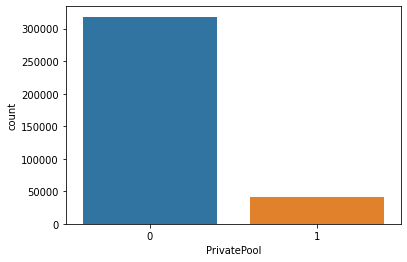

In [90]:
sns.countplot(x = 'PrivatePool', data = data)

### Признак тип недвижимости ( propertyType )

In [91]:
print('Кол-во уникальных значений propertyType = ',len(data['propertyType'].unique()), 'уникальные значения :' ,data['propertyType'].unique())

Кол-во уникальных значений propertyType =  1273 уникальные значения : ['Single Family Home' 'single-family home' 'lot/land' ...
 'Cabin/Lodge, Contemporary, Converted Barn, Cottage, Loft with Bedrooms, Log Home, Post & Beam'
 'Lake House, Single Detached, Tudor'
 'Bilevel, Converted Dwelling, Loft with Bedrooms, Condo/Unit']


In [92]:
print('Пропущенных значений в private pool = ', data['propertyType'].isna().sum())

Пропущенных значений в private pool =  33797


In [93]:
data['propertyType'].value_counts()[:100]

single-family home                            84683
Single Family                                 60892
Single Family Home                            31580
condo                                         24661
lot/land                                      17836
Condo                                         16205
townhouse                                     11127
Land                                          10715
Condo/Townhome/Row Home/Co-Op                  7689
multi-family                                   7077
Townhouse                                      6844
Traditional                                    5885
coop                                           3138
Multi Family                                   2688
High Rise                                      1805
Ranch                                          1776
Detached, One Story                            1612
Single Detached, Traditional                   1580
mobile/manufactured                            1570
Contemporary

как видим очень много уникальных значений, но если разобраться, то некоторое значения являются разной записью одного и того же.

В США есть несколько основных видов недвижимости:

-   1) **Single-family** house (дом на одну семью). Как правило, это одно- или двухэтажные дома, которые имеют одну кухню, гостиную, семейную комнату и несколько спален, плюс две ванных комнаты. Такой дом, в подавляющем большинстве, имеет пристроенный или отдельный гараж. 
-   2) **Duplex house** - здание, которое имеет два дома, разделенных общей стеной. 
-   3) **Multi-unit house** - дом, который имеет несколько квартир, но одного владельца. Каждая квартира состоит из кухни, спальни, ванной, а также имеет свое отдельное отопление и электроснабжение. 

-   4) **Townhouse** (городской дом). Так же, как и в доме, владелец владеет зданием и землей, на которой она стоит, но земля есть лимитированной. Town houses соединены между собой в ряд и, как правило, есть 2- этажные. Владелец владеет только небольшой территорией земли.

-   5) **Condominium** (квартира). Как и town house, Condo соединены между собой. Если вы являетесь владельцем Condo, тогда вы не владеете никакой землей вокруг Condo. Владелец владеет только самой квартирой, а также определенным процентом общей территории (коридор, лифт и т.д.).

-   6) **Cooperative** (кооператив).  Основное различие между кооперативным домом и просто многоэтажкой состоит в форме собственности. Если вы являетесь владельцем кооператива, то вы владеете не частичкой здания, а долей (акциями) в корпорации. Эта доля дает вам право жить в квартире, но не владеть ею. По этой причине корпорация платит налоги за весь дом, а вы платите корпорации. Поэтому, если кто-то из владельцев кооператива не способен заплатить, тогда все другие должны вместо него уплатить эти средства.

-   7) **Mobile home** (передвижной дом).  Чертой Mobile home есть то, что он мобильный. Покупка Mobile home подобная приобретению автомобиля - платишь, налог и получаешь свидетельство о праве собственности. Mobile home, в отличие от всех других видов жилья, со временем теряет стоимость, как и автомобиль. Если вы используете ваш Mobile home на дороге, то с точки зрения закона - это автомобиль. Но, если вы припаркованы на специальной стоянке, тогда ваш Mobile home превращается в дом.

Еще выделим такие группы:
- 8) land - земельный участок;
- 9) ranch - ранчо или (FARM) ферма;
- 10) bungalow - бунгало;
- 12) apartment -квартира;
- 13) 1 STORY - 1-ЭТАЖНЫЙ;         
- 14) 2 STORY - 2-ЭТАЖНЫЙ;          
- 15) MULTI-LEVEL  - МНОГОУРОВНЕВЫЙ;        
- 16) COTTAGE  - КОТТЕДЖ;          
- 17) DETACHED - ОТДЕЛЬНОСТОЯЩИЙ;
- 18) other - разное другое


In [94]:
data['propertyType'] = data['propertyType'].str.upper()
def clear_property_type(s):
    try:
        if 'SINGLE' in s or 'TRADITIONAL' in s or 'ONE STOR' in s or '1 STOR' in s: 
            return 'SINGLE-HOUSE'
        elif 'FLAT' in s or 'APARTMENT' in s or 'PENT' in s: 
            return 'APARTMENT'
        elif 'TOWNH' in s: 
            return 'TOWNHOUSE'
        elif 'DUPL' in s: 
            return 'DUPLEX' 
        elif 'CONDO' in s: 
            return 'CONDOMINIUM'        
        elif 'LAND' in s: 
            return 'LAND'
        elif 'MULTI' in s or 'COOP' in s or 'CO-OP' in s: 
            return 'MULTI-HOUSE'
        elif 'MOBI' in s or 'CARRI' in s: 
            return 'MOBILE-HOUSE'
        elif 'TWO STOR' in s or '2 STOR' in s: 
            return '2-STORY'
        elif 'DETA' in s or 'DETA' in s or 'COTT' in s or 'RESID' in s or 'COURT' in s: 
            return 'DETACHED'
        elif 'FARM' in s or 'RAN' in s: 
            return 'RANCH'
        elif 'LEVEL' in s: 
            return 'MULTI-LEVEL'        
        elif s == 'nan' or s == '': 
            return 'NO DATA'
        elif 'OTHER' in s or 'BUNGAL' in s or 'NO DATA' in s: 
            return 'OTHER'    
        else:
            return 'OTHER'

    except:
         return 'OTHER'

In [95]:
data['propertyType'] = [clear_property_type(x) for x in data['propertyType']]
data = data[data['propertyType']!='LAND']
data['propertyType'].value_counts()

SINGLE-HOUSE    192705
OTHER            44474
CONDOMINIUM      41037
TOWNHOUSE        26350
MULTI-HOUSE      15217
RANCH             3655
MOBILE-HOUSE      3447
2-STORY           2599
APARTMENT          902
MULTI-LEVEL        435
DETACHED           361
DUPLEX             125
Name: propertyType, dtype: int64

In [96]:
data['propertyType'] = data['propertyType'].astype(str)

In [97]:
data.propertyType.value_counts(normalize=True)

SINGLE-HOUSE    0.581651
OTHER           0.134238
CONDOMINIUM     0.123864
TOWNHOUSE       0.079533
MULTI-HOUSE     0.045930
RANCH           0.011032
MOBILE-HOUSE    0.010404
2-STORY         0.007845
APARTMENT       0.002723
MULTI-LEVEL     0.001313
DETACHED        0.001090
DUPLEX          0.000377
Name: propertyType, dtype: float64

### Признак город ( city )

In [98]:
print('Пропуски:', data.city.isna().sum())
print('Уникальных:', data.city.nunique())

Пропуски: 9
Уникальных: 1878


Всего 34 пропусков. Их можно удалить.

In [99]:
data = data.dropna(subset=['city'])

In [100]:
data['city'].value_counts()[:100]

Houston              23215
Miami                15122
San Antonio          14821
Jacksonville          9461
Dallas                8380
Brooklyn              7055
Chicago               6313
Charlotte             6074
New York              5806
Las Vegas             5579
Fort Worth            5223
Fort Lauderdale       4935
Orlando               4907
Austin                4898
Tampa                 4532
Nashville             4525
Washington            4474
Philadelphia          4167
Seattle               3781
Atlanta               3607
Los Angeles           3602
Cleveland             3132
Kissimmee             2845
Saint Petersburg      2422
Ocala                 2410
Raleigh               2371
Miami Beach           2362
Memphis               2351
Indianapolis          2311
Denver                2126
Portland              1916
ORLANDO               1803
Palm Coast            1752
Durham                1738
Chattanooga           1731
TAMPA                 1714
San Diego             1681
E

In [101]:
# чтобы избежать написания в разых регистрах, приведем к верхнему всё
data.city = data.city.str.upper()

In [102]:
# есть еще значение " " , уберем их тоже т.к. их всего 20
len(data[data['city']==' '])

19

In [103]:
data = data.loc[data['city'] != ' ']

In [104]:
top_city = data['city'].value_counts()[:200].index
data['city'] = data['city'].apply(lambda r: r if r in top_city else 'OTHER')

### признак статус объявления ( status )

In [105]:
print('Пропуски:', data.status.isna().sum())
print('Уникальных:', data.status.nunique())

Пропуски: 38846
Уникальных: 152


In [106]:
# Посмотрим на значения, но сперва приведем все к одному регистру
data['status'] = data['status'].str.upper()
data['status'] = data['status'].astype(str)
data['status'].value_counts()[:100]

FOR SALE                                  170398
ACTIVE                                     93983
nan                                        38846
NEW CONSTRUCTION                            5395
FORECLOSURE                                 4810
PENDING                                     4309
PRE-FORECLOSURE                             1977
P                                           1461
PRE-FORECLOSURE / AUCTION                   1277
UNDER CONTRACT SHOW                         1068
 / AUCTION                                   790
UNDER CONTRACT   SHOWING                     748
ACTIVE UNDER CONTRACT                        713
NEW                                          671
UNDER CONTRACT                               664
CONTINGENT                                   567
PRICE CHANGE                                 557
AUCTION                                      493
A ACTIVE                                     373
FORECLOSED                                   289
UNDER CONTRACT BACKU

In [107]:
def clear_status(s):
    try:
        if 'AUCT' in s: 
            return 'AUCTION'
        elif 'ACTIV' in s: 
            return 'ACTIVE'
        elif 'SALE' in s: 
            return 'FOR SALE'
        elif 'NEW' in s: 
            return 'NEW'
        elif 'CONTRA' in s: 
            return 'CONTRACT'
        elif 'FORECL' in s: 
            return 'FORECLOSURE'
        elif 'RENT' in s or 'LEASE' in s: 
            return 'RENT'
        elif 'PENDIN' in s: 
            return 'PENDING'
        elif 'CONTING' in s: 
            return 'CONTINGENT'
        elif 'CLOSED' in s: 
            return 'CLOSED'
        elif 'COMIN' in s: 
            return 'COMING SOON'
        else:
            return 'OTHER'
    except:
        return "NO_DATA"

In [108]:
data['status'] = [clear_status(x) for x in data['status']]
data['status'].value_counts()

FOR SALE       170457
ACTIVE          95212
OTHER           41136
FORECLOSURE      7078
NEW              6066
PENDING          4792
CONTRACT         2853
AUCTION          2598
CONTINGENT        956
COMING SOON       109
RENT               17
CLOSED              5
Name: status, dtype: int64

In [109]:
data.status.value_counts(normalize=True)

FOR SALE       0.514542
ACTIVE         0.287407
OTHER          0.124173
FORECLOSURE    0.021366
NEW            0.018311
PENDING        0.014465
CONTRACT       0.008612
AUCTION        0.007842
CONTINGENT     0.002886
COMING SOON    0.000329
RENT           0.000051
CLOSED         0.000015
Name: status, dtype: float64

в итоге после преобразований получили 12 уникальных значений в признаке СТАТУС.

### Признак почтовый индекс ( zipcode )

In [110]:
print('Пропуски:', data.zipcode.isna().sum())
print('Уникальных:', data.zipcode.nunique())

Пропуски: 0
Уникальных: 4445


пропусков в признаке нет.


In [111]:
data['zipcode'].value_counts()

33131         1546
78245         1378
34747         1329
33132         1299
33137         1275
78253         1270
78254         1223
33130         1161
32137         1131
34746         1089
33160         1042
33308         1008
33133         1001
33178         1000
33141          952
33304          936
33319          915
34759          900
77008          882
33140          850
77007          847
33301          842
32259          807
32218          801
33154          792
77845          767
32256          756
77024          749
33647          748
33180          730
33139          724
33311          684
33179          678
77057          657
77055          644
32210          636
77018          631
77009          630
33312          628
33156          625
32164          621
33019          621
33129          609
77004          608
78209          608
28278          605
33313          597
33134          582
28078          572
37209          572
33321          561
28205          561
77056       

In [112]:
# Приведем все значения к 5-значному формату

data['zipcode'] = data['zipcode'].str.replace('\-[0-9]*', '').apply(lambda x: None if x is None else
                                                                None if x == '' else
                                                                ('0000' + str(x))[-5:])

In [113]:
print('Пропуски:', data.zipcode.isna().sum())
print('Уникальных:', data.zipcode.nunique())

Пропуски: 1
Уникальных: 4165


In [114]:
data.dropna(subset = ['zipcode'], inplace=True)

### Признак этажность ( stories )

In [115]:
print('Пропуски:', data.stories.isna().sum())
print('Уникальных:', data.stories.nunique())

Пропуски: 117566
Уникальных: 334


очень много пропусков в признаке.


In [116]:
data['stories'].value_counts()

1.0                                           61639
2.0                                           51965
1                                             22377
2                                             17484
3.0                                           10687
0.0                                            7095
One                                            5726
0                                              4167
3                                              4095
9.0                                            2869
2.00                                           2771
Two                                            2482
4.0                                            2032
2 Story                                        1970
1 Story                                        1253
1.00                                           1198
4                                               879
3+                                              864
6.0                                             684
1.50        

In [117]:
data.stories = data.stories.str.lower()    

In [118]:
def clear_stories(x):
    try:
        if isinstance(x, int) or isinstance(x, float):
            x = str(x)
        if 'one' in x or '1' in x or 'apartment' in x:
            return 1
        if 'two' in x or 'townhouse' in x or '2' in x or 'bi' in x:
            return 2
        if 'three' in x or '3' in x or 'tri' in x:
            return 3
        if 'four' in x or '4' in x or 'quad' in x or 'multi' in x or '5' in x:
            return 4
        else:
            return 0
    except:
        return 0

In [119]:
data['stories'] = [clear_stories(x) for x in data['stories']]

In [120]:
print('Пропуски:', data.stories.isna().sum())
print('Уникальных:', data.stories.nunique())
data['stories'].value_counts()

Пропуски: 0
Уникальных: 5


0    134785
1     95973
2     78970
3     17311
4      4239
Name: stories, dtype: int64

### Признаки MlsId и  mls-id

In [121]:
print('Пропуски:', data['mls-id'].isna().sum())
print('Уникальных:', data['mls-id'].nunique())

Пропуски: 306750
Уникальных: 24493


In [122]:
data['mls-id'].value_counts()[:100]

No MLS#        3
No             3
617190         2
1020414        2
19079093       2
2152042        2
1530716        2
20193733       2
19-5523        2
608063         2
39888954       2
19-3683        2
19-5064        2
983469         2
241766         2
1020766        2
201906177      2
DW19268386     2
19010197       2
190004138      2
19-3389        2
A10761504      2
898065         2
241962         2
1498550        2
20193103       2
20196126       2
DCDC451020     2
233481         2
74184012       2
A10518254      2
201909981      2
201909859      2
3270129        1
10113423       1
A10661230      1
75660522       1
A10770673      1
ML81773443     1
19044735       1
A4452542       1
DCDC446918     1
2843156        1
819004571      1
PA1210345      1
10505009       1
14105998       1
201807697      1
72545994       1
183405         1
SR19174035     1
A10767509      1
10639547       1
148017         1
6053776        1
317748         1
201922499      1
H10763227      1
T3196330      

In [123]:
print('Пропуски:', data.MlsId.isna().sum())
print('Уникальных:', data.MlsId.nunique())

Пропуски: 62074
Уникальных: 201492


In [124]:
data['MlsId'].value_counts()[:100]

NO MLS                        23
No MLS #                      14
 A, Houston, TX 77008         13
 12A, Orlando, FL 32833       11
No                             9
 1, South Boston, MA 02127     9
 B, Houston, TX 77008          9
No mls                         8
 2, Washington, DC 20002       8
 B, Houston, TX 77007          8
 11A, Orlando, FL 32833        8
 1, Washington, DC 20002       7
 2, Washington, DC 20010       7
 2, Washington, DC 20001       6
 1, Washington, DC 20010       6
2101941                        6
 1A, Orlando, FL 32833         6
 2, Boston, MA 02129           6
 A, Austin, TX 78704           6
 2, Washington, DC 20009       6
2088662                        6
 3A, Orlando, FL 32833         6
 1, Washington, DC 20001       6
 A, Austin, TX 78721           6
 0, Doral, FL 33178            6
 A, Austin, TX 78702           5
No MLS                         5
10271270                       5
 A, Houston, TX 77057          5
1301877                        5
 1, Washin

эти 2 признака не несут информации для нашей модели. Удалим их.

In [125]:
data.drop(['MlsId','mls-id'],axis=1, inplace=True)

### Принак площади в кв.фут ( sqft )

In [126]:
print('Пропуски:', data['sqft'].isna().sum())
print('Уникальных:', data['sqft'].nunique())

Пропуски: 22717
Уникальных: 24012


In [127]:
data['sqft'] = data['sqft'].str.lower()

In [128]:
display(data.sqft.value_counts(dropna=False))

NaN                                          22717
0                                              916
1,200 sqft                                     750
1,000 sqft                                     602
1,100 sqft                                     537
1,800 sqft                                     527
--                                             508
1,500 sqft                                     507
2,000 sqft                                     487
1,400 sqft                                     485
1,600 sqft                                     426
800 sqft                                       421
900 sqft                                       373
1,300 sqft                                     373
1,200                                          356
2,400 sqft                                     346
1,440 sqft                                     342
2,200 sqft                                     334
3,000 sqft                                     324
960 sqft                       

In [129]:
data['sqft'] = data.sqft.str.replace('-- sqft', '0').str.replace('--', '0')
data['sqft'] = data.sqft.str.replace('total interior livable area: ', '')   #
data['sqft'] = data.sqft.str.replace(' sqft', '')
data['sqft'] = data.sqft.str.replace(',', '').str.replace('610-840', '725')

In [130]:
data.sqft = data.sqft.astype(float)

In [131]:
#заполнение отсутствующих значений 
data['sqft']=data['sqft'].fillna(round(data['sqft'].mean(), 1)) 

In [132]:
display(data.sqft.value_counts(dropna=False))

4204.7         22717
0.0             1686
1200.0          1330
1500.0           972
1000.0           970
1800.0           946
1100.0           901
1400.0           884
2000.0           831
1600.0           803
800.0            719
1300.0           695
1440.0           695
900.0            664
960.0            652
2400.0           651
2200.0           580
1700.0           580
1344.0           569
2100.0           561
1152.0           552
1120.0           551
1250.0           538
3000.0           522
1248.0           486
2500.0           476
1080.0           475
850.0            472
1056.0           464
1320.0           461
1650.0           459
1350.0           454
1260.0           446
1900.0           445
1050.0           429
750.0            427
1680.0           421
950.0            419
1450.0           417
1296.0           409
700.0            408
2300.0           400
1280.0           395
1008.0           389
1040.0           388
1560.0           376
1140.0           365
1750.0       

In [133]:
data['sqft_log'] = np.log(1 + (data.sqft)) 

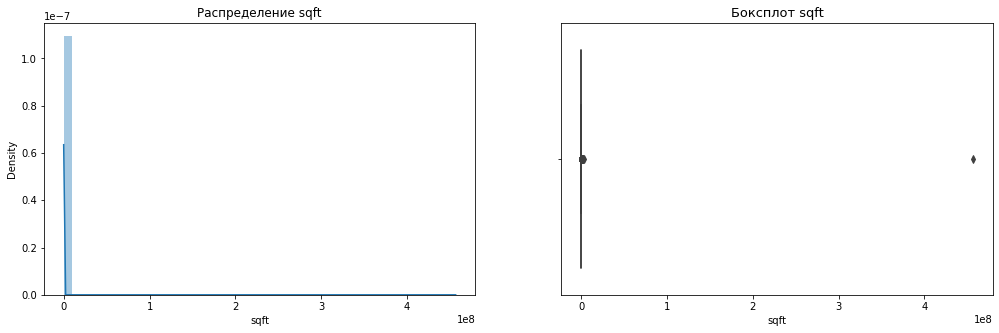

count    3.312780e+05
mean     4.204695e+03
std      7.934364e+05
min      0.000000e+00
25%      1.331000e+03
50%      1.925000e+03
75%      2.884000e+03
max      4.566025e+08
Name: sqft, dtype: float64


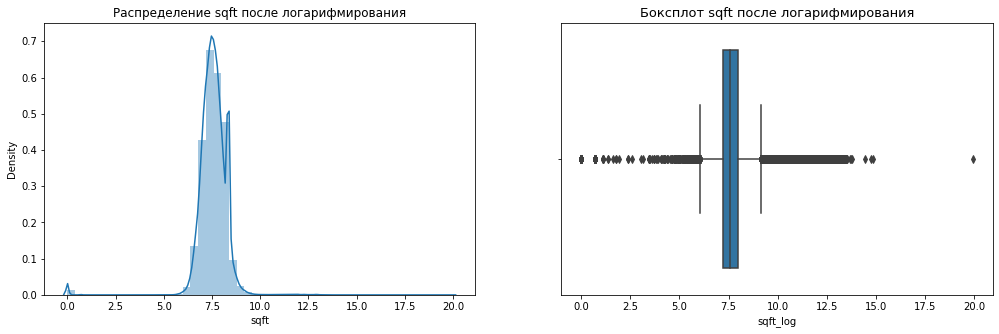

count    331278.000000
mean          7.559135
std           0.811376
min           0.000000
25%           7.194437
50%           7.563201
75%           7.967280
max          19.939324
Name: sqft_log, dtype: float64


In [134]:
plt.figure(figsize=(17, 5))
plt.subplot(1,2,1)
plt.title(f"Распределение {'sqft'}")
sns.distplot((data['sqft']), bins=50)

plt.subplot(1,2,2)
sns.boxplot(data['sqft'])
plt.xlabel('sqft')
plt.title(f"Боксплот {'sqft'}", fontsize=13)
plt.show()
print(data['sqft'].describe())

plt.figure(figsize=(17, 5))
plt.subplot(1,2,1)
plt.title(f"Распределение {'sqft'} после логарифмирования")
sns.distplot((np.log(1 + (data.sqft))), bins=50)

plt.subplot(1,2,2)
sns.boxplot(data.sqft_log)
plt.xlabel('sqft_log')
plt.title('Боксплот sqft после логарифмирования', fontsize=13)
plt.show()
print((data.sqft_log).describe())

In [135]:
data = data.loc[data['sqft']<100000]
# значения
data = data.loc[data['sqft_log']<15]

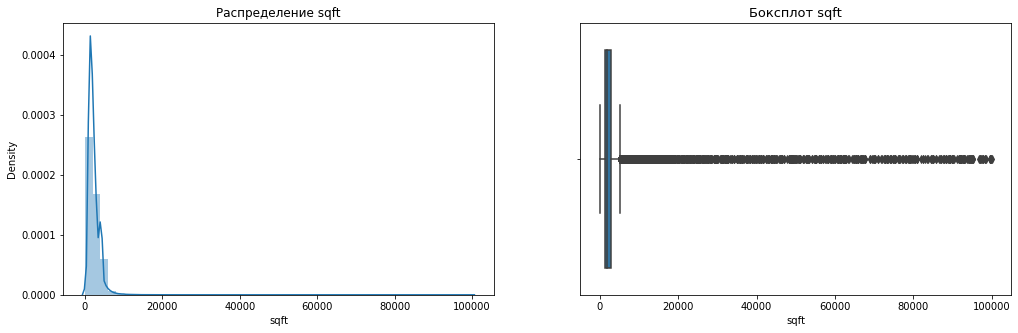

count    330685.000000
mean       2362.475123
std        2628.873664
min           0.000000
25%        1330.000000
50%        1922.000000
75%        2876.000000
max       99999.000000
Name: sqft, dtype: float64


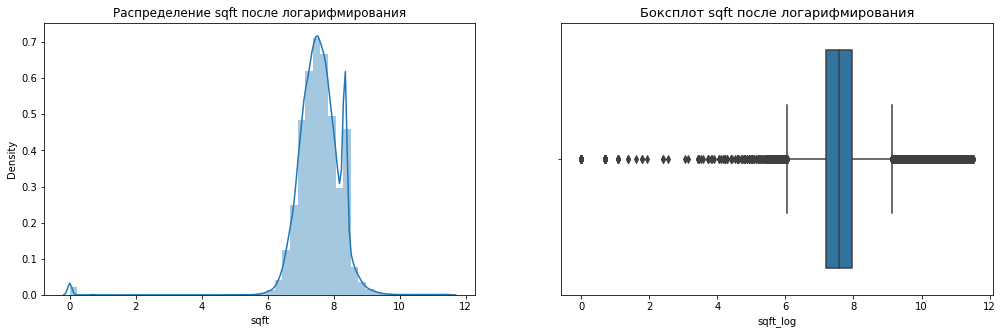

In [136]:
plt.figure(figsize=(17, 5))
plt.subplot(1,2,1)
plt.title(f"Распределение {'sqft'}")
sns.distplot((data['sqft']), bins=50)

plt.subplot(1,2,2)
sns.boxplot(data['sqft'])
plt.xlabel('sqft')
plt.title(f"Боксплот {'sqft'}", fontsize=13)
plt.show()
print(data['sqft'].describe())

plt.figure(figsize=(17, 5))
plt.subplot(1,2,1)
plt.title(f"Распределение {'sqft'} после логарифмирования")
sns.distplot((np.log(1 + (data.sqft))), bins=50)

plt.subplot(1,2,2)
sns.boxplot(data.sqft_log)
plt.xlabel('sqft_log')
plt.title('Боксплот sqft после логарифмирования', fontsize=13)
plt.show()

### Новый признак группы по размеру площади ( sqft_group )

Такой столбец будет довольно проблематично использовать напрямую, поэтому давайте заменим этот столбец на категориальный следующим образом:
* 0 - 0
* 1 - маленькая площадь (меньше 0,25 квантиля)
* 2 - стандартная (от 0.25 до 0.75)
* 3 - большая (от 0.75 до sqft<50000)
* 4 - Видимо, такая неспецефичная для придомовых участков площадь и их домов, это или ранчо, или ферма или какой то комплекс, просто земля(поля). >= 50000

In [137]:

data['sqft_grup'] = 0
data.loc[data['sqft'] == 0, 'sqft_grup'] = 0
data.loc[(data['sqft'] < data['sqft'].quantile(0.25)) & (data['sqft'] != 0), 'sqft_grup'] = 1
data.loc[(data['sqft'] > data['sqft'].quantile(0.25)) & (data['sqft'] < data['sqft'].quantile(0.75)), 'sqft_grup'] = 2
data.loc[(data['sqft'] > data['sqft'].quantile(0.75)) & (data['sqft'] < 50000), 'sqft_grup'] = 3
data.loc[(data['sqft'] >= 50000), 'sqft_grup'] = 4

In [138]:
display(data['sqft_grup'].value_counts(dropna=False))

2    165154
3     82409
1     80913
0      1955
4       254
Name: sqft_grup, dtype: int64

<AxesSubplot:xlabel='sqft_grup', ylabel='count'>

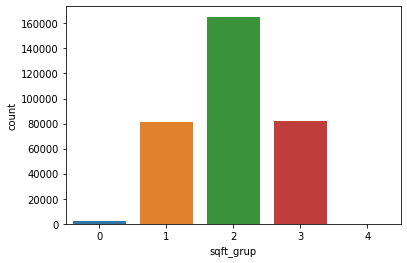

In [139]:
sns.countplot(x = 'sqft_grup', data = data)

позднее посмотрим какой из признаков лучше влмяет на модель

In [140]:
data.drop(['sqft'],axis=1, inplace=True)

### Признак ( beds )

In [141]:
print('Пропуски:', data['beds'].isna().sum())
print('Уникальных:', data['beds'].nunique())

Пропуски: 60287
Уникальных: 1116


In [142]:
data['beds'].value_counts()[:100]

3 Beds         47990
4 Beds         32705
3              30942
2 Beds         24034
4              19688
2              15930
Baths          15182
3 bd           12482
5 Beds         10537
4 bd            8107
3.0             8066
5               6181
4.0             5224
2 bd            5078
1               4558
6 Beds          3337
5 bd            2559
2.0             2420
6               1638
5.0             1362
0               1144
1 bd            1058
7 Beds           951
-- bd            838
Bath             705
8 Beds           675
6 bd             623
1.0              427
7                419
9 Beds           313
                 309
6.0              306
8                264
10 Beds          163
7 bd             134
12 Beds          125
-- sqft           92
5,000 sqft        90
8 bd              89
0.0               83
11 Beds           76
9                 75
7.0               64
10                57
1 acre            46
8.0               41
16 Beds           40
0.34 acres   

In [143]:
data.beds = data.beds.str.lower()

In [144]:
def clear_beds(x):
    try:
        if isinstance(x, int) or isinstance(x, float):
            x = str(x)
        if 'bath' in x:
            return 1
        if 'baths' in x or '2 bedrooms' in x or '1-2' in x:
            return 2
        if '3 or more bedrooms' in x:
            return 3
        if 'based on redfin' in x:
            return 1
        else:
          return x
    except:
        return x

In [145]:
data['beds'] = [clear_beds(x) for x in data['beds']]

In [146]:
data['beds'] = data.beds.str.replace(' beds', '').str.replace(' bd', '')
data['beds'] = data.beds.str.replace('--', '0')   #

In [147]:
# те значения, где информация о кроватях отсутствует, присвоим им 1
data['beds'][data.beds.str.contains('sqft|acres|acre| |--') == True] = 1
data['beds'] = data['beds'][(data.beds.isna() == False) & (data.beds != 'none')].astype(float)

In [148]:
data['beds'].fillna('2', inplace = True) 

In [149]:
data.beds = data.beds.astype(int)

In [150]:
print('Пропуски:', data['beds'].isna().sum())
print('Уникальных:', data['beds'].nunique())

Пропуски: 0
Уникальных: 45


In [151]:
display(data.beds.value_counts(dropna=False))

2      123646
3       99480
4       65724
5       20639
1        9274
6        5904
0        2065
7        1568
8        1069
9         431
10        251
12        180
11        118
16         66
13         46
14         40
15         31
18         28
24         27
20         16
17         10
26          8
22          8
32          6
19          6
28          5
27          5
30          4
23          4
34          3
44          3
25          3
48          2
36          2
33          2
40          2
42          1
21          1
46          1
52          1
47          1
39          1
29          1
144         1
35          1
Name: beds, dtype: int64

<AxesSubplot:xlabel='beds', ylabel='count'>

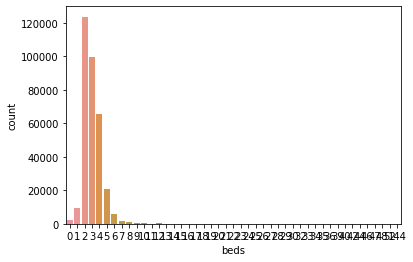

In [152]:
sns.countplot(x = 'beds', data = data)

### Новый признак спальни/кровати по группам ( beds_group )

Как вариант:

 давайте сделаем из этого столбца категориальный, следующим образом:
* 0 - 0
* 1 - 1
* 2 - 2
* 3 - 3
* 4 - 4
* 5 - 5
* 6 - 6
* 7 - 7
* 8 - 8
* 9 - c 9 до 15
* 10 - c 15 >

In [153]:

data['beds_grup'] = 0
data.loc[data['beds'] == 0, 'beds_grup'] = 0
data.loc[data['beds'] == 1, 'beds_grup'] = 1
data.loc[data['beds'] == 2, 'beds_grup'] = 2
data.loc[data['beds'] == 3, 'beds_grup'] = 3
data.loc[data['beds'] == 4, 'beds_grup'] = 4
data.loc[data['beds'] == 5, 'beds_grup'] = 5
data.loc[data['beds'] == 6, 'beds_grup'] = 6
data.loc[data['beds'] == 7, 'beds_grup'] = 7
data.loc[data['beds'] == 8, 'beds_grup'] = 8
data.loc[(data['beds'] >= 9) & (data['beds'] <= 15), 'beds_grup'] = 9
data.loc[(data['beds'] > 15), 'beds_grup'] = 10

In [154]:
display(data['beds_grup'].value_counts(dropna=False))

2     123646
3      99480
4      65724
5      20639
1       9274
6       5904
0       2065
7       1568
9       1097
8       1069
10       219
Name: beds_grup, dtype: int64

<AxesSubplot:xlabel='beds_grup', ylabel='count'>

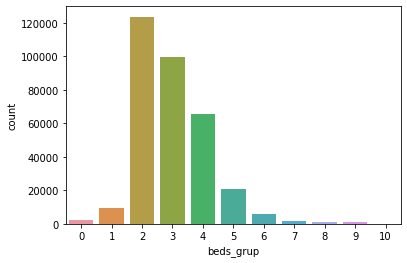

In [155]:
sns.countplot(x = 'beds_grup', data = data)

In [156]:
data.drop(['beds'],axis=1, inplace=True)

### Признак ванная ( baths )

In [157]:
print('Кол-во уникальных значений baths = ',len(data['baths'].unique()))  # 'иникальные значения :' ,data['baths'].unique())
print('Пропущенных значений в baths = ', data['baths'].isna().sum())

display(data['baths'].value_counts(dropna=False))

Кол-во уникальных значений baths =  204
Пропущенных значений в baths =  74508


NaN                    74508
2 Baths                48112
3 Baths                33908
2                      20369
2.0                    16217
4 Baths                13978
3.0                    10731
3                      10073
Bathrooms: 2            9229
2.5                     8109
Bathrooms: 3            6522
1                       6521
1.0                     5721
5 Baths                 5049
4.0                     4509
2.5 Baths               4232
4                       3527
3.5                     3446
Bathrooms: 1            3103
2 ba                    2637
6 Baths                 2396
Bathrooms: 4            2343
1,500                   2202
3 ba                    1868
1.5                     1850
2,000                   1790
3.5 Baths               1720
1,750                   1713
3,000                   1680
5.0                     1485
2,250                   1433
1,000                   1261
1,250                   1203
5                       1179
7 Baths       

In [158]:
data.baths = data.baths.str.upper()    

В США наличие ванной комнаты обозначается следующим образом: 
* Если 1 - это значит, что это полноценная ванная комната с душем, туалетом, ванной, раковиной.
* Если 0.5 - имеет только два из четырех основных компонентов ванной комнаты, обычно унитаз и раковину
* Если 0.75 - значит чего-то одного не хватает
* Если 0.25 - комната только с одним из четырех элементов, обычно это туалет


In [159]:
data['baths'] = data.baths.str.replace(' BATHS', '').str.replace('BATHROOMS: ', '').str.replace(' BA', '')
data['baths'] = data.baths.str.replace('SQ. FT.', '1').str.replace('SEMIMOD', '1')
data['baths'] = data.baths.str.replace('—', '0').str.replace('-', '0').str.replace('~', '0').str.replace('0 / 0', '0')
data['baths'] = data.baths.str.replace('116 / 116 / 116', '1').str.replace('301 / 202', '1').str.replace('100 / 100 / 1', '1')
data['baths'] = data.baths.str.replace('1 / 1 / 1 / 1', '1').str.replace('1 / 100 / 100 / 100', '1').str.replace('201 / 201 / 101 / 101', '1')
data['baths'] = data.baths.str.replace(',', '.').str.replace('+', '').str.replace('1 / 100', '1').str.replace('1 / 10', '1')

In [160]:
data.baths = data.baths.astype(float)

In [161]:
# Объеденим все значения где больше 6 ванных в одно - 6
data.loc[(data['baths'] >= 6), 'baths'] = 6
data.loc[(data['baths'] >= 1) & (data['baths'] < 2), 'baths'] = 1
data.loc[(data['baths'] >= 2) & (data['baths'] < 3), 'baths'] = 2
data.loc[(data['baths'] >= 3) & (data['baths'] < 4), 'baths'] = 3
data.loc[(data['baths'] >= 4) & (data['baths'] < 5), 'baths'] = 4
data.loc[(data['baths'] >= 5) & (data['baths'] < 6), 'baths'] = 5
# меньше 1 и больше 0 значений не много, отнесем их к 0
data.loc[(data['baths'] >= 0) & (data['baths'] < 1), 'baths'] = 0

In [162]:
display(data['baths'].value_counts(dropna=False))

2.0    114373
NaN     74508
3.0     70854
4.0     26904
1.0     24842
5.0      9492
6.0      8271
0.0      1441
Name: baths, dtype: int64

In [163]:
#заполнение отсутствующих значений 
data['baths']=data['baths'].fillna(2.75)

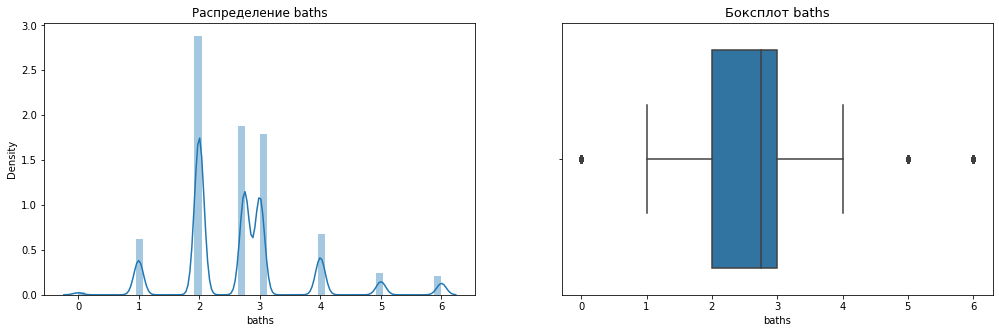

count    330685.000000
mean          2.648288
std           0.998619
min           0.000000
25%           2.000000
50%           2.750000
75%           3.000000
max           6.000000
Name: baths, dtype: float64

In [164]:
plt.figure(figsize=(17, 5))
plt.subplot(1,2,1)
plt.title(f"Распределение {'baths'}")
sns.distplot((data['baths']), bins=50)

plt.subplot(1,2,2)
sns.boxplot(data['baths'])
plt.xlabel('baths')
plt.title(f"Боксплот {'baths'}", fontsize=13)
plt.show()
data['baths'].describe()

### ПРизнак наличие камина ( fireplace )

In [165]:
print('Кол-во уникальных значений fireplace = ',len(data['fireplace'].unique()))  # 'иникальные значения :' ,data['fireplace'].unique())
print('Пропущенных значений в fireplace = ', data['fireplace'].isna().sum())

#data.fireplace = data.fireplace.str.upper() 
display(data['fireplace'].value_counts(dropna=False))

Кол-во уникальных значений fireplace =  1640
Пропущенных значений в fireplace =  232446


NaN                                                                                                                                                                                                                                        232446
yes                                                                                                                                                                                                                                         46399
Yes                                                                                                                                                                                                                                         20182
1                                                                                                                                                                                                                                           14501
2                               

fireplace имеет пропуски и очень грязные неоднородные значения.

Разобьем на наличие и отсутствие камина

In [166]:
data.fireplace = data.fireplace.apply(lambda x: 0 if pd.isnull(x) else 1)

### Признак улица ( street )

In [167]:
print('Кол-во уникальных значений street = ',len(data['street'].unique()))  # 'иникальные значения :' ,data['street'].unique())
print('Пропущенных значений в street = ', data['street'].isna().sum())

data.street = data.street.str.upper() 
#display(data['street'].value_counts(dropna=False))

Кол-во уникальных значений street =  295968
Пропущенных значений в street =  0


In [168]:
data['street'].value_counts()[:100]

ADDRESS NOT DISCLOSED                 610
UNDISCLOSED ADDRESS                   504
(UNDISCLOSED ADDRESS)                 386
ADDRESS NOT AVAILABLE                 127
UNKNOWN ADDRESS                        70
2103 E STATE HWY 21                    57
11305 GULF FWY                         54
17030 YOUNGBLOOD RD.                   38
9470 LANCASTER RD. SW                  32
1 PALMER DR                            27
9845 BASIL WESTERN RD NW               25
8426 TERRACE VALLEY CIRCLE             25
6320 SW 89TH COURT ROAD                24
8447 SW 99TH STREET RD                 22
5221 S. ZAPATA HWY                     20
WHITETAIL TRAIL                        19
STONE BLUFF DRIVE                      18
3435 HEATHER GARDEN TRAIL              17
BONCHER BLVD                           17
3423 HEATHER GARDEN TRAIL              17
24423 FERDOSSA DRIVE                   17
1727 OPAL FIELD LANE                   17
2005 WEST HAPPY VALLEY ROAD            17
1365 NEIHART WAY                  

In [169]:
def clear_street(s):
    try:
        if 'NOT' in s or 'DISCLOSED' in s or 'UNKNOWN' in s: 
            return '0'
        elif 'REGIONAL EXPRESS PLAN IN EVERS WAY' in s: 
            return '0'
        else:
            return s
    except:
        return "0"

In [170]:
data['street'] = [clear_street(x) for x in data['street']]
data['street'] = data['street'].fillna("0")
data['street'].value_counts()[:100]

0                                   1897
2103 E STATE HWY 21                   57
11305 GULF FWY                        54
17030 YOUNGBLOOD RD.                  38
9470 LANCASTER RD. SW                 32
1 PALMER DR                           27
8426 TERRACE VALLEY CIRCLE            25
9845 BASIL WESTERN RD NW              25
6320 SW 89TH COURT ROAD               24
8447 SW 99TH STREET RD                22
5221 S. ZAPATA HWY                    20
WHITETAIL TRAIL                       19
STONE BLUFF DRIVE                     18
1727 OPAL FIELD LANE                  17
3435 HEATHER GARDEN TRAIL             17
3423 HEATHER GARDEN TRAIL             17
24423 FERDOSSA DRIVE                  17
BONCHER BLVD                          17
2005 WEST HAPPY VALLEY ROAD           17
1365 NEIHART WAY                      17
1024 DALI BLVD.                       16
50 LEANNI WAY                         16
11 PHEASANT DRIVE                     16
606 VINEYARD HOLLOW COURT             16
13410 CANTERBURY

слишком много уникальных значений. 

Можно попробовать выделить группы такие как улица, проспект, переулок, бульвар и т.д.

In [171]:
def clear_street(s):
    s = str(s)
    if 'ADDRESS' in s or "0" in s: 
        return 'NO_ADDRESS'
    elif 'BLVD' in s or 'BOULEVARD' in s: 
        return 'BOULEVARD'
    elif 'WAY' in s: 
        return 'HWAY'
    elif 'CIR' in s: 
        return 'CIRCLE'
    elif 'CT' in s or 'COURT' in s: 
        return 'COURT'
    elif 'DR' in s or 'DRIVE' in s: 
        return 'DRIVE'
    elif 'RD' in s or 'ROAD' in s: 
        return 'ROAD'
    elif 'AVE' in s: 
        return 'AVENUE'
    elif 'ST' in s or 'STREET' in s: 
        return 'STREET'
    elif 'PL' in s: 
        return 'PLACE'
    elif 'LANE' in s: 
        return 'LANE'
    elif 'TR' in s or 'TRL' in s or 'TRAIL' in s: 
        return 'TRAIL'
    elif 'PARK' in s: 
        return 'PARK'
    else: 
        return 'OTHER'

In [172]:
data['street'] = [clear_street(x) for x in data['street']]

NO_ADDRESS    158051
STREET         38886
DRIVE          30745
AVENUE         26553
OTHER          20750
ROAD           18798
PLACE           9963
COURT           9471
HWAY            5926
BOULEVARD       4560
CIRCLE          4501
TRAIL           1958
PARK             346
LANE             177
Name: street, dtype: int64

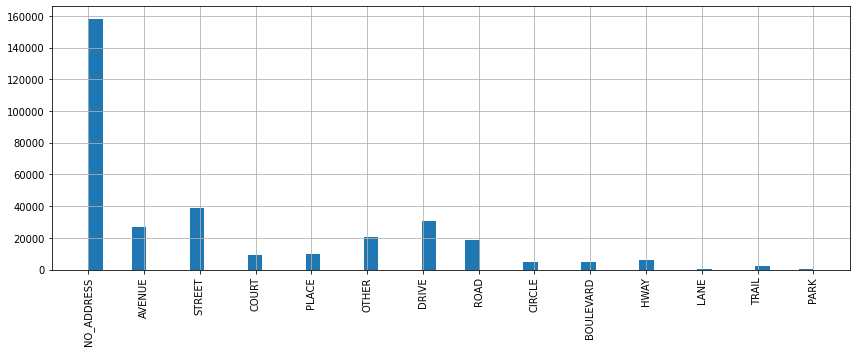

In [173]:
display(data.street.value_counts(dropna=False))
data.street.hist(figsize=(12,5), log=False, bins=50, xrot=90);
plt.tight_layout()

In [174]:
# удалим признак (он не улучшает модель)
# data.drop('street', axis=1, inplace=True)

### Новый признак год постройки ( Year built )

In [175]:
print('Кол-во уникальных значений Year built = ',len(data['Year built'].unique()))  # 'иникальные значения :' ,data['Year built'].unique())
print('Пропущенных значений в Year built = ', data['Year built'].isna().sum())

#data['Year built'] = data['Year built'].str.upper() 
display(data['Year built'].value_counts(dropna=False))

Кол-во уникальных значений Year built =  226
Пропущенных значений в Year built =  33795


NaN             33795
2019            31209
2006             7601
2005             7198
2007             6812
2018             6563
2004             5268
2017             4857
2008             4829
2016             4808
2003             4367
1950             4175
2002             4077
2001             4014
1920             3936
1925             3809
2015             3665
1955             3514
2000             3458
1960             3450
1974             3358
1973             3317
1999             3260
1979             3255
1972             3212
1980             3144
1981             3135
1984             3001
1998             2974
2014             2952
1970             2943
1978             2905
1985             2887
1983             2884
1940             2814
1997             2780
1930             2774
1986             2711
1989             2709
1987             2609
1971             2603
1965             2593
1968             2587
1959             2556
1956             2553
1990      

In [176]:
# data['Year built'].replace('No Data', 0, inplace=True)

# data['Year built'] = data['Year built'].fillna(0)
# data['Year built'] = data['Year built'].astype(int)

# data['Year built'].replace(559990649990, 0, inplace=True)
# data['Year built'].replace(1, 0, inplace=True)

In [177]:
data['Year built'] = data['Year built'].fillna(0)
data['Year built'] = data['Year built'].apply(lambda x: '0' 
                                    if ((x==0) or (x=='No Data') or (x=='') or (len(x)>4) or (len(x)<4) ) else x)
data['Year built'] = data['Year built'].astype(int)
data['Year built'].value_counts()

0       34943
2019    31209
2006     7601
2005     7198
2007     6812
2018     6563
2004     5268
2017     4857
2008     4829
2016     4808
2003     4367
1950     4175
2002     4077
2001     4014
1920     3936
1925     3809
2015     3665
1955     3514
2000     3458
1960     3450
1974     3358
1973     3317
1999     3260
1979     3255
1972     3212
1980     3144
1981     3135
1984     3001
1998     2974
2014     2952
1970     2943
1978     2905
1985     2887
1983     2884
1940     2814
1997     2780
1930     2774
1986     2711
1989     2709
1987     2609
1971     2603
1965     2593
1968     2587
1959     2556
1956     2553
1990     2544
1982     2515
1988     2508
1977     2503
1996     2499
1969     2455
1954     2431
1963     2424
2020     2421
1995     2418
1958     2416
1994     2346
1900     2280
1957     2249
1962     2249
2013     2230
1964     2210
1975     2195
1993     2178
2009     2160
1953     2120
1951     2073
1910     2035
1952     2026
1976     2006
1966     2005
1991  

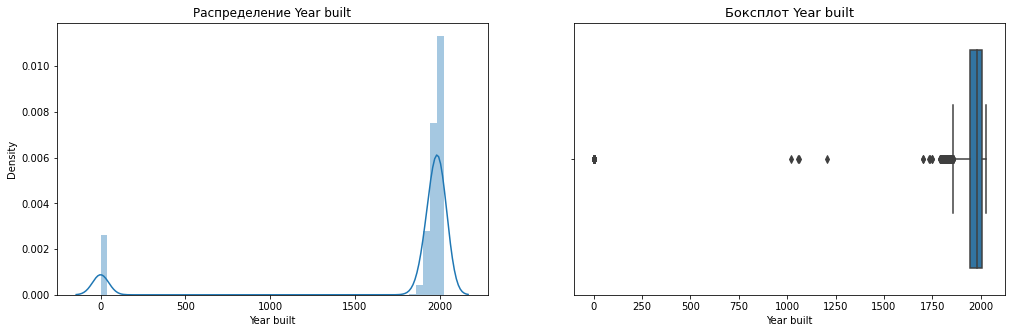

count    330685.000000
mean       1770.952136
std         609.548411
min           0.000000
25%        1947.000000
50%        1980.000000
75%        2006.000000
max        2025.000000
Name: Year built, dtype: float64

In [178]:
plt.figure(figsize=(17, 5))
plt.subplot(1,2,1)
plt.title(f"Распределение {'Year built'}")
sns.distplot((data['Year built']), bins=50)

plt.subplot(1,2,2)
sns.boxplot(data['Year built'])
plt.xlabel('Year built')
plt.title(f"Боксплот {'Year built'}", fontsize=13)
plt.show()
data['Year built'].describe()

In [179]:
# data['Year built'].replace(1208, 0, inplace=True)
# data['Year built'].replace(1057, 0, inplace=True)
# data['Year built'].replace(1060, 0, inplace=True)
# data['Year built'].replace(1019, 0, inplace=True)

In [180]:
data[(data['Year built']>0) & (data['Year built']<1700)]

status  propertyType  street  baths  fireplace       city zipcode  \
149913  PENDING  SINGLE-HOUSE  STREET   2.00          0      OTHER   43138   
172710   ACTIVE  SINGLE-HOUSE   PLACE   2.00          0      OCALA   34482   
264030   ACTIVE         OTHER  STREET   2.75          0   BROOKLYN   11218   
312838   ACTIVE         OTHER    HWAY   3.00          0  CHARLOTTE   28216   

       state  stories  PrivatePool   target  target_log  Year built  \
149913    OH        0            0   197500   12.193499        1208   
172710    FL        1            0   262250   12.477057        1057   
264030    NY        0            0  3749997   15.137266        1060   
312838    NC        0            0   713750   13.478289        1019   

       Remodeled year Parking      Price/sqft  schools_count  \
149913           None     888             $65              6   
172710           None    None            $101              8   
264030           1960    None  $793 / Sq. Ft.              4   
312838           None    None  $158 / Sq. Ft.              0   

        schools_min_dist  schools_mean_dist  schools_max_dist  \
149913               1.0                2.0               3.0   
172710               3.0                5.0               8.0   
264030               1.0                1.0               1.0   
312838               0.0                0.0               0.0   

        schools_min_rating  schools_max_rating  schools_mean_rating  sqft_log  \
149913                   4                 9.0                    6  7.097549   
172710                   1                 6.0                    3  6.949856   
264030                   5                 8.0                    6  7.545918   
312838                   5                 5.0                    5  7.502186   

        sqft_grup  beds_grup  
149913          1          3  
172710          1          2  
264030          2          2  
312838          2          2

In [181]:
data[(data['Year built']>=2022)]

status  propertyType      street  baths  fireplace             city  \
99694   ACTIVE         OTHER      STREET   2.75          0  FORT LAUDERDALE   
110632  ACTIVE         OTHER  NO_ADDRESS   1.00          0          HOUSTON   
129647  ACTIVE         OTHER  NO_ADDRESS   2.75          0          HOUSTON   
138366  ACTIVE         OTHER  NO_ADDRESS   2.75          0          HOUSTON   
164154  ACTIVE  SINGLE-HOUSE       COURT   2.75          1          RALEIGH   
179432  ACTIVE     TOWNHOUSE  NO_ADDRESS   3.00          1            OTHER   
237325  ACTIVE   CONDOMINIUM  NO_ADDRESS   2.75          0     PHILADELPHIA   
277624   OTHER     TOWNHOUSE  NO_ADDRESS   3.00          0            OTHER   
313472  ACTIVE  SINGLE-HOUSE  NO_ADDRESS   2.75          1          RALEIGH   
352202  ACTIVE   CONDOMINIUM  NO_ADDRESS   2.75          0     PHILADELPHIA   

       zipcode state  stories  PrivatePool    target  target_log  Year built  \
99694    33316    FL        0            0   5375000   15.497269        2022   
110632   77027    TX        0            0   4550000   15.330638        2022   
129647   77056    TX        0            0   9812500   16.099168        2022   
138366   77056    TX        0            0   4087500   15.223444        2022   
164154   27603    NC        0            0   1335000   14.104443        2025   
179432   98033    WA        0            0   9574500   16.074614        2022   
237325   19103    PA        0            0   7249987   15.796510        2022   
277624   98033    WA        0            0  12472000   16.338997        2022   
313472   27603    NC        0            0   1237475   14.028584        2025   
352202   19103    PA        0            0   5824987   15.577667        2022   

       Remodeled year             Parking       Price/sqft  schools_count  \
99694            None                None   $153 / Sq. Ft.              3   
110632           None                None   $607 / Sq. Ft.              3   
129647           None                None  $1040 / Sq. Ft.              3   
138366           None                None   $548 / Sq. Ft.              3   
164154           None                None   $152 / Sq. Ft.              3   
179432           None  Off street parking           $1,365              8   
237325           None                None  $1414 / Sq. Ft.              5   
277624           None                None           $1,646              8   
313472           None                None   $165 / Sq. Ft.              3   
352202           None                None  $1257 / Sq. Ft.              5   

        schools_min_dist  schools_mean_dist  schools_max_dist  \
99694                1.0                2.0               3.0   
110632               1.0                2.0               3.0   
129647               1.0                2.0               2.0   
138366               1.0                2.0               2.0   
164154               4.0                5.0               7.0   
179432               1.0                1.0               2.0   
237325               1.0                1.0               2.0   
277624               1.0                1.0               2.0   
313472               4.0                5.0               7.0   
352202               1.0                1.0               2.0   

        schools_min_rating  schools_max_rating  schools_mean_rating  sqft_log  \
99694                    5                 7.0                    6  9.551303   
110632                   5                10.0                    7  8.006368   
129647                   1                 7.0                    4  8.236421   
138366                   1                 7.0                    4  8.001690   
164154                   3                 5.0                    4  8.165932   
179432                   3                10.0                    6  7.939515   
237325                   1                 6.0                    3  7.626570   
277624                   3                10.

In [182]:
# Удалим данные где год постройки больше 2022, это очень сомнительные данные!
data = data[(data['Year built'] < 2022)]

# И удалим штучные (возможно раритетные памятники архитектуры)
data = data[(data['Year built']==0) | (data['Year built']>=1700)]

### Новый признак год реконструкции ( Remodeled year )

In [183]:
print('Кол-во уникальных значений Remodeled year = ',len(data['Remodeled year'].unique()))  # 'иникальные значения :' ,data['Remodeled year'].unique())
print('Пропущенных значений в Remodeled year = ', data['Remodeled year'].isna().sum())
 
display(data['Remodeled year'].value_counts(dropna=False))

Кол-во уникальных значений Remodeled year =  150
Пропущенных значений в Remodeled year =  186909


NaN     186909
2006      5210
2005      4565
2007      4163
2008      3626
2004      3198
1980      3166
1970      3000
2000      2953
2003      2695
1985      2684
1975      2593
2002      2590
1990      2551
1965      2520
1983      2384
2001      2329
1995      2282
1988      2248
1978      2116
1981      2072
1998      2018
1999      2000
1960      2000
1982      1943
1972      1912
2014      1901
1984      1864
1974      1838
1996      1824
1962      1777
1979      1746
1950      1734
1989      1723
1993      1711
1997      1707
1987      1698
1973      1693
1986      1689
2010      1673
1994      1577
1955      1577
2009      1520
2013      1504
2012      1486
1977      1476
1968      1428
1992      1425
2019      1422
2015      1402
1971      1345
1991      1342
2018      1325
2016      1317
2011      1260
1976      1224
1969      1193
1920      1171
2017      1164
1940      1143
1930      1135
1963      1127
1925      1108
1966      1048
1958      1004
1952       987
1956      

In [184]:
data['Remodeled year'] = data['Remodeled year'].fillna(0)
data['Remodeled year'] = data['Remodeled year'].astype(int)

# Удалим данные где год рестоврации больше 2022, это очень сомнительные данные!
data = data[(data['Remodeled year'] < 2022)]

# И удалим штучные (возможно раритетные памятники архитектуры)
data = data[(data['Remodeled year']==0) | (data['Remodeled year']>=1700)]


0       187140
2006      5210
2005      4565
2007      4163
2008      3626
2004      3198
1980      3166
1970      3000
2000      2953
2003      2695
1985      2684
1975      2593
2002      2590
1990      2551
1965      2520
1983      2384
2001      2329
1995      2282
1988      2248
1978      2116
1981      2072
1998      2018
1999      2000
1960      2000
1982      1943
1972      1912
2014      1901
1984      1864
1974      1838
1996      1824
1962      1777
1979      1746
1950      1734
1989      1723
1993      1711
1997      1707
1987      1698
1973      1693
1986      1689
2010      1673
1994      1577
1955      1577
2009      1520
2013      1504
2012      1486
1977      1476
1968      1428
1992      1425
2019      1422
2015      1402
1971      1345
1991      1342
2018      1325
2016      1317
2011      1260
1976      1224
1969      1193
1920      1171
2017      1164
1940      1143
1930      1135
1963      1127
1925      1108
1966      1048
1958      1004
1952       987
1957      

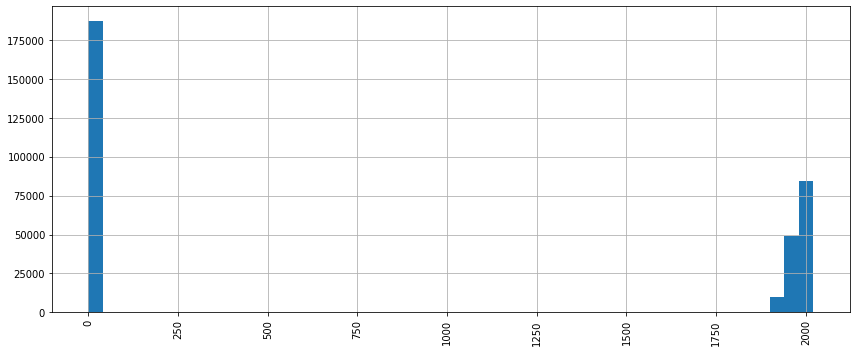

In [185]:
display(data['Remodeled year'].value_counts(dropna=False))
data['Remodeled year'].hist(figsize=(12,5), log=False, bins=50, xrot=90);
plt.tight_layout()

In [186]:
#len((data[data['Year built']<data['Remodeled year']]) and (data['Remodeled year']!=0))
df = data[data['Remodeled year']!=0]
df = df[df['Year built']>df['Remodeled year']]
len(df)

3231

In [187]:
df.head(6)

status  propertyType      street  baths  fireplace     city zipcode  \
113     OTHER  SINGLE-HOUSE  NO_ADDRESS   5.00          0  HOUSTON   77098   
177    ACTIVE  SINGLE-HOUSE  NO_ADDRESS   2.75          1   DALLAS   75229   
339  FOR SALE  SINGLE-HOUSE      STREET   4.00          0   DENVER   80211   
345  FOR SALE  SINGLE-HOUSE       COURT   6.00          1  HOUSTON   77024   
492  FOR SALE  SINGLE-HOUSE      AVENUE   4.00          0    OTHER   92037   
601       NEW  SINGLE-HOUSE  NO_ADDRESS   5.00          0    OTHER   80304   

    state  stories  PrivatePool    target  target_log  Year built  \
113    TX        2            1   5492500   15.518894        2019   
177    TX        0            0  16497500   16.618719        2010   
339    CO        3            0   2437500   14.706484        2015   
345    TX        2            1   9138187   16.027973        2018   
492    CA        0            0   7499997   15.830413        2019   
601    CO        2            0   5737500   15.562534        2018   

     Remodeled year          Parking      Price/sqft  schools_count  \
113            1950         2 spaces            $498              3   
177            2008             None  $569 / Sq. Ft.              4   
339            1960         2 spaces            $418              3   
345            1965  Detached Garage       $556/sqft              3   
492            1948         2 spaces            $915              3   
601            1958  Attached Garage            $575              3   

     schools_min_dist  schools_mean_dist  schools_max_dist  \
113               1.0                1.0               2.0   
177               2.0                4.0               9.0   
339               1.0                1.0               1.0   
345               1.0                1.0               1.0   
492               1.0                1.0               2.0   
601               1.0                1.0               2.0   

     schools_min_rating  schools_max_rating  schools_mean_rating  sqft_log  \
113                   6                10.0                    7  8.391857   
177                   3                10.0                    6  9.358674   
339                   2                 5.0                    3  7.756195   
345                   6                10.0                    8  8.791790   
492                   9                 9.0                    9  8.095904   
601                   4                 9.0                    6  8.291296   

     sqft_grup  beds_grup  
113          3          4  
177          3          2  
339          2          3  
345          3          5  
492          3          4  
601          3          4

надо пудумать, что делать с этими данными.

In [188]:
# Удалим
data = data.drop(df.loc[df['Year built']>df['Remodeled year']].index)

### Новые признаки age_built & Remodeled_age

Данные признаки 'Year built' и 'Remodeled year' лучше преобразовать в числовой вид, вычитая данные из максимального значения принака. Тогда нулевые значения признака будет иметь какой-то смысл, как возраст недвижимости.

А так же необходимо проверить, чтоб год постройки не был позже чем год реконструкции


In [189]:
max = data['Year built'].max()
data['age_built'] =  data['Year built'].apply(lambda x: int(max-x) if x!=0 else -1)

max = data['Remodeled year'].max()
data['Remodeled_age'] =  data['Remodeled year'].apply(lambda x: int(max-x) if x!=0 else -1)


In [190]:
len(data[data['Remodeled_age']==-1])

187140

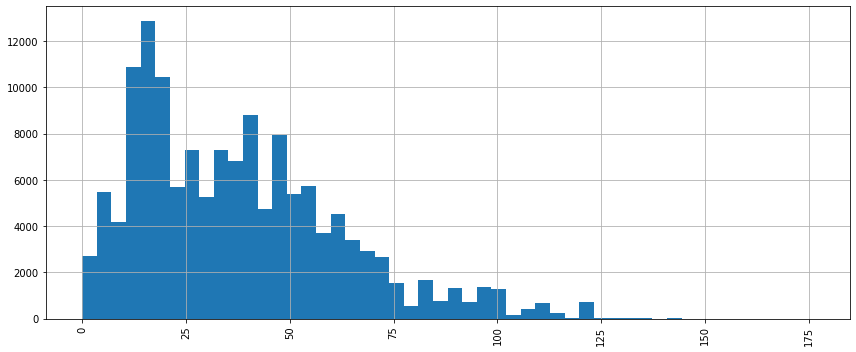

In [191]:
#display(data['Remodeled year'].value_counts(dropna=False))
(data['Remodeled_age'][data['Remodeled_age']>=0]).hist(figsize=(12,5), log=False, bins=50, xrot=90);
plt.tight_layout()

In [192]:
len(data[data['age_built']==-1])

34943

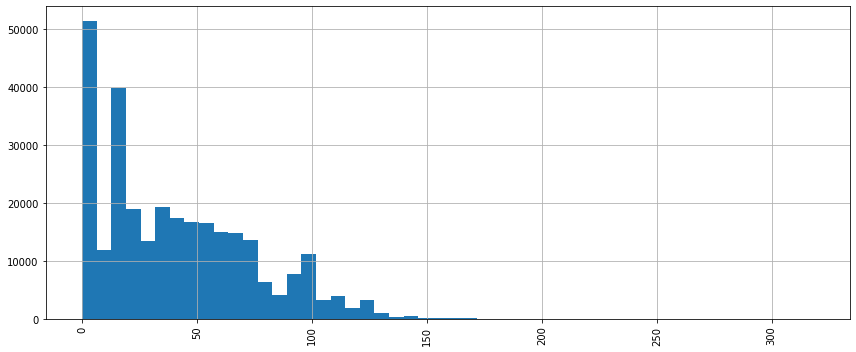

In [193]:
#display(data['Year built'].value_counts(dropna=False))
(data['age_built'][data['age_built']>=0]).hist(figsize=(12,5), log=False, bins=50, xrot=90);
plt.tight_layout()

In [194]:
print('Кол-во уникальных значений Remodeled_age = ',len(data['Remodeled_age'].unique()))  # 'иникальные значения :' ,data['Remodeled_age'].unique())
print('Пропущенных значений в Remodeled_age = ', data['Remodeled_age'].isna().sum())
 
#display(data['Remodeled_age'].value_counts(dropna=False))

Кол-во уникальных значений Remodeled_age =  149
Пропущенных значений в Remodeled_age =  0


In [195]:
data.loc[(data['Remodeled_age'] == 0) & (data['Remodeled_age'] == 1), 'Remodeled_age'] = 1
data.loc[(data['Remodeled_age'] >= 2) & (data['Remodeled_age'] < 5), 'Remodeled_age'] = 2
data.loc[(data['Remodeled_age'] >= 5) & (data['Remodeled_age'] <= 10), 'Remodeled_age'] = 3
data.loc[(data['Remodeled_age'] >= 11) & (data['Remodeled_age'] <= 15), 'Remodeled_age'] = 4
data.loc[(data['Remodeled_age'] >= 16) & (data['Remodeled_age'] <= 20), 'Remodeled_age'] = 5
data.loc[(data['Remodeled_age'] >= 21) & (data['Remodeled_age'] <= 40), 'Remodeled_age'] = 6
data.loc[(data['Remodeled_age'] >= 41) & (data['Remodeled_age'] <= 60), 'Remodeled_age'] = 7
data.loc[(data['Remodeled_age'] >= 61) & (data['Remodeled_age'] <= 80), 'Remodeled_age'] = 8
data.loc[(data['Remodeled_age'] >= 81) & (data['Remodeled_age'] <= 100), 'Remodeled_age'] = 9
data.loc[(data['Remodeled_age'] > 100), 'Remodeled_age'] = 10
data.loc[(data['Remodeled_age'] == -1), 'Remodeled_age'] = 11

In [196]:
display(data['Remodeled_age'].value_counts(dropna=False))

11    187140
6      39264
7      33150
4      16047
5      15221
8      14806
3       8596
9       5967
2       3707
10      3488
1         48
0          6
Name: Remodeled_age, dtype: int64

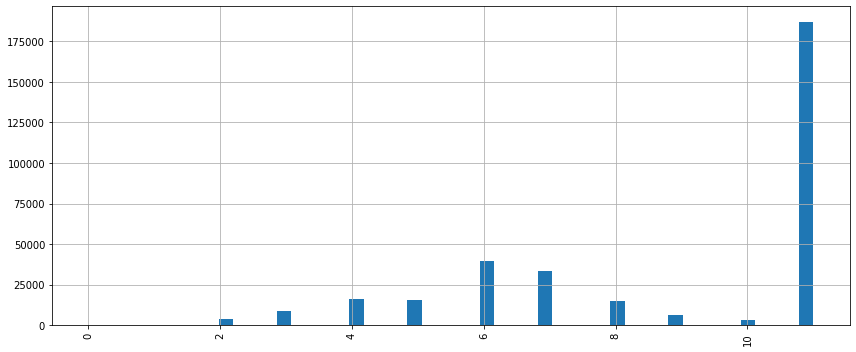

In [197]:

(data['Remodeled_age']).hist(figsize=(12,5), log=False, bins=50, xrot=90);
plt.tight_layout()

In [198]:
print('Кол-во уникальных значений age_built = ',len(data['age_built'].unique()))  # 'иникальные значения :' ,data['age_built'].unique())
print('Пропущенных значений в age_built = ', data['age_built'].isna().sum())
 
#display(data['age_built'].value_counts(dropna=False))

Кол-во уникальных значений age_built =  218
Пропущенных значений в age_built =  0


In [199]:
data.loc[(data['age_built'] == 0) & (data['age_built'] == 1), 'age_built'] = 1
data.loc[(data['age_built'] >= 2) & (data['age_built'] < 5), 'age_built'] = 2
data.loc[(data['age_built'] >= 5) & (data['age_built'] <= 10), 'age_built'] = 3
data.loc[(data['age_built'] >= 11) & (data['age_built'] <= 15), 'age_built'] = 4
data.loc[(data['age_built'] >= 16) & (data['age_built'] <= 20), 'age_built'] = 5
data.loc[(data['age_built'] >= 21) & (data['age_built'] <= 40), 'age_built'] = 6
data.loc[(data['age_built'] >= 41) & (data['age_built'] <= 60), 'age_built'] = 7
data.loc[(data['age_built'] >= 61) & (data['age_built'] <= 80), 'age_built'] = 8
data.loc[(data['age_built'] >= 81) & (data['age_built'] <= 100), 'age_built'] = 9
data.loc[(data['age_built'] > 100), 'age_built'] = 10
data.loc[(data['age_built'] == -1), 'age_built'] = 11

In [200]:
display(data['age_built'].value_counts(dropna=False))

6     53156
7     51584
2     40759
8     39562
11    34943
5     24777
4     22949
9     22632
10    18497
3     16225
1      2300
0        56
Name: age_built, dtype: int64

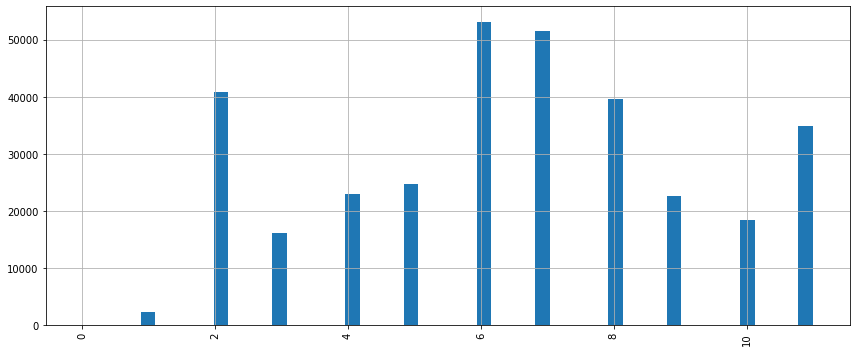

In [201]:

(data['age_built']).hist(figsize=(12,5), log=False, bins=50, xrot=90);
plt.tight_layout()

### Новый признак парковка ( Parking )

In [202]:
print('Кол-во уникальных значений Parking = ',len(data['Parking'].unique()))  # 'иникальные значения :' ,data['Parking'].unique())
print('Пропущенных значений в Parking = ', data['Parking'].isna().sum())
data['Parking'] = data['Parking'].str.upper() 
data['Parking'] = data['Parking'].fillna('NO DATA')
display(data['Parking'].value_counts(dropna=False))

Кол-во уникальных значений Parking =  3289
Пропущенных значений в Parking =  139380


NO DATA                                                                                                                                                                                                                                                                                                             152000
ATTACHED GARAGE                                                                                                                                                                                                                                                                                                      65136
2 SPACES                                                                                                                                                                                                                                                                                                             27159
1 SPACE                                                

пропусков в признаке ного!
поппытка очистки и привести к определенному ввиду показало не лучшие резудьтаты.
Делаю вывод, что лучше привести к бинарному виду, наличие парковки.


In [203]:
 # Признак будет бинарный: 0 - нет паркинг, 1 - есть паркинг.
data['Parking']=data['Parking'].apply(lambda x: 0 
            if x == 'NONE' or x=='NO DATA'  else 1)        

data['Parking'].value_counts()

1    173376
0    154064
Name: Parking, dtype: int64

### Новый признак ( Price/sqft )

In [204]:
print('Кол-во уникальных значений Price/sqft = ',len(data['Price/sqft'].unique()))  # 'иникальные значения :' ,data['Price/sqft'].unique())
print('Пропущенных значений в Price/sqft = ', data['Price/sqft'].isna().sum())
data['Price/sqft'] = data['Price/sqft'].str.upper() 
data['Price/sqft'] = data['Price/sqft'].fillna('NO INFO')
display(data['Price/sqft'].value_counts(dropna=False))

Кол-во уникальных значений Price/sqft =  5425
Пропущенных значений в Price/sqft =  32658


NO INFO               33574
NO DATA                1022
$125/SQFT               737
$132/SQFT               728
$128/SQFT               720
$121/SQFT               713
$119/SQFT               711
$120/SQFT               708
$127/SQFT               708
$130/SQFT               704
$122/SQFT               703
$115/SQFT               700
$123/SQFT               694
$123                    692
$118                    691
$139/SQFT               689
$116/SQFT               688
$140/SQFT               686
$117/SQFT               686
$124/SQFT               685
$135/SQFT               682
$122                    681
$127                    681
$121                    679
$118/SQFT               675
$111/SQFT               673
$126/SQFT               672
$136/SQFT               669
$133/SQFT               665
$133                    664
$138/SQFT               663
$113/SQFT               663
$131/SQFT               662
$114/SQFT               662
$129/SQFT               660
$141                

In [205]:
data['Price/sqft'] = data['Price/sqft'].str.replace('/SQFT', '').str.replace(' / SQ. FT.', '')
data['Price/sqft'] = data['Price/sqft'].str.replace('$', '').str.replace(',', '')   #
data['Price/sqft'] = data['Price/sqft'].str.replace('NO INFO', '0').str.replace('NO DATA', '0')

In [206]:
data['Price/sqft'] = data['Price/sqft'].astype(int)

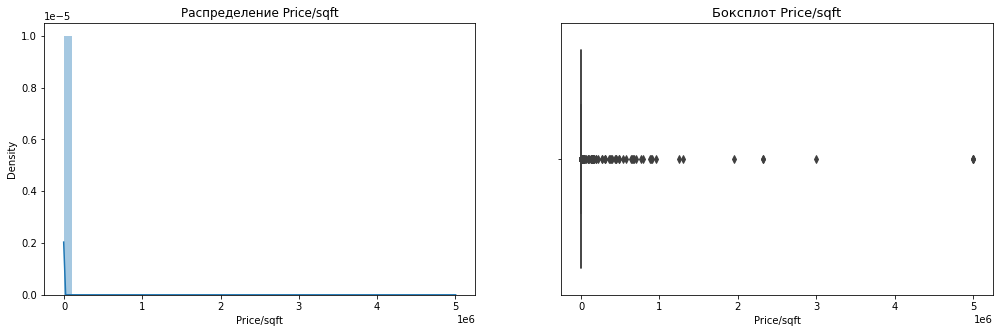

count    3.274400e+05
mean     3.678074e+02
std      1.845949e+04
min      0.000000e+00
25%      1.070000e+02
50%      1.630000e+02
75%      2.750000e+02
max      5.000000e+06
Name: Price/sqft, dtype: float64

In [207]:
plt.figure(figsize=(17, 5))
plt.subplot(1,2,1)
plt.title(f"Распределение {'Price/sqft'}")
sns.distplot((data['Price/sqft']), bins=50)

plt.subplot(1,2,2)
sns.boxplot(data['Price/sqft'])
plt.xlabel('Price/sqft')
plt.title(f"Боксплот {'Price/sqft'}", fontsize=13)
plt.show()
data['Price/sqft'].describe()

In [208]:
data.loc[(data['Price/sqft'] > 0) & (data['Price/sqft'] <= 30), 'Price/sqft'] = 1
data.loc[(data['Price/sqft'] > 30) & (data['Price/sqft'] <= 100), 'Price/sqft'] = 2
data.loc[(data['Price/sqft'] > 100) & (data['Price/sqft'] <= 200), 'Price/sqft'] = 3
data.loc[(data['Price/sqft'] > 200) & (data['Price/sqft'] <= 350), 'Price/sqft'] = 4
data.loc[(data['Price/sqft'] > 350) & (data['Price/sqft'] <= 500), 'Price/sqft'] = 5
data.loc[(data['Price/sqft'] > 500) & (data['Price/sqft'] <= 700), 'Price/sqft'] = 6
data.loc[(data['Price/sqft'] > 700) & (data['Price/sqft'] <= 1000), 'Price/sqft'] = 7
data.loc[(data['Price/sqft'] > 1000) & (data['Price/sqft'] <= 1500), 'Price/sqft'] = 8
data.loc[(data['Price/sqft'] > 1500) & (data['Price/sqft'] <= 2000), 'Price/sqft'] = 9
data.loc[(data['Price/sqft'] > 2000) & (data['Price/sqft'] <= 2500), 'Price/sqft'] = 10
data.loc[(data['Price/sqft'] > 2500) & (data['Price/sqft'] <= 5000), 'Price/sqft'] = 11
data.loc[(data['Price/sqft'] > 5000) & (data['Price/sqft'] <= 10000), 'Price/sqft'] = 12

data.loc[(data['Price/sqft'] > 10000) & (data['Price/sqft'] <= 50000), 'Price/sqft'] = 13
data.loc[(data['Price/sqft'] > 50000) & (data['Price/sqft'] <= 100000), 'Price/sqft'] = 14

data.loc[(data['Price/sqft'] > 100000), 'Price/sqft'] = 15
data.loc[(data['Price/sqft'] == 0), 'Price/sqft'] = 0

In [209]:
display(data['Price/sqft'].value_counts(dropna=False))

3     129029
4      67259
2      35171
0      34599
5      27290
6      16443
7       8959
8       3800
1       3085
9       1115
10       374
11       237
15        51
12        13
13        12
14         3
Name: Price/sqft, dtype: int64

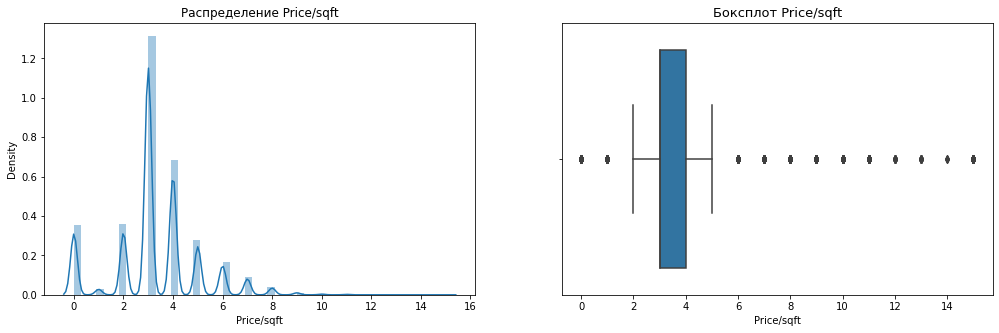

count    327440.000000
mean          3.283875
std           1.729000
min           0.000000
25%           3.000000
50%           3.000000
75%           4.000000
max          15.000000
Name: Price/sqft, dtype: float64

In [210]:
plt.figure(figsize=(17, 5))
plt.subplot(1,2,1)
plt.title(f"Распределение {'Price/sqft'}")
sns.distplot((data['Price/sqft']), bins=50)

plt.subplot(1,2,2)
sns.boxplot(data['Price/sqft'])
plt.xlabel('Price/sqft')
plt.title(f"Боксплот {'Price/sqft'}", fontsize=13)
plt.show()
data['Price/sqft'].describe()

In [211]:
# Удалим данные  больше 10000.
data = data[(data['Price/sqft'] < 12)]

## общий обзор получившегося датафрейма

In [212]:
df = data.copy()

In [213]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 327361 entries, 0 to 377134
Data columns (total 28 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   status               327361 non-null  object 
 1   propertyType         327361 non-null  object 
 2   street               327361 non-null  object 
 3   baths                327361 non-null  float64
 4   fireplace            327361 non-null  int64  
 5   city                 327361 non-null  object 
 6   zipcode              327361 non-null  object 
 7   state                327361 non-null  object 
 8   stories              327361 non-null  int64  
 9   PrivatePool          327361 non-null  int64  
 10  target               327361 non-null  int64  
 11  target_log           327361 non-null  float64
 12  Year built           327361 non-null  int64  
 13  Remodeled year       327361 non-null  int64  
 14  Parking              327361 non-null  int64  
 15  Price/sqft       

<AxesSubplot:>

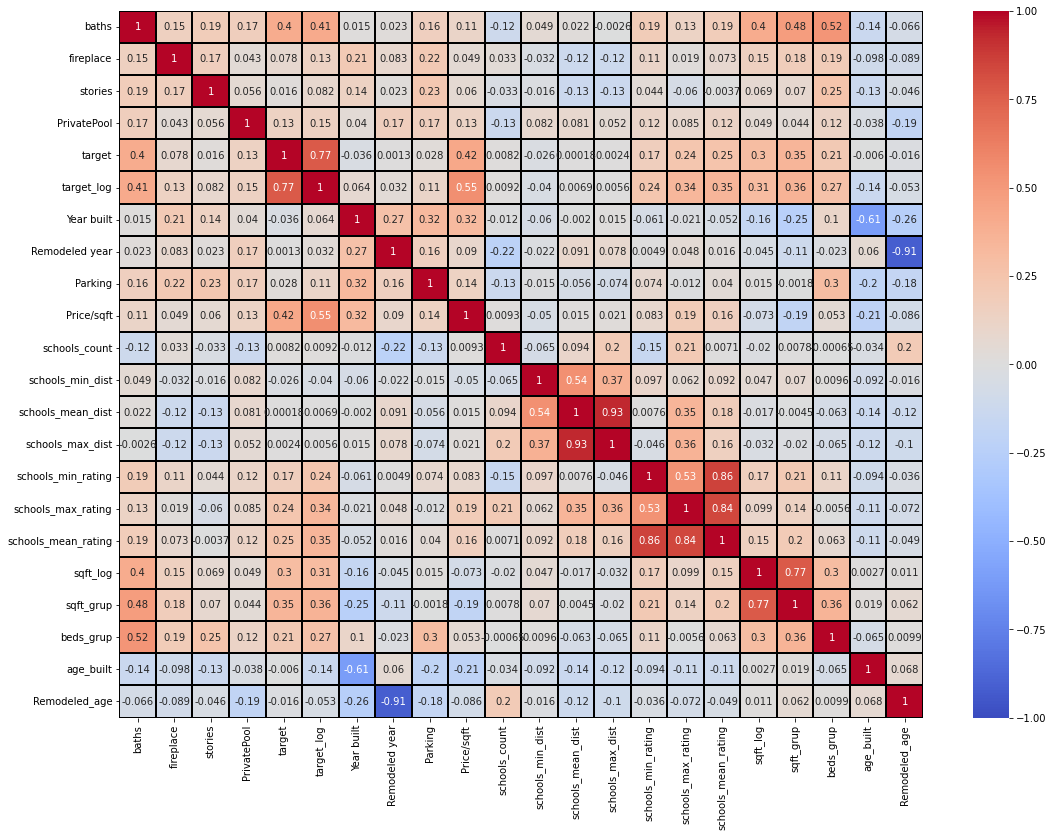

In [214]:
plt.figure(figsize = (18,13))
sns.heatmap(df.corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', linewidths=2, linecolor='black')

In [215]:
df.columns

Index(['status', 'propertyType', 'street', 'baths', 'fireplace', 'city',
       'zipcode', 'state', 'stories', 'PrivatePool', 'target', 'target_log',
       'Year built', 'Remodeled year', 'Parking', 'Price/sqft',
       'schools_count', 'schools_min_dist', 'schools_mean_dist',
       'schools_max_dist', 'schools_min_rating', 'schools_max_rating',
       'schools_mean_rating', 'sqft_log', 'sqft_grup', 'beds_grup',
       'age_built', 'Remodeled_age'],
      dtype='object')

имеются признаки с сильной корреляцией, но их удалим позже

In [216]:
col_drop = ['Remodeled year', 'schools_mean_dist', 'schools_max_dist', 'schools_min_rating', 'schools_max_rating', ]

In [217]:
cat_col = ['status', 'propertyType', 'street','city','zipcode', 'state']

**Результаты EDA**
- наши данные ооооочень грязные!
- очень много времени уделено чистке признаков, почти все обрабатывались "вручную"
- прологарифмировала целевую переменную и признак площади
- максимально постаралась сохранить данные, поэтому  большое кол-во пропусков заменяла на NO INFO  и   NO DATA
- Почти все признаки категориальные.
- Были созданы новые признаки из старых



In [218]:
# сохраним полученный датасет
#df.to_csv(path+'/data_EDA.csv')

In [219]:
df.columns

Index(['status', 'propertyType', 'street', 'baths', 'fireplace', 'city',
       'zipcode', 'state', 'stories', 'PrivatePool', 'target', 'target_log',
       'Year built', 'Remodeled year', 'Parking', 'Price/sqft',
       'schools_count', 'schools_min_dist', 'schools_mean_dist',
       'schools_max_dist', 'schools_min_rating', 'schools_max_rating',
       'schools_mean_rating', 'sqft_log', 'sqft_grup', 'beds_grup',
       'age_built', 'Remodeled_age'],
      dtype='object')

In [220]:
df = df.drop(['zipcode'],axis=1)

In [221]:
df.describe(include='all')

status  propertyType      street          baths      fireplace  \
count     327361        327361      327361  327361.000000  327361.000000   
unique        12            12          14            NaN            NaN   
top     FOR SALE  SINGLE-HOUSE  NO_ADDRESS            NaN            NaN   
freq      168614        190494      156480            NaN            NaN   
mean         NaN           NaN         NaN       2.640855       0.295787   
std          NaN           NaN         NaN       0.989734       0.456396   
min          NaN           NaN         NaN       0.000000       0.000000   
25%          NaN           NaN         NaN       2.000000       0.000000   
50%          NaN           NaN         NaN       2.750000       0.000000   
75%          NaN           NaN         NaN       3.000000       1.000000   
max          NaN           NaN         NaN       6.000000       1.000000   

          city   state        stories    PrivatePool        target  \
count   327361  327361  327361.000000  327361.000000  3.273610e+05   
unique     201      34            NaN            NaN           NaN   
top      OTHER      FL            NaN            NaN           NaN   
freq     49205   97586            NaN            NaN           NaN   
mean       NaN     NaN       0.971753       0.124129  1.393791e+06   
std        NaN     NaN       0.982654       0.329729  1.832334e+06   
min        NaN     NaN       0.000000       0.000000  7.737000e+03   
25%        NaN     NaN       0.000000       0.000000  5.250000e+05   
50%        NaN     NaN       1.000000       0.000000  8.475000e+05   
75%        NaN     NaN       2.000000       0.000000  1.487500e+06   
max        NaN     NaN       4.000000       1.000000  1.798750e+07   

           target_log     Year built  Remodeled year        Parking  \
count   327361.000000  327361.000000   327361.000000  327361.000000   
unique            NaN            NaN             NaN            NaN   
top               NaN            NaN             NaN            NaN   
freq              NaN            NaN             NaN            NaN   
mean        13.685260    1768.580756      849.752564       0.529513   
std          0.945811     612.106286      981.500424       0.499129   
min          8.953899       0.000000        0.000000       0.000000   
25%         13.171155    1947.000000        0.000000       0.000000   
50%         13.650047    1979.000000        0.000000       1.000000   
75%         14.212608    2006.000000     1981.000000       1.000000   
max         16.705188    2021.000000     2021.000000       1.000000   

           Price/sqft  schools_count  schools_min_dist  schools_mean_dist  \
count   327361.000000  327361.000000     327361.000000      327361.000000   
unique            NaN            NaN               NaN                NaN   
top               NaN            NaN               NaN                NaN   
freq              NaN            NaN               NaN                NaN   
mean         3.281249       3.748015          1.495178           2.740125   
std          1.720825       1.836553          1.033855           1.896216   
min          0.000000       0.000000          0.000000           0.000000   
25%          3.000000       3.000000          1.000000           1.000000   
50%          3.000000       3.000000          1.000000           2.000000   
75%          4.000000       4.000000          2.000000           3.000000   
max         11.000000      10.000000          7.000000           9.000000   

        schools_max_dist  schools_min_rating  schools_max_rating  \
count      327361.000000       327361.000000       327361.000000   
unique               NaN                 NaN                 NaN   
top                  NaN                 NaN                 NaN   
freq                 NaN                 NaN                 NaN   
mean            4.225916            3.764135            6.729830   
std             3.217735            2.049892            2.316855   
mi

In [222]:
df.sample(7)

status  propertyType      street  baths  fireplace     city state  \
120352   AUCTION  SINGLE-HOUSE      AVENUE    1.0          0   YAKIMA    WA   
324253  FOR SALE  SINGLE-HOUSE  NO_ADDRESS    2.0          0  TAMARAC    FL   
144195  FOR SALE  SINGLE-HOUSE      STREET    2.0          1  MEMPHIS    TN   
354355  FOR SALE  SINGLE-HOUSE       PLACE    5.0          1  CONCORD    NC   
75464   FOR SALE   CONDOMINIUM      STREET    3.0          0  CHICAGO    IL   
268163    ACTIVE         RANCH       DRIVE    1.0          1   DURHAM    NC   
306492  CONTRACT  SINGLE-HOUSE       OTHER    2.0          0  PHOENIX    AZ   

        stories  PrivatePool   target  target_log  Year built  Remodeled year  \
120352        1            0   361575   12.798228        1948            1973   
324253        1            0   600000   13.304687        1989               0   
144195        2            0   257750   12.459749        1961               0   
354355        2            1  1912500   14.463922        2007               0   
75464         4            0  1622500   14.299479        2019               0   
268163        0            0   706250   13.467726        1979            1982   
306492        1            0   850000   13.652993        2001               0   

        Parking  Price/sqft  schools_count  schools_min_dist  \
120352        1           0              3               1.0   
324253        1           3              3               1.0   
144195        1           2              4               1.0   
354355        1           3              3               1.0   
75464         1           0              2               1.0   
268163        0           3              3               1.0   
306492        1           3              8               2.0   

        schools_mean_dist  schools_max_dist  schools_min_rating  \
120352                1.0               2.0                   2   
324253                1.0               3.0                   5   
144195                1.0               1.0                   2   
354355                2.0               3.0                   2   
75464                 5.0              10.0                   1   
268163                2.0               4.0                   2   
306492                3.0               5.0                   7   

        schools_max_rating  schools_mean_rating  sqft_log  sqft_grup  \
120352                 2.0                    2  6.867974          1   
324253                 7.0                    5  7.118826          1   
144195                 2.0                    2  7.634337          2   
354355                 3.0                    2  8.449557          3   
75464                  4.0                    2  8.344196          3   
268163                 4.0                    3  7.614312          2   
306492                10.0                    9  7.681560          2   

        beds_grup  age_built  Remodeled_age  
120352          2          8              7  
324253          2          6             11  
144195          4          7             11  
354355          4          4             11  
75464           3          2             11  
268163          2          7              6  
306492          3          5             11

# PreProc Tabular Data

In [223]:
cat_cols = ['status', 'propertyType', 'street','city', 'state', 
           'fireplace', 'PrivatePool', 'Parking']
num_cols = ['baths', 'stories',	'Price/sqft','beds_grup' ,'sqft_grup', 'Year built', 'schools_count',	'schools_min_dist',	'schools_mean_rating',	'sqft_log', 'age_built',	'Remodeled_age' ]
target_log =	['target_log']
target = ['target']

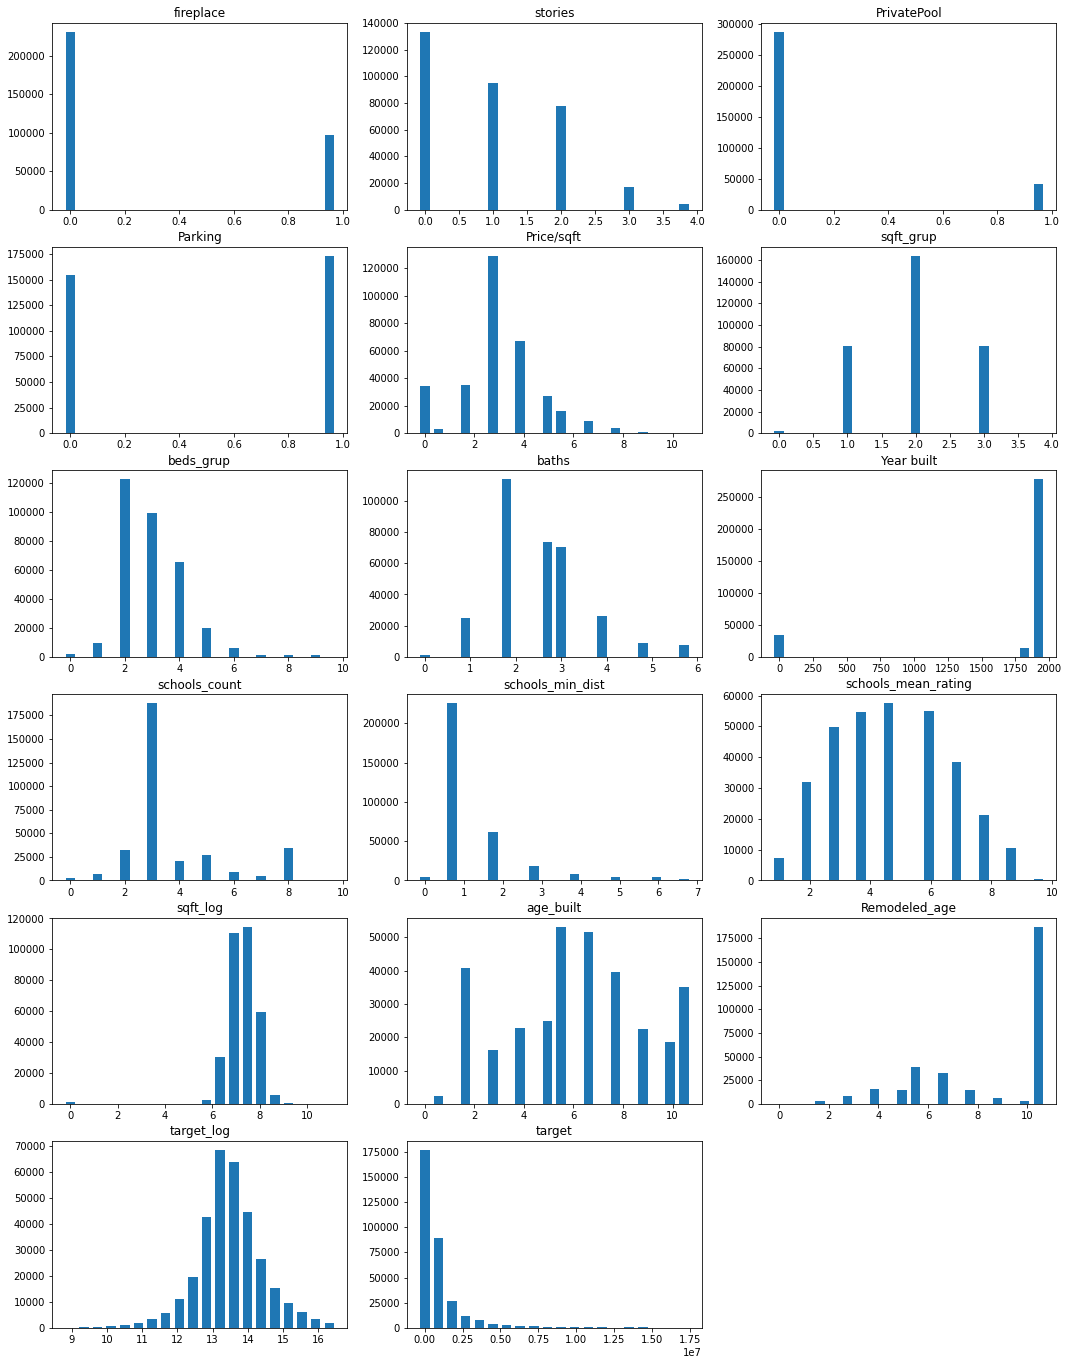

In [224]:
# Посмотрим, как выглядят распределения числовых признаков.

visualize_distributions({
    'fireplace': df['fireplace'].dropna(),
    'stories': df['stories'].dropna(),
    'PrivatePool': df['PrivatePool'].dropna(),
    'Parking': df['Parking'].dropna(),
    'Price/sqft': df['Price/sqft'].dropna(),
    'sqft_grup': df['sqft_grup'].dropna(),
    'beds_grup': df['beds_grup'].dropna(),
    'baths': df['baths'].dropna(),
    'Year built': df['Year built'].dropna(),
    'schools_count': df['schools_count'].dropna(),
    'schools_min_dist': df['schools_min_dist'].dropna(),
    'schools_mean_rating': df['schools_mean_rating'].dropna(),
    'sqft_log': df['sqft_log'].dropna(),
    'age_built': df['age_built'].dropna(),
    'Remodeled_age': df['Remodeled_age'].dropna(),
    'target_log': df['target_log'].dropna(),
    'target': df['target'].dropna()
})

не все распределения симметричны, перед обучением моделей необходима нормировка

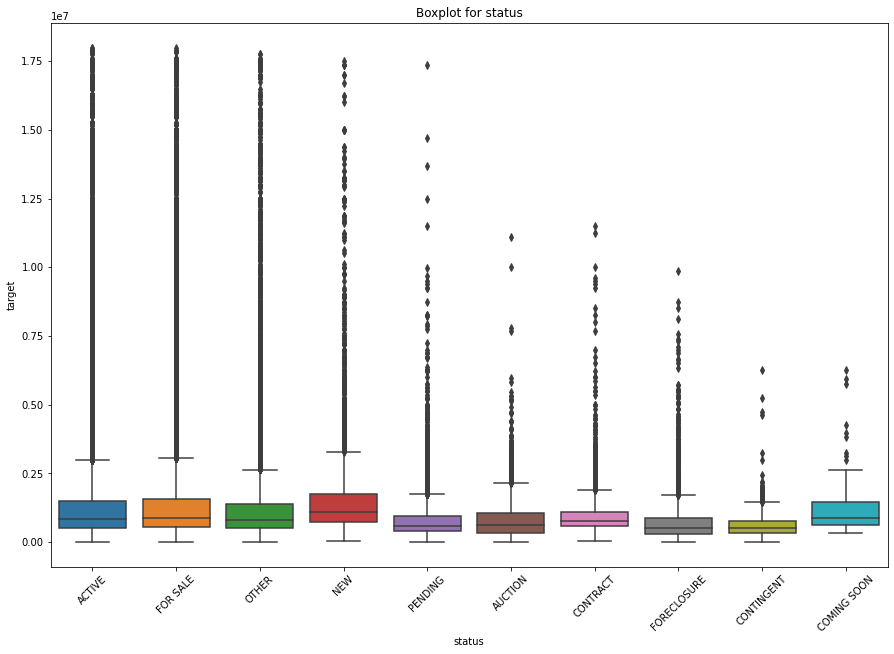

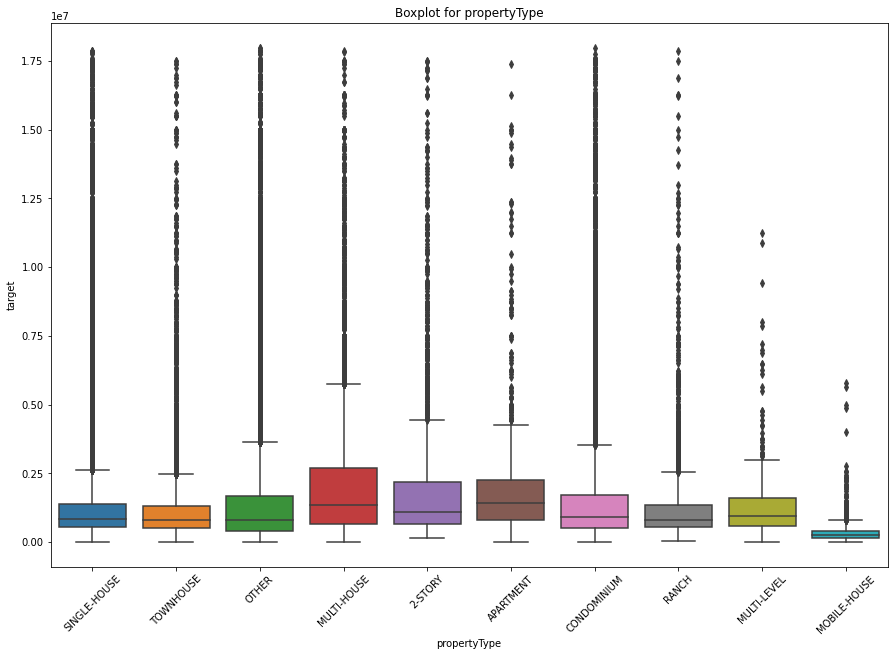

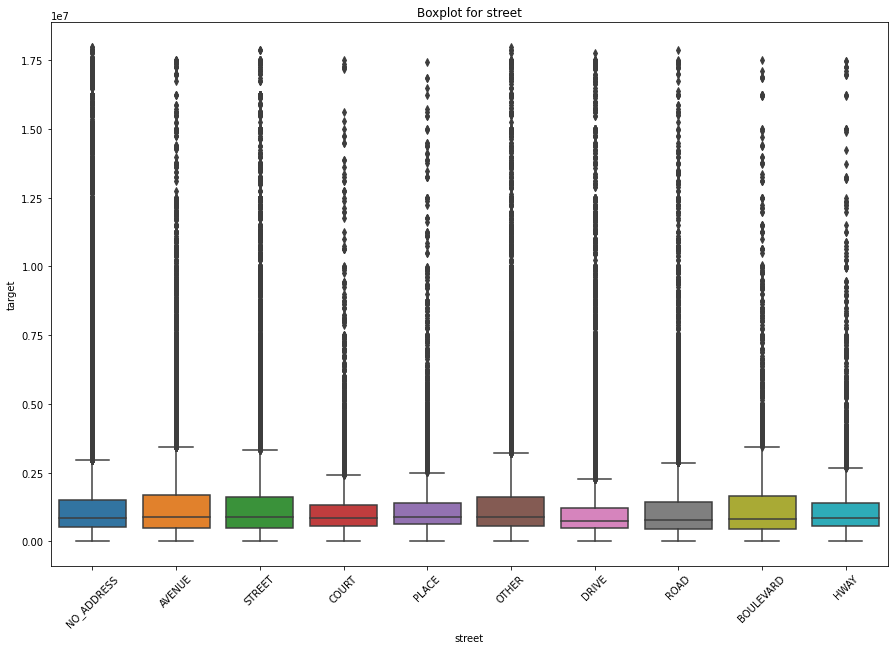

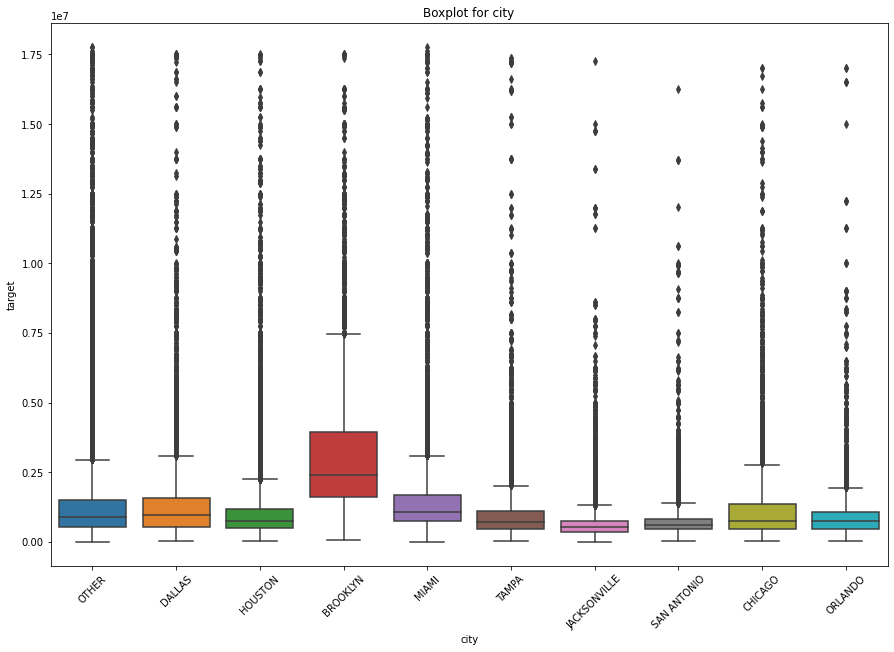

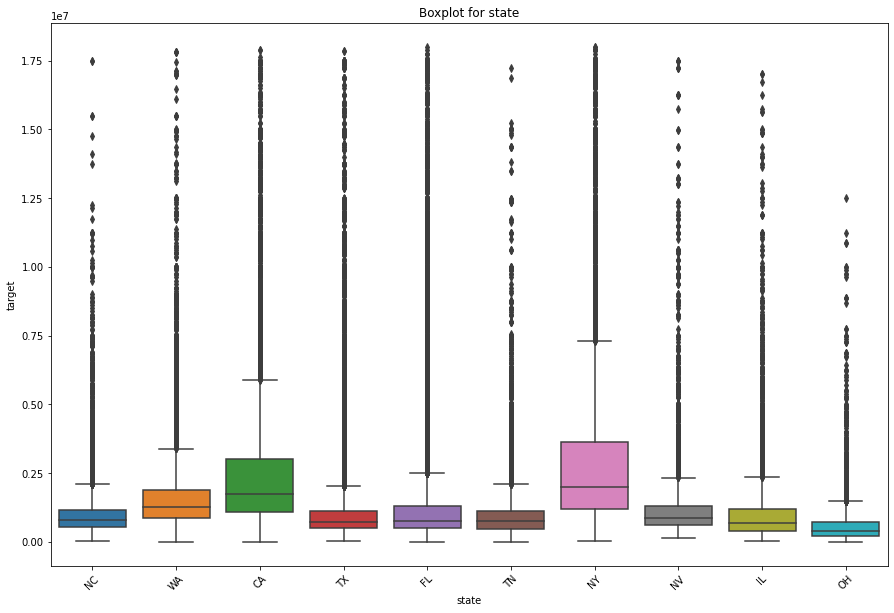

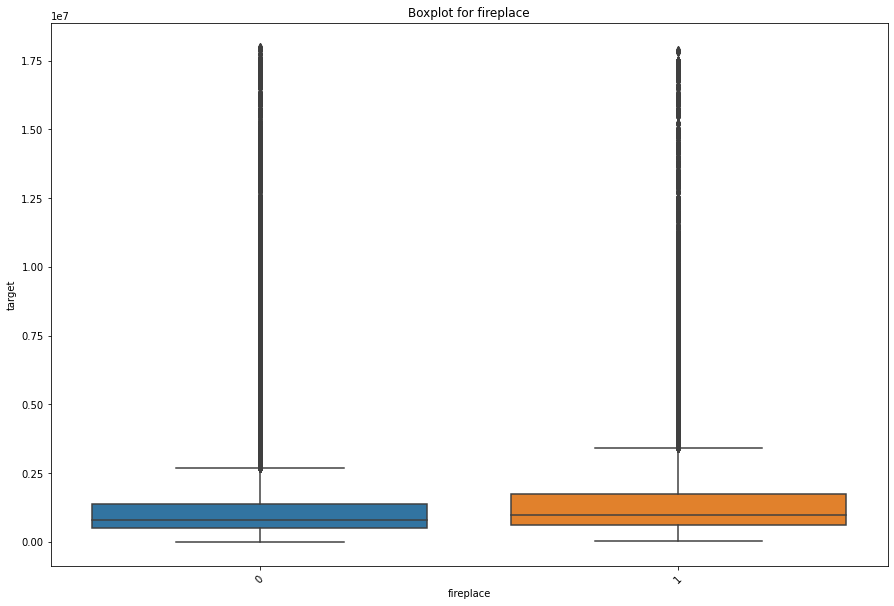

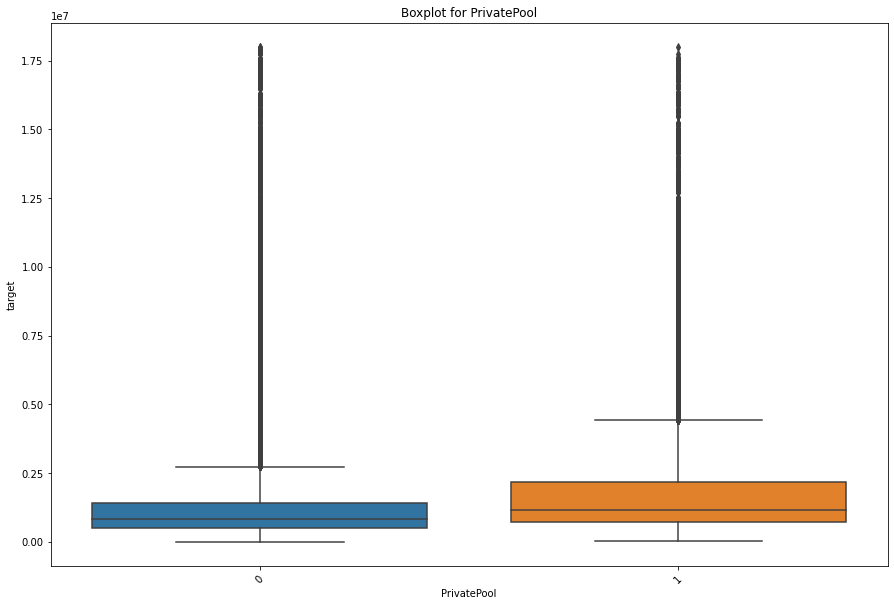

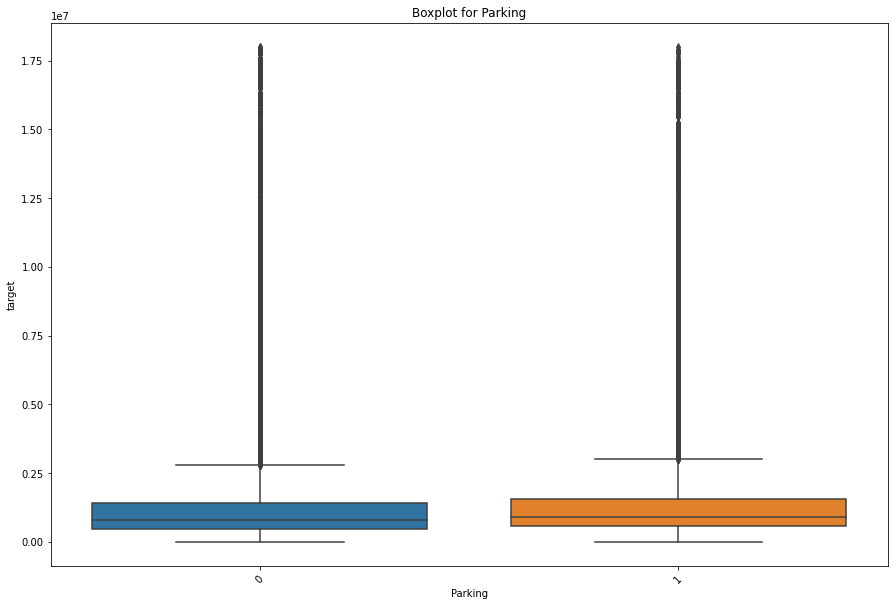

In [225]:
# график  плотность распределения переменных
def get_boxplot(column):
    fig, ax = plt.subplots(figsize=(15, 10))
    sns.boxplot(x=column, y='target',
                data=df.loc[df.loc[:, column].isin(df.loc[:, column].value_counts().index[:10])], ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

# Посмотрим  на категориальные признаки:
for column in cat_cols:
    get_boxplot(column)

In [226]:
df = df.drop('target_log', axis=1)

In [227]:
# Проведем тест Стьюдента для определения наиболее значимых для результата признаков 
# Как видим, все категориальные значения,  значимы. 
from itertools import combinations
from scipy.stats import ttest_ind

def get_student(column):
# тест Стьюдента

    cols = df.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
#    display (combinations_all)
    for comb in combinations_all:
        if ttest_ind(df.loc[df.loc[:, column] == comb[0], 'target'], 
                        df.loc[df.loc[:, column] == comb[1], 'target']).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break
colns = cat_cols + num_cols 
for col in colns:
    get_student(col)

Найдены статистически значимые различия для колонки status
Найдены статистически значимые различия для колонки propertyType
Найдены статистически значимые различия для колонки street
Найдены статистически значимые различия для колонки city
Найдены статистически значимые различия для колонки state
Найдены статистически значимые различия для колонки fireplace
Найдены статистически значимые различия для колонки PrivatePool
Найдены статистически значимые различия для колонки Parking
Найдены статистически значимые различия для колонки baths
Найдены статистически значимые различия для колонки stories
Найдены статистически значимые различия для колонки Price/sqft
Найдены статистически значимые различия для колонки beds_grup
Найдены статистически значимые различия для колонки sqft_grup
Найдены статистически значимые различия для колонки Year built
Найдены статистически значимые различия для колонки schools_count
Найдены статистически значимые различия для колонки schools_min_dist
Найдены стати

In [228]:
for i in cat_cols:
    print('count uniq ',i ,'= ',len(df[i].unique()))


count uniq  status =  12
count uniq  propertyType =  12
count uniq  street =  14
count uniq  city =  201
count uniq  state =  34
count uniq  fireplace =  2
count uniq  PrivatePool =  2
count uniq  Parking =  2


In [229]:
for i in num_cols:
    print('count uniq ',i ,'= ',len(df[i].unique()))


count uniq  baths =  8
count uniq  stories =  5
count uniq  Price/sqft =  12
count uniq  beds_grup =  11
count uniq  sqft_grup =  5
count uniq  Year built =  218
count uniq  schools_count =  11
count uniq  schools_min_dist =  8
count uniq  schools_mean_rating =  10
count uniq  sqft_log =  8522
count uniq  age_built =  12
count uniq  Remodeled_age =  12


# кодирование признаков, вариант №1

In [230]:
col_drop = ['Remodeled year', 'schools_mean_dist', 'schools_max_dist', 'schools_min_rating', 'schools_max_rating', ]

In [231]:
#df_copy = df.copy()

In [232]:
# # Используем Frequency Encoding для признаков с высокой спектром значений.
# #Frequency Encoding list
# cat_big_cols= ['status', 'propertyType', 'street','city', 'state']

# #Функция Frequency Encoding
# def freqenc_encoding_cat_big_cols(cols):
#     fe = df_copy.groupby(cols).size()/len(df_copy)*100
#     df_copy.loc[:, cols] = df_copy[cols].map(fe)
    
# #Encoding    
# for i in cat_big_cols:
#     freqenc_encoding_cat_big_cols(i)

In [233]:
# # Преобразуем все значения категориальных признаков в числа:
# cat_LE_cols = ['status', 'propertyType', 'street','city', 'state', 
#            'fireplace', 'PrivatePool', 'Parking']
# label_encoder = LabelEncoder()
# for i in cat_LE_cols:
#     label_encoder.fit(df_copy[i])
#     df_copy[i] = label_encoder.transform(df_copy[i])

In [234]:
#df_copy.sample(3)

In [235]:
# cat_num_cols = num_cols+cat_cols+col_drop
# # посмотрим влияние на целевой параметр всех признаков (с некоторыми прологарифмированными признаками)
# imp_num = pd.Series(f_classif(df_copy[cat_num_cols], df_copy.target)[0], index = cat_num_cols)
# imp_num.sort_values(inplace = True)
# plt.figure(figsize=(6,5))
# imp_num.plot(kind = 'barh').set_title('влияние на целевой показатель',fontsize=11)
# display(imp_num)

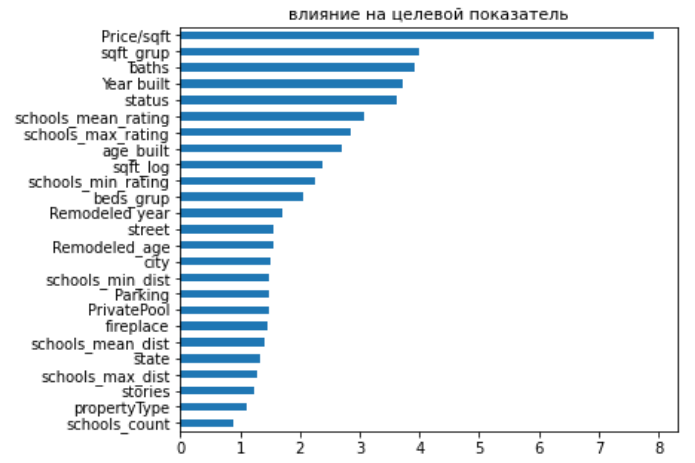

самым значим признаком является цена за кв.фут, что логично. 
и самыми менее значимыми кол-во школ


# Split 1

In [236]:

# X = df_copy.drop(['target'],axis = 1)
# y = df_copy['target']

# #Разбиваю данные на test и train
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [237]:
# # Произведем маштабирование числовых признаков
# from sklearn.preprocessing import MinMaxScaler
# # MinMaxScaler не искажает расстояния между значениями в каждой функции.
# scaler = MinMaxScaler() 
# # scaler = StandardScaler()
# # scaler = RobustScaler()

# num_cols = X.select_dtypes(include=['number']).columns
# num_cols = [x for x in num_cols if x not in ['target']]

# X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
# X_test[num_cols] = scaler.transform(X_test[num_cols])

In [238]:
# X_train.head()

**Выбранные метрики:**
* MAE - средний модуль отклонения.
* MAPE - средний процент отклонения.

* R2 - Коэффициент детерминации - это доля дисперсии зависимой переменной, объясняемая рассматриваемой моделью зависимости. Коэффициент можно рассматривать как универсальную меру зависимости одной случайной величины от множества других.Коэффициент детерминации принимает значения от 0 до 1. Для приемлемых моделей коэффициент должен быть не меньше 50%. Модели с коэффициентом детерминации выше 80 % можно признать достаточно хорошими.
* RMSE - 

# Model 1: "Наивная" модель

В качестве нивной модели буду использовать линейную регрессию

In [239]:
# naiv_model = LinearRegression()
# naiv_model.fit(X_train, y_train)
# naiv_predict = naiv_model.predict(X_test)
 
# # Вычислим метрики
# metrics_print(y_test, naiv_predict)

# точность при Frequency Encoding и LabelEncoder():

# результаты если удалить коррелирующие признаки
# Точность наивной модели по метрике MAE: 760752.20$
# Точность наивной модели по метрике MAPE: 1.95%
# Точность наивной модели по метрике RMSE: 1373340.37

# результат если их оставить
# Точность наивной модели по метрике MAE: 758896.69$
# Точность наивной модели по метрике MAPE: 1.90%
# Точность наивной модели по метрике RMSE: 1366371.58

# # # попробую логарифмировние 
# naiv_model_log = LinearRegression()
# naiv_model_log.fit(X_train, np.log(y_train))
# naiv_predict_log = np.exp(naiv_model_log.predict(X_test))

# # Вычислим метрики
# metrics_print(y_test, naiv_predict_log)

# точность при Frequency Encoding и LabelEncoder():

# результаты если удалить коррелирующие признаки
# Точность наивной модели по метрике log MAE: 497721.71$
# Точность наивной модели по метрике log MAPE: 0.68%
# Точность наивной модели по метрике log RMSE: 1210005.99

# результат если их оставить
# Точность наивной модели по метрике log MAE: 501974.56$
# Точность наивной модели по метрике log MAPE: 0.67%
# Точность наивной модели по метрике log RMSE: 1207524.56

 модули с логарифмированием целевой переменной показала лучше результат, чем без лог.

# Model 2 : RandomForestRegressor

In [240]:
# model_rf_log = RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1, verbose=1)
# model_rf_log.fit(X_train, np.log(y_train))

# predict_model_rf_log = np.exp(model_rf_log.predict(X_test))
# # Вычислим метрики
# metrics_print(y_test, predict_model_rf_log)

# результаты если удалить коррелирующие признаки
# MAE: 217967.16$
# MAPE: 0.26%
# R2: 0.83%

# результат если их оставить
# Точность наивной модели по метрике MAE: 216110.54$
# Точность наивной модели по метрике MAPE: 0.27%
# Точность наивной модели по метрике R2: 0.84%
# Точность наивной модели по метрике RMSE: 718652.05

# Model 3 : ExtraTreesRegressor

In [241]:
# model_etr_log = ExtraTreesRegressor(random_state=RANDOM_SEED, n_jobs=-1, verbose=1)
# model_etr_log.fit(X_train, np.log(y_train))

# predict_model_etr_log = np.exp(model_etr_log.predict(X_test))
# # Вычислим метрики
# metrics_print(y_test, predict_model_etr_log)

# результаты если удалить коррелирующие признаки
# MAE: 223988.43$
# MAPE: 0.29%
# R2: 0.82%

# результат если их оставить
# Точность наивной модели по метрике MAE: 216110.54$
# Точность наивной модели по метрике MAPE: 0.27%
# Точность наивной модели по метрике R2: 0.84%
# Точность наивной модели по метрике RMSE: 718652.05

# Model 4: CatBoostRegressor

In [242]:

# model_cat = CatBoostRegressor(iterations = 10000,
#                           learning_rate = 0.01,
#                           l2_leaf_reg=2,
#                           random_seed = 42,
#                           eval_metric='MAPE',
#                           custom_metric=['RMSE', 'MAE'],
#                           od_wait=500,
#                           #task_type='GPU',

#                          )
# model_cat.fit(X_train, np.log(y_train),
#          eval_set=(X_test, np.log(y_test)),
#          verbose_eval=1000,
#          use_best_model=True,
#          #plot=True
#          )

# # catboost результат.
# test_predict_catboost =np.exp(model_cat.predict(X_test))

# # Вычислим метрики
# metrics_print(y_test, test_predict_catboost)

#  результат если оставить коррелирующие признаки 
# Точность наивной модели по метрике MAE: 245862.54$
# Точность наивной модели по метрике MAPE: 0.28%
# Точность наивной модели по метрике R2: 0.82%
# Точность наивной модели по метрике RMSE: 764780.8

In [243]:
# # catboost log вариант2
# model_cat_log = CatBoostRegressor(iterations = 10000,
#                           random_seed = RANDOM_SEED,
#                           eval_metric='MAPE',
#                           custom_metric=['R2', 'MAE'],
#                           silent=True,
#                          )

# model_cat_log.fit(X_train, np.log(y_train),
#          eval_set=(X_test, np.log(y_test)),
#          verbose_eval=0,
#          use_best_model=True,
#          #plot=True
#          )

# # catboost результат.
# test_predict_log_catboost = np.exp(model_cat_log.predict(X_test))

# # Вычислим метрики
# metrics_print(y_test, test_predict_log_catboost)

# результаты если удалить коррелирующие признаки
# MAE: 238421.54$
# MAPE: 0.27%
# R2: 0.82%

# результат если их оставить
# Точность наивной модели по метрике MAE: 236180.59$
# Точность наивной модели по метрике MAPE: 0.26%
# Точность наивной модели по метрике R2: 0.82%
# Точность наивной модели по метрике RMSE: 746191.02

результаты по первому варианту хуже чем по второму(

# вариант №2

In [244]:
#df = df.drop(col_drop, axis=1)

schools_count          0.875728
stories                1.234114
schools_min_dist       1.492124
Remodeled_age          1.555853
beds_grup              2.061374
sqft_log               2.383939
age_built              2.701431
schools_mean_rating    3.076900
Year built             3.717204
baths                  3.906038
sqft_grup              3.980866
Price/sqft             7.929928
dtype: float64

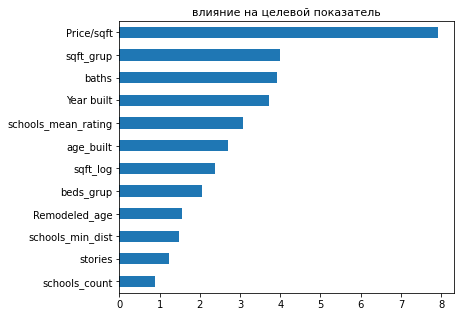

In [245]:
cat_num_cols = num_cols
# посмотрим влияние на целевой параметр всех признаков 
imp_num = pd.Series(f_classif(df[cat_num_cols], df.target)[0], index = cat_num_cols)
imp_num.sort_values(inplace = True)
plt.figure(figsize=(6,5))
imp_num.plot(kind = 'barh').set_title('влияние на целевой показатель',fontsize=11)
display(imp_num)

In [246]:
#Создание dummies feature
df = pd.concat([df, pd.get_dummies(df[cat_cols])], axis=1)
df.drop(cat_cols, axis=1, inplace=True)

In [247]:
df.sample(3)

baths  stories   target  Year built  Remodeled year  Price/sqft  \
237364    1.0        1  1775000        1922               0           5   
299957    2.0        1  1542500        1977            1978           4   
330568    1.0        1   318750        1967               0           2   

        schools_count  schools_min_dist  schools_mean_dist  schools_max_dist  \
237364              8               1.0                1.0               2.0   
299957              3               2.0                3.0               5.0   
330568              8               1.0                2.0               2.0   

        schools_min_rating  schools_max_rating  schools_mean_rating  sqft_log  \
237364                   3                 6.0                    4  7.573017   
299957                   7                 8.0                    7  7.871311   
330568                   2                 8.0                    4  7.714677   

        sqft_grup  beds_grup  age_built  Remodeled_age  status_ACTIVE  \
237364          2          1          9             11              1   
299957          2          3          7              7              0   
330568          2          3          7             11              0   

        status_AUCTION  status_CLOSED  status_COMING SOON  status_CONTINGENT  \
237364               0              0                   0                  0   
299957               0              0                   0                  0   
330568               0              0                   0                  1   

        status_CONTRACT  status_FOR SALE  status_FORECLOSURE  status_NEW  \
237364                0                0                   0           0   
299957                0                0                   0           0   
330568                0                0                   0           0   

        status_OTHER  status_PENDING  status_RENT  propertyType_2-STORY  \
237364             0               0            0                     0   
299957             1               0            0                     0   
330568             0               0            0                     0   

        propertyType_APARTMENT  propertyType_CONDOMINIUM  \
237364                       0                         0   
299957                       0                         0   
330568                       0                         0   

        propertyType_DETACHED  propertyType_DUPLEX  propertyType_MOBILE-HOUSE  \
237364                      0                    0                          0   
299957                      0                    0                          0   
330568                      0                    0                          0   

        propertyType_MULTI-HOUSE  propertyType_MULTI-LEVEL  \
237364                         1                         0   
299957                         0                         0   
330568                         0                         0   

        propertyType_OTHER  propertyType_RANCH  propertyType_SINGLE-HOUSE  \
237364                   0                   0                          0   
299957                   0                   0                          1   
330568                   0                   0                          1   

        propertyType_TOWNHOUSE  street_AVENUE  street_BOULEVARD  \
237364                       0              1                 0   
299957                       0              0                 0   
330568                       0              0                 0   

        street_CIRCLE  street_COURT  street_DRIVE  street_HWAY  street_LANE  \
237364              0             0             0            0            0   
299957              0             0             0            0            0   
330568              0             0             0            0            0   

        street_NO_ADDRESS  street_OTHER  street_PARK  street_PLACE  \
237364                  0             0            0         

In [248]:
df.shape

(327361, 291)

In [249]:
DD = df.drop(['target'],axis = 1)

state_MS                       0.098892
state_MT                       0.128694
propertyType_DUPLEX            0.176645
propertyType_MULTI-LEVEL       0.230178
city_CRYSTAL LAKE              0.339842
city_CLEVELAND HEIGHTS         0.343425
state_KY                       0.347583
city_KINGSPORT                 0.381833
status_COMING SOON             0.385015
city_SHAKER HEIGHTS            0.386241
city_BROWNSVILLE               0.395129
status_CONTINGENT              0.395955
state_NJ                       0.396587
state_OK                       0.419715
city_SARASOTA                  0.429699
state_ME                       0.443271
city_ST PETERSBURG             0.462630
state_VT                       0.494826
city_TALLAHASSEE               0.514775
propertyType_APARTMENT         0.515888
city_MIDLAND                   0.519519
propertyType_DETACHED          0.523751
city_HIXSON                    0.537310
city_ROTONDA WEST              0.568539
city_MCALLEN                   0.569532


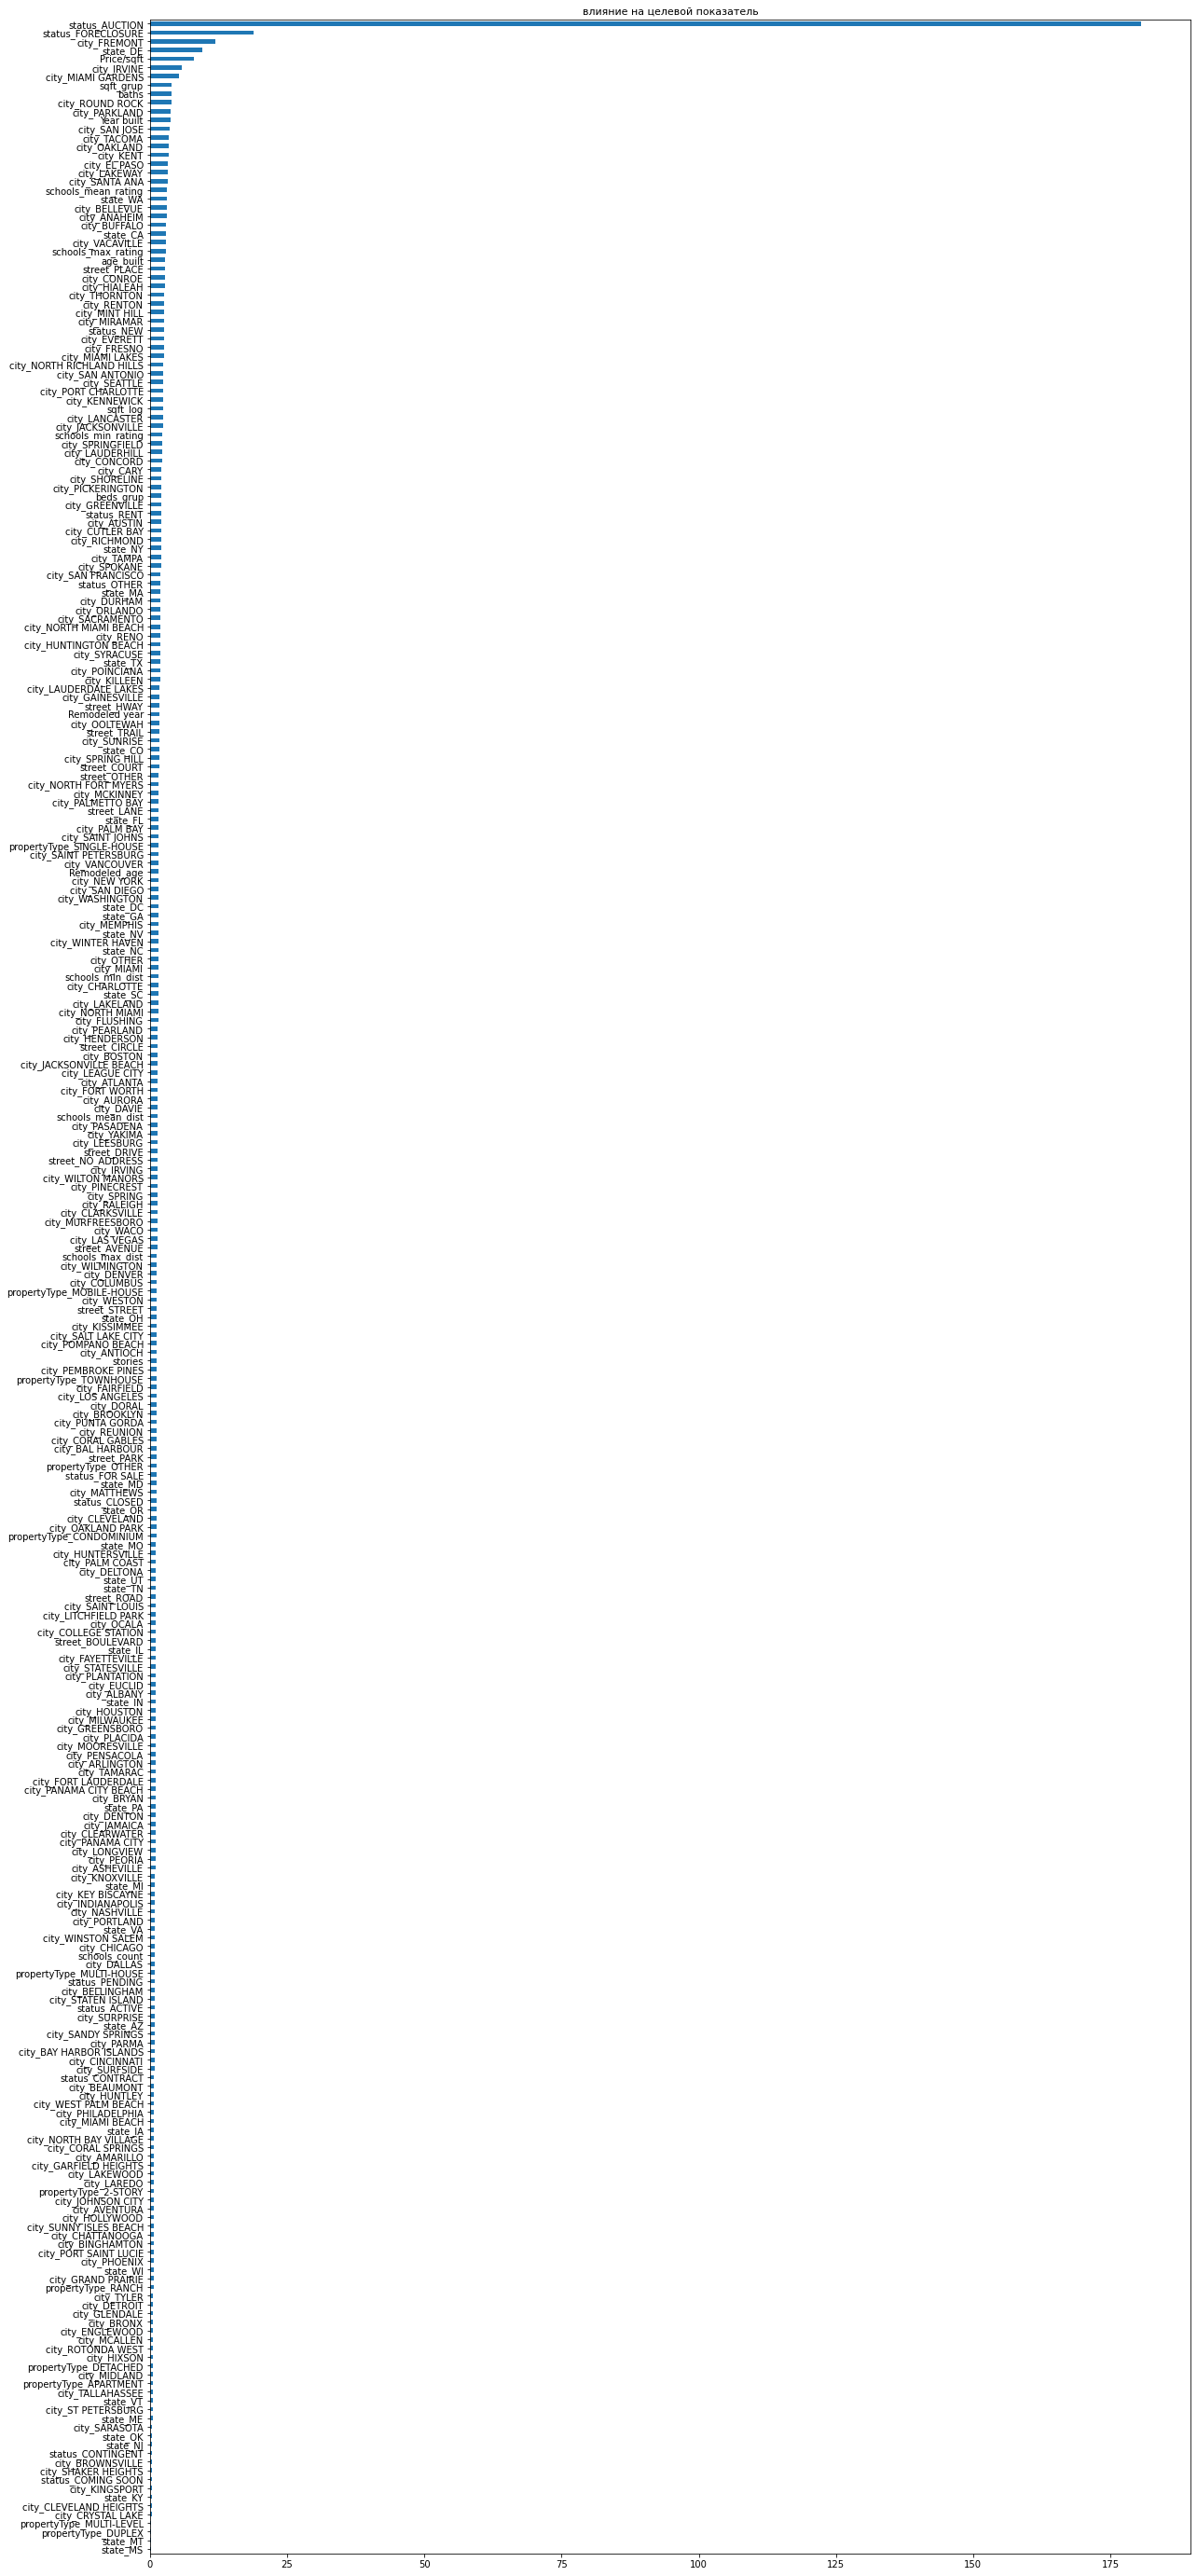

In [250]:
cat_num_cols = DD.columns
# посмотрим влияние на целевой параметр всех признаков (с некоторыми прологарифмированными признаками)
imp_num = pd.Series(f_classif(df[cat_num_cols], df.target)[0], index = cat_num_cols)
imp_num.sort_values(inplace = True)
plt.figure(figsize=(20,50))
imp_num.plot(kind = 'barh').set_title('влияние на целевой показатель',fontsize=11)
display(imp_num)

# Split 

In [251]:

X = df.drop(['target'],axis = 1)
y = df['target']

#Разбиваю данные на test и train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [252]:
num_cols = ['baths',
 'stories',
 'Price/sqft',
 'beds_grup',
 'sqft_grup',
 'Year built',
 'schools_count',
 'schools_min_dist',
 'schools_mean_rating',
 'sqft_log',
 'age_built',
 'Remodeled_age','Remodeled year',
 'schools_mean_dist',
 'schools_max_dist',
 'schools_min_rating',
 'schools_max_rating']

In [253]:
# Произведем маштабирование числовых признаков
from sklearn.preprocessing import MinMaxScaler
# MinMaxScaler не искажает расстояния между значениями в каждой функции.
scaler = MinMaxScaler() 
# scaler = StandardScaler()
# scaler = RobustScaler()

num_cols = X.select_dtypes(include=['number']).columns
num_cols = [x for x in num_cols if x not in ['target']]

X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [254]:
X_train.head()

baths  stories  Year built  Remodeled year  Price/sqft  \
58680   0.333333     0.00    0.993568        0.000000    0.454545   
141854  0.666667     0.50    0.999010        0.000000    0.363636   
50911   0.458333     0.25    0.970312        0.981197    0.181818   
329148  0.333333     0.00    0.999505        0.000000    0.272727   
6094    0.333333     0.50    0.944087        0.977239    0.181818   

        schools_count  schools_min_dist  schools_mean_dist  schools_max_dist  \
58680             0.3          0.285714           0.333333          0.333333   
141854            0.8          0.142857           0.222222          0.250000   
50911             0.3          0.142857           0.333333          0.416667   
329148            0.0          0.000000           0.000000          0.000000   
6094              0.3          0.142857           0.111111          0.166667   

        schools_min_rating  schools_max_rating  schools_mean_rating  sqft_log  \
58680             0.222222            0.444444             0.333333  0.594689   
141854            0.111111            0.444444             0.222222  0.733588   
50911             0.111111            0.111111             0.111111  0.615539   
329148            0.444444            0.444444             0.444444  0.643618   
6094              0.111111            0.222222             0.111111  0.653081   

        sqft_grup  beds_grup  age_built  Remodeled_age  status_ACTIVE  \
58680        0.25        0.2   0.363636       1.000000            0.0   
141854       0.75        0.5   0.181818       1.000000            0.0   
50911        0.25        0.3   0.636364       0.545455            0.0   
329148       0.50        0.3   0.090909       1.000000            1.0   
6094         0.50        0.4   0.909091       0.636364            0.0   

        status_AUCTION  status_CLOSED  status_COMING SOON  status_CONTINGENT  \
58680              0.0            0.0                 0.0                0.0   
141854             0.0            0.0                 0.0                0.0   
50911              0.0            0.0                 0.0                0.0   
329148             0.0            0.0                 0.0                0.0   
6094               0.0            0.0                 0.0                0.0   

        status_CONTRACT  status_FOR SALE  status_FORECLOSURE  status_NEW  \
58680               0.0              1.0                 0.0         0.0   
141854              1.0              0.0                 0.0         0.0   
50911               0.0              1.0                 0.0         0.0   
329148              0.0              0.0                 0.0         0.0   
6094                0.0              1.0                 0.0         0.0   

        status_OTHER  status_PENDING  status_RENT  propertyType_2-STORY  \
58680            0.0             0.0          0.0                   0.0   
141854           0.0             0.0          0.0                   0.0   
50911            0.0             0.0          0.0                   0.0   
329148           0.0             0.0          0.0                   0.0   
6094             0.0             0.0          0.0                   0.0   

        propertyType_APARTMENT  propertyType_CONDOMINIUM  \
58680                      0.0                       1.0   
141854                     0.0                       0.0   
50911                      0.0                       0.0   
329148                     0.0                       0.0   
6094                       0.0                       0.0   

        propertyType_DETACHED  propertyType_DUPLEX  propertyType_MOBILE-HOUSE  \
58680                     0.0                  0.0                        0.0   
141854                    0.0                  0.0                        0.0   
50911                     0.0                  0.0                        0.0   
329148                    0.0                  0.0                        0.0   
6094                      0.0     

**Выбранные метрики:**
* MAE - средний модуль отклонения.
* MAPE - средний процент отклонения.

* R2 - Коэффициент детерминации - это доля дисперсии зависимой переменной, объясняемая рассматриваемой моделью зависимости. Коэффициент можно рассматривать как универсальную меру зависимости одной случайной величины от множества других.Коэффициент детерминации принимает значения от 0 до 1. Для приемлемых моделей коэффициент должен быть не меньше 50%. Модели с коэффициентом детерминации выше 80 % можно признать достаточно хорошими.
* RMSE - 

# Model 1: "Наивная" модель

В качестве нивной модели буду использовать линейную регрессию

In [255]:
# naiv_model = LinearRegression()
# naiv_model.fit(X_train, y_train)
# naiv_predict = naiv_model.predict(X_test) 

# # Вычислим метрики
# metrics_print(y_test, naiv_predict)

# Точность наивной модели по метрике MAE: 729065.60$
# Точность наивной модели по метрике MAPE: 1.73%
# Точность наивной модели по метрике RMSE: 1334266.06

# Точность наивной модели по метрике MAE: 681328.77$
# Точность наивной модели по метрике MAPE: 1.07%
# Точность наивной модели по метрике R2: 0.53%
# Точность наивной модели по метрике RMSE: 1245827.2

# точность если не удалять коллериющие признаки
# Точность наивной модели по метрике MAE: 681115.0$
# Точность наивной модели по метрике MAPE: 1.07%
# Точность наивной модели по метрике R2: 0.53%
# Точность наивной модели по метрике RMSE: 1245471.84

# # # попробую логарифмировние 
# naiv_model_log = LinearRegression()
# naiv_model_log.fit(X_train, np.log(y_train))
# naiv_predict_log = np.exp(naiv_model_log.predict(X_test))

# # Вычислим метрики
# metrics_print(y_test, naiv_predict_log)

# Точность наивной модели по метрике log MAE: 508079.90$
# Точность наивной модели по метрике log MAPE: 0.54%
# Точность наивной модели по метрике log RMSE: 1295334.27

# Точность наивной модели по метрике MAE: 471666.37$
# Точность наивной модели по метрике MAPE: 0.43%
# Точность наивной модели по метрике R2: 0.59%
# Точность наивной модели по метрике RMSE: 1167728.99

# точность если не удалять коллериющие признаки
# Точность наивной модели по метрике MAE: 470750.02$
# Точность наивной модели по метрике MAPE: 0.42%
# Точность наивной модели по метрике R2: 0.59%
# Точность наивной модели по метрике RMSE: 1164834.32

модель с логарифмированием целевой переменной показала лучше результат, чем без лог. Поэтому далее в моделях будем использовать логорифмирование целевого признака

если не удалять корелирующие признаки, то результат немного лучше!

# Model 2 : RandomForestRegressor

In [256]:
# model_rf_log = RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1, verbose=1)
# model_rf_log.fit(X_train, np.log(y_train))

# predict_model_rf_log = np.exp(model_rf_log.predict(X_test))
# # Вычислим метрики
# metrics_print(y_test, predict_model_rf_log)

# best_rfr = RandomForestRegressor(random_state=RANDOM_SEED
#                       , n_estimators=100
#                       , min_samples_split=2
#                       , min_samples_leaf=1
#                       , max_features='sqrt'
#                       , bootstrap=False)

# best_rfr.fit(X_train, np.log(y_train))

# predict_model_rf_log = np.exp(best_rfr.predict(X_test))
# # Вычислим метрики
# metrics_print(y_test, predict_model_rf_log)

# Точность наивной модели по метрике MAE: 193847.06$
# Точность наивной модели по метрике MAPE: 0.18%
# Точность наивной модели по метрике R2: 0.88%
# Точность наивной модели по метрике RMSE: 624210.57

# точность если не удалять коллериющие признаки
# Точность наивной модели по метрике MAE: 190296.76$
# Точность наивной модели по метрике MAPE: 0.18%
# Точность наивной модели по метрике R2: 0.89%
# Точность наивной модели по метрике RMSE: 608647.71

# Model 3 : ExtraTreesRegressor

In [257]:
# model_etr_log = ExtraTreesRegressor(random_state=RANDOM_SEED, n_jobs=-1, verbose=1)
# model_etr_log.fit(X_train, np.log(y_train))

# predict_model_etr_log = np.exp(model_etr_log.predict(X_test))
# # Вычислим метрики
# metrics_print(y_test, predict_model_etr_log)

# Точность наивной модели по метрике MAE: 190113.36$
# Точность наивной модели по метрике MAPE: 0.19%
# Точность наивной модели по метрике R2: 0.88%
# Точность наивной модели по метрике RMSE: 631664.47

# точность если не удалять коллериющие признаки
# Точность наивной модели по метрике MAE: 185691.61$
# Точность наивной модели по метрике MAPE: 0.18%
# Точность наивной модели по метрике R2: 0.88%
# Точность наивной модели по метрике RMSE: 617316.75

# Model 4: CatBoostRegressor

In [258]:

# model_cat = CatBoostRegressor(iterations = 10000,
#                           learning_rate = 0.01,
#                           l2_leaf_reg=2,
#                           random_seed = 42,
#                           eval_metric='MAPE',
#                           custom_metric=['RMSE', 'MAE'],
#                           od_wait=500,
#                           #task_type='GPU',

#                          )
# model_cat.fit(X_train, np.log(y_train),
#          eval_set=(X_test, np.log(y_test)),
#          verbose_eval=1000,
#          use_best_model=True,
#          #plot=True
#          )

In [259]:
# # catboost результат.
# test_predict_catboost = np.exp(model_cat.predict(X_test))

# # Вычислим метрики
# metrics_print(y_test, test_predict_catboost)

# результаты без log
# MAE: 263992.83$
# MAPE: 0.66%
# R2: 0.86%

# Точность наивной модели по метрике MAE: 221729.79$
# Точность наивной модели по метрике MAPE: 0.2%
# Точность наивной модели по метрике R2: 0.87%
# Точность наивной модели по метрике RMSE: 652754.51

# точность если не удалять коллериющие признаки
# Точность наивной модели по метрике MAE: 220955.52$
# Точность наивной модели по метрике MAPE: 0.2%
# Точность наивной модели по метрике R2: 0.87%
# Точность наивной модели по метрике RMSE: 648275.33

In [260]:
# # График обучения

# learn_mape = [round(x * 100, 2)
#               for x in model_cat.evals_result_['learn']['MAPE']]
# valid_mape = [round(x * 100, 2)
#               for x in model_cat.evals_result_['validation']['MAPE']]

# plt.title('MAPE')
# plt.plot(learn_mape, label='learn')
# plt.plot(valid_mape, label='validation')
# plt.legend()
# plt.show()

In [261]:
# # catboost log вариант2
# model_cat_log = CatBoostRegressor(iterations = 10000,
#                           random_seed = RANDOM_SEED,
#                           eval_metric='MAPE',
#                           custom_metric=['R2', 'MAE'],
#                           silent=True,
#                          )

# model_cat_log.fit(X_train, np.log(y_train),
#          eval_set=(X_test, np.log(y_test)),
#          verbose_eval=0,
#          use_best_model=True,
#         )

# # catboost результат. log вариант2
# test_predict_log_catboost = np.exp(model_cat_log.predict(X_test))

# # Вычислим метрики
# metrics_print(y_test, test_predict_log_catboost)

# MAE: 236547.59$
# MAPE: 0.27%
# R2: 0.85%
# Точность наивной модели по метрике MAE: 212897.41$
# Точность наивной модели по метрике MAPE: 0.19%
# Точность наивной модели по метрике R2: 0.88%
# Точность наивной модели по метрике RMSE: 636936.55

# точность если не удалять коллериющие признаки
# Точность наивной модели по метрике MAE: 211363.53$
# Точность наивной модели по метрике MAPE: 0.19%
# Точность наивной модели по метрике R2: 0.88%
# Точность наивной модели по метрике RMSE: 631158.33

In [262]:
# # График обучения

# learn_mape = [round(x * 100, 2)
#               for x in model_cat_log.evals_result_['learn']['MAPE']]
# valid_mape = [round(x * 100, 2)
#               for x in model_cat_log.evals_result_['validation']['MAPE']]

# plt.title('MAPE')
# plt.plot(learn_mape, label='learn')
# plt.plot(valid_mape, label='validation')
# plt.legend()
# plt.show()

# Model 5: XGBRegressor

In [263]:
# model_xgb = xgb.XGBRegressor(random_state=RANDOM_SEED)

# # Обучаем модель и делаем предсказание
# model_xgb.fit(X_train, np.log(y_train),
#               eval_set=[(X_train, np.log(y_train)), (X_test, np.log(y_test))],
#               eval_metric=['mape']
#                 )

In [264]:
# # XGBR результат.
# test_predict_xgb = np.exp(model_xgb.predict(X_test))

# # Вычислим метрики
# metrics_print(y_test, test_predict_xgb)

# # XGBR результат. без log
# MAE: 267461.97$
# MAPE: 0.66%
# R2: 0.86%

# Точность наивной модели по метрике MAE: 225877.22$
# Точность наивной модели по метрике MAPE: 0.21%
# Точность наивной модели по метрике R2: 0.87%
# Точность наивной модели по метрике RMSE: 653150.05

# точность если не удалять коллериющие признаки
# Точность наивной модели по метрике MAE: 226887.96$
# Точность наивной модели по метрике MAPE: 0.21%
# Точность наивной модели по метрике R2: 0.87%
# Точность наивной модели по метрике RMSE: 652807.11

## Настройка параметров

In [265]:
# model_xgb = xgb.XGBRegressor(random_state=RANDOM_SEED)

# parameters = {'n_estimators': sp_randInt(50, 200),
#                 'max_depth': sp_randInt(4, 10),
#                 'learning_rate': sp_randFloat(),
#               }

# randm = RandomizedSearchCV(
#     estimator=model_xgb, param_distributions=parameters, n_jobs=-1)

# randm.fit(X_train, np.log(y_train))

# best_param = randm.best_params_
# best_param

## Используем в модели

In [266]:
# # Используем в модели
# model_xgb = xgb.XGBRegressor(random_state=RANDOM_SEED,
#                             n_estimators=198,
#                             max_depth=7,
#                             learning_rate=0.354
#                             )


# # Обучаем модель и делаем предсказание
# model_xgb.fit(X_train, np.log(y_train),
#               eval_set=[(X_train, np.log(y_train)), (X_test, np.log(y_test))],
#               eval_metric=['mape']
#                 )  

In [267]:
# # XGBR результат.
# test_predict_xgb = np.exp(model_xgb.predict(X_test))

# # Вычислим метрики
# metrics_print(y_test, test_predict_xgb)

# Точность наивной модели по метрике MAE: 214965.17$
# Точность наивной модели по метрике MAPE: 0.2%
# Точность наивной модели по метрике R2: 0.88%
# Точность наивной модели по метрике RMSE: 636758.44

# Model 6 Bagging

## 6.1 со случайным лесом

In [268]:
# best_rfr = RandomForestRegressor(random_state=RANDOM_SEED
#                       , n_estimators=300
#                       , min_samples_split=2
#                       , min_samples_leaf=1
#                       , max_features='sqrt'
#                       , max_depth=None
#                       , bootstrap=False)

In [269]:
# from datetime import datetime
# start = datetime.now()

# bagg_rfr = BaggingRegressor(best_rfr, random_state=RANDOM_SEED)
# bagg_rfr.fit(X_train, np.log(y_train))
# predict_bagg_rfr = np.exp(bagg_rfr.predict(X_test))

# # Вычислим метрики
# metrics_print(start, y_test, predict_bagg_rfr)


## 6.2 С градиентным бустингом

In [270]:
# best_gbr = GradientBoostingRegressor(random_state=RANDOM_SEED, max_depth=9)

In [272]:
# from datetime import datetime
# start = datetime.now()

# bagg_gbr = BaggingRegressor(best_gbr, n_estimators=3, n_jobs=1, random_state=RANDOM_SEED)

# bagg_gbr.fit(X_train, np.log(y_train))
# predict_bagg_gbr = np.exp(bagg_gbr.predict(X_test))

# # Вычислим метрики
# metrics_print(start, y_test, predict_bagg_gbr)


TypeError: metrics_print() takes 2 positional arguments but 3 were given

# Model 6: Stacking
Попробуем стекинг моделей. В качестве базовых моделей выберем две с лучшими результатами - XGBRegressor & ExtraTreesRegressor

Для обработки результатов возьмем линейную регрессию. До этого пробовала брать за последнюю модель CatBoosting, но результаты не получила.

In [273]:
# estimators=[('etr', ExtraTreesRegressor(random_state=RANDOM_SEED, n_jobs=-1, verbose=1)),
#             ('xgb', xgb.XGBRegressor(random_state=RANDOM_SEED,
#                                      n_estimators=198,
#                                      max_depth=10,
#                                      learning_rate=0.354))]
# #      ('xgb', xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5, learning_rate=0.05
# #                                       ,max_depth=12, alpha=1, n_estimators=1000))]

# st_ensemble = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())                                
# st_ensemble.fit(X_train, np.log(y_train))

# predict_ensemble = np.exp(st_ensemble.predict(X_test))
# # Вычислим метрики
# metrics_print(y_test, predict_ensemble)

# Точность наивной модели по метрике MAE: 179306.4$
# Точность наивной модели по метрике MAPE: 0.15%
# Точность наивной модели по метрике R2: 0.89%
# Точность наивной модели по метрике RMSE: 604304.51

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 17.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 12.9min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.9s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    2.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 12.7min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.3s
[Parallel(n_jobs=2)]:

Точность наивной модели по метрике MAE: 189306.4$
Точность наивной модели по метрике MAPE: 0.17%
Точность наивной модели по метрике R2: 0.89%
Точность наивной модели по метрике RMSE: 604304.51


Стекинг дал улучшение модели, но и время значительно увеличилось.

Во время исследования все модели запускались много раз. Проверяли следующие моменты:

- Оставлять или нет корелирующие признаки по дате постройки и реконструкции, мин, макс и средн. дистанцией и рейтингом школ.

- учитывать или нет недвижимость построенная раньше 1750 г,
- логорифмировать или нет числовые признаки и сам таргет!,
- Выбор обработки категориальных данных: Dumming, LabelEncoding
- Проводить или нет стандартизацию данных перед обучением.

По логике все эти процедуры должны улучшать обучение, однако, например

- учет или не учет очеь старой недвижимости практически не изменяет результат. Просто таких очень мало в процентах.
- Не удаление кореллирующих признаков немного улучшило результаты (1-2%). 
- Обработки категориальных данных - Dumming показало лучше результат, чем  LabelEncoding

- Логорифмирование таргета тоже показывает лучше результат

- Предобработка признаков проводилась вручную, каждый отдельно, так как были очень грязные данный!

В результате лучшие результаты показали модели ExtraTreesRegressor (18%), CatBoostRegressor(19%) 
и стекинг моделей, в качестве базовых моделей ( XGBRegressor & ExtraTreesRegressor) (15%)

# Model 7: Tabular NN
Построим обычную сеть:

In [274]:
import tensorflow as tf
import cv2
from tensorflow import keras
from tensorflow.keras import *
from tensorflow.keras.activations import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.layers import *
from tensorflow.keras.layers.experimental.preprocessing import *
from tensorflow.keras.losses import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.optimizers.schedules import *

from tensorflow.keras import optimizers
from tensorflow.keras import Sequential as S
import tensorflow.keras.models as M
from tensorflow.keras.layers import *
import tensorflow.keras.layers as L
from tensorflow.keras.regularizers import l2

**Simple Dense NN**

In [275]:

model = Sequential()
model.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(256, activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(1, activation="linear"))

2023-01-25 09:25:28.356865: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-25 09:25:28.357898: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-25 09:25:28.363802: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-25 09:25:28.364581: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-25 09:25:28.365307: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [276]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               148992    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 280,577
Trainable params: 280,577
Non-trainable params: 0
_________________________________________________________________


In [277]:
# Скомпилируем модель
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [278]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5' , monitor=['val_MAPE'], verbose=0  , mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=50, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

**Fit**

In [ ]:
history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=0,
                   )

In [ ]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [ ]:
test_predict_nn1 = model.predict(X_test)

# Вычислим метрики
metrics_print(y_test, test_predict_nn1[:,0])